# ES RBC tuning simulation
This script is used to numerically evaluate SBO and CSBO in com

## Import dependencies

['..', '/Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim', '/opt/anaconda3/envs/env1/lib/python39.zip', '/opt/anaconda3/envs/env1/lib/python3.9', '/opt/anaconda3/envs/env1/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages', '/opt/anaconda3/envs/env1/lib/python3.9/site-packages/IPython/extensions', '/Users/adrianpaeckelripoll/.ipython']
/Users/adrianpaeckelripoll/rbc-parameter-tuning/mtfunc   was appended to PYTHONPATH
96 50


2022-04-03 15:12:59.996881: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


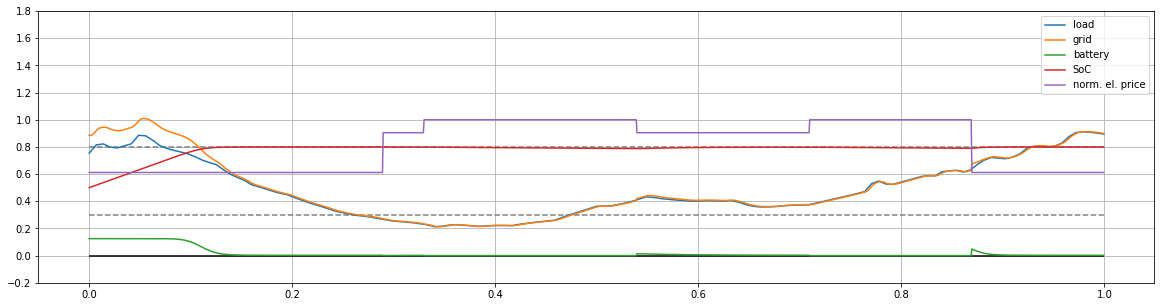

((0.07822648828945584,
  3.306725431534687,
  -0.10822114760874528,
  -4.440889124727503,
  -0.47998011402924606),
 18.0,
 79.95222311172724,
 78.68682487604678)

In [1]:
from __future__ import print_function, division, absolute_import
import os
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import sys
sys.path.insert(0,'..')
print(sys.path)
from mtfunc.helper import *
import safeopt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import tqdm
# plt.style.use('science')

mpl.rcParams['figure.figsize'] = (12, 4)
mpl.rcParams['axes.grid'] = True
# # mpl.rcParams['axes.grid.axis']='y'
# mpl.rcParams['legend.markerscale']=8
# mpl.rcParams['text.usetex']=True

hour=60
day=24*hour
C=96 #kWh
Cdev=1
soc_lim=np.array([30,80])
p_bat_lim=1*C #1C 
p_std=p_bat_lim
soc_std=soc_lim[1]-soc_lim[0]# do not change unless necesary
soc_ref=(soc_lim[1]+soc_lim[0])/2
soc_softc=[32,80]
dt=1
S_os_max=0 # max overshoot of SoC; ex. SoC_max=soc_lim[1]+S_os_max
print(p_std,soc_std)

import tensorflow as tf
from tensorflow import keras
# phib
bat_dense_model=tf.keras.models.load_model('../ES_model/saved_models/p-dsoc_2-7-1_.h5')


phib=np.asarray(pd.read_csv('/Users/adrianpaeckelripoll/rbc-parameter-tuning/ES_model/PWLmodel_par_opti.csv',index_col='Unnamed: 0'))

data=get_data('model_data/model_winter_data_2022_03_15_0131.csv',npy=False)

def batt_model_generator(x,soc_i,mtype='PWL',model=bat_dense_model):
# Creates generator of the battery model
# IC for soc
# first siganl out is IC when initialized (send(None))
# send(power) for next signal
    if mtype=='PWL':
        cut1=x[5]
        cut2=x[6]
        def soc_func(soc,p):
            dsoc=x[0]+x[1]*max(cut1,p)+x[2]*max(0,p)+x[3]*max(cut2,p)+x[4]*p
            if dsoc>x[9]: dsoc=x[7]*dsoc
            if dsoc<x[10]: dsoc=x[8]*dsoc
            return soc+dsoc/Cdev
    if mtype=='ANN':
        assert model is not None                            
        def soc_func(soc,p):
            dsoc=model.predict(np.atleast_2d([p])).flatten()
            return soc+dsoc
        
    soc=soc_i
    p=0
    while True:
        p=yield soc
        soc=soc_func(soc,p)[0]

P1=188 # buy price in euro/MWh
P2=170
P3=115
S1=53 #sell price in euro/MWh
B1=0
def price_fun(k=None):
    price=DemandSignal(day,dt,1)
    price.step_signal([0.29,0.33,0.54,0.71,0.87],[P3,P2,P1,P2,P1,P3])
    if k is None:
        return price.signal
    else:
        return price.signal[k]
# B1=0
# P1=200
# P3=150
# S1=50
# def price_fun(k=None):
#     price=DemandSignal(day,dt,1)
#     price.step_signal([0.2,0.4,0.6,0.7,0.9],[P1,P3,P1,P3,P1,P3])
#     if k is None:
#         return price.signal
#     else:
#         return price.signal[k]
    
# plt.figure(figsize=(7,3))    
# price=DemandSignal(day,dt,1)
# price.step_signal([0.29,0.33,0.54,0.71,0.87],[P3,P2,P1,P2,P1,P3])
# price.plot()    

def batt_control_generator(dt,a,soc_lim,p_bat_lim,N,past,p_set=[0,4],T=day):
# Creates a generator of the BMS
# P_bat >0 for charging 
# a: array, RBC parameters
# soc_lim: array, SoC limits (0,100)
# p_bat_lim: battery charge and discharge limits in kW
# N: array, moving avarage window widths for peak shaving in minutes
# dt= sampling period in minutes

#past=past 24h(or needed by average) mmnt of power_demand
        k=0
        soc_ref=50
        soc=50
        p_avg=past[-N[0]//dt:].sum()/past[-N[0]//dt:].size
        def p_cap():
            p_2=past[-15//dt:].sum()/past[-15//dt:].size
            p_1=past[-1//dt:].sum()/past[-1//dt:].size
            return p_2-p_1
        def p_soc(max_power=C/6):
            return max_power*((soc_ref-soc)/soc_std*2)**3
        
        def p_soc_lim(g):
            dsoc=soc_ref-soc
            if dsoc>0:
                return (abs(dsoc)/soc_std*2)**g
            else:
                return -(abs(dsoc)/soc_std*2)**g
        def p_24h_average_tracking():
#             p_avg=np.dot(ramp_window(N[0]),past[-N[0]//dt:])

            p_avg_day=past[-N[1]//dt:].sum()/past[-N[1]//dt:].size
            return p_avg_day-p_avg
    
        def p_price(price,expand,shift,p_bound=C/6):
            norm_max_power=p_bound/(P1-P3)*price[k]-p_bound/(P1-P3)*P3
            return np.clip(-p_avg,-expand*norm_max_power-shift*p_bound,None)

        def lim_fun_2(price,expand,shift,p_bound=C/6):
            # bound=l*price+d
            norm_max_power=p_bound/(P1-P3)*price-p_bound/(P1-P3)*P3
            return expand*norm_max_power+shift*p_bound

        def control_3_1_2():
            # Monetary version of controller_max_dis
            # SoC limiting always depending on p_bat
            # Always charge battery instead of injecting to the grid at 1C power (1kWh->1kW)
            #Par: expansion,shift, gamma (p_soc_lim)
            p_bound=C/4
            max_bound=lim_fun_2(price_fun(k),a[0],a[1],p_bound=p_bound)
            gamma=11
            p_bat=np.clip(-p_avg,-max_bound,p_bat_lim)
            if (p_avg>0): p_bat= np.clip(p_bat,-p_avg,None)
            else: p_bat= np.clip(p_bat,None,-p_avg)
            if p_bat>0:
                p_bat=p_bat*(1+p_soc_lim(gamma))
            else:
                p_bat=p_bat*(1-p_soc_lim(gamma)) 
            return p_bat

                
        while True:
            p_avg=past[-N[0]//dt:].sum()/past[-N[0]//dt:].size

            if k*dt/day<24/24:
                p_bat=control_3_1_2()
            else:
                p_bat=p_bat_lim*p_soc_lim(1)
#             Hard constraints battery safety (10,90)
            if soc>90:
                p_bat=min(0,p_bat)
            if soc<20:
                p_bat=max(0,p_bat)
#             Max charge/discharge power saturation 1C
            p_bat=np.clip(p_bat,-p_bat_lim,p_bat_lim)
                
            soc,soc_ref,p_dem,k=yield p_bat,p_cap()# gets soc, soc_ref, p_dem ;; p_bat out
            past=np.append(past,p_dem)

%matplotlib inline
def add_sin_noise(x,period,amp,rnd=0.5,k=None):
    if k is None:
        t=np.arange(len(x))*dt
        phase_noise=2*rnd*np.pi*np.random.rand(len(x))
        w=2*np.pi/period
        n=amp*np.sin(w*t+phase_noise)
        return x+n
    else:
        t=k*dt
        phase_noise=2*rnd*np.pi*np.random.rand()
        w=2*np.pi/period
        n=amp*np.sin(w*t+phase_noise)
        return x+n  
# df=np.ones(100)
# plt.plot(range(100),df)
# plt.plot(range(100),add_sin_noise(df,60,0.1,0.9))

def plant_cost(x,T=1,p_load=data.power_load.values,N_lim=[15,day],soc_lim=soc_lim,soc_softc=soc_softc,soc_i=50,phib=phib,plot=False,plot_cost=False,plot_constrain=False,
               soc_ref=soc_ref,dt=1,p_set=[0,4],noise=False):
# Takes new control parameters, simulates a day and outputs cost and contrain functions
    
# x: array, RBC parameters
# T: optimization period in days
# soc_lim: array, SoC limits 
# soc_ref: reference for SoC controler
# dt: sampling period in minutes
# N_lim: array, moving avarage window widths for peak shaving 
# p_set: power upper limit for band gap controller
#     %matplotlib 
    %matplotlib inline
    mpl.rcParams['figure.figsize'] = (20, 5)
#     p_set[1]=x[0]*C/6
    dt=dt
    T=T*day//dt
    p_load=p_load[:T+N_lim[1]]
    bc=batt_control_generator(dt,x,soc_lim,p_bat_lim,N_lim,p_load[:N_lim[1]//dt],p_set=p_set,T=T)
    p_load=p_load[N_lim[1]//dt:]
    bm=batt_model_generator(phib,soc_i)
    soc=[bm.send(None)] #Initialize battery model ->SoC_0
    bc.send(None)
    p_bat=[] #Initiliazation controller
    p_grid=[]
    p_2=[]
    p_1=[]
    if noise:
        for k,po in enumerate(p_load):
            p_bat+=[bc.send((add_sin_noise(soc[-1],hour,0.5,0.5,k),soc_ref,add_sin_noise(po,hour,load_noise,0.5,k),k))[0]]
            p_cap=bc.send((add_sin_noise(soc[-1],hour,0.5,0.5,k),soc_ref,add_sin_noise(po,hour,load_noise,0.5,k),k))[1]
            soc+=[bm.send(add_sin_noise(p_bat[-1],hour,bat_noise,1,k))]
            p_grid+=[p_bat[-1]+po+p_cap]
    else:
        for k,po in enumerate(p_load):
            p_bat+=[bc.send((soc[-1],soc_ref,po,k))[0]]
            p_cap=bc.send((soc[-1],soc_ref,po,k))[1]
            soc+=[bm.send(p_bat[-1])]
            p_grid+=[p_bat[-1]+po+p_cap]                   
# save last soc for initial point next iteration
    soc_f=soc[int(T*23.5/24)]
    soc=np.array(soc[:-1])
    p_grid=np.array(p_grid)
    p_bat=np.array(p_bat)
#  Plot SoC, P_bat, P_grid and P_load   
    if plot:
        time=np.arange(0,p_load.size)/60/24
        plt.plot(time,p_load/p_std,label='load')
        plt.plot(time,p_grid/p_std,label='grid')
        plt.plot(time,p_bat/p_std,label='battery')
        plt.plot(time,soc/100,label='SoC')
        plt.plot(time,price_fun()/P1,label='norm. el. price')
        plt.hlines(0,0,time[-1],'k')
        plt.hlines(soc_lim[0]/100,0,time[-1],linestyles='--',color='grey')
        plt.hlines(soc_lim[1]/100,0,time[-1],linestyles='--',color='grey')
        plt.ylim([-0.2,1.6])
        plt.yticks(np.arange(-0.2,2,0.2))
#         plt.xlim([22/24,1])
        plt.legend()
#         plt.savefig('../fig_scripts/RBC312/RBC312_035_m02.png')
        plt.show()
        
    def cost_f(plot=plot_cost):
# #         maximal SoC overshoot normalization
#         max_soc_os=5
        def bat_soc_cost_fun(s,bound=soc_lim,ref=soc_ref,r=1):
#         w_k=f(s_k) triangular weight function
#         s=SoC
#         ref=max reward SoC
#         r=max reward
#         bound=[lower,upper]
            if s<=ref:
                return r*bound[0]/(bound[0]-ref)+r/(ref-bound[0])*s
            if s>ref:
                return +r*bound[1]/(bound[1]-ref)+r/(ref-bound[1])*s
        
        w_bat_soc=np.array(list(map(bat_soc_cost_fun,soc)))        
        p_bat_soc=np.abs(p_bat)/(p_std)**0.5
        p_bat_soc=p_bat_soc*w_bat_soc
        
        
        def ps_reward_fun(pg,pl):
            dpg=max(0,pg-p_set[1])
            dpl=max(0,pl-p_set[1])
            return dpl-2*dpg
        r_ps=np.array(list(map(ps_reward_fun,p_grid,p_load)))
        r_ps=r_ps/p_bat_lim
        
        def soc_cost_fun(s):
        #     s:float, soc
        #     l: float, lower bound
        #     u:float, upper bound
            if s>soc_lim[1]:
                cost=(s-soc_lim[1])**1
            elif s<soc_lim[0]:
                cost=(soc_lim[0]-s)**1
            else:
                cost=0
            return cost
        soc_lim_cost=np.array(list(map(soc_cost_fun,soc)))/soc_std  
        
        soc_norm=np.abs(np.power((soc-soc_ref)/soc_std,3))
        soc_norm=soc_norm
        

# #         Final SoC reward
#         r_soc_f=(soc_i-soc_ref)/soc_std
#         if r_soc_f>0: r_soc_f=-r_soc_f/2
#         Final SoC reward
#         C_bat_f=(soc_f-soc_ref)/100*C
#         if C_bat_f<0:
#             r_s_f=C_bat_f*(P3+B1)/((P1-B1)*C)
#         else:
#             r_s_f=C_bat_f*(P3-B1)/((P1-B1)*C)     
        C_bat_f=(soc_f-soc_i)/100*C #[kWh]
        if C_bat_f<0:
            r_s_f=C_bat_f*(P3+B1)*1e-3 #[euro]
        else:
            r_s_f=C_bat_f*(P3-B1)*1e-3

        def r_price_sell_fun():    
            def price_sell_map_fun(p_bat,p_load,f_buy,f_sell,f_bat):
                if (-p_bat<=p_load)&(p_load>=0):
                    return -p_bat*f_buy + max(0,np.sign(-p_bat))*p_bat*f_bat
                if (-p_bat>p_load)&(p_load>=0):
                    return -f_sell*(p_bat+p_load)+f_buy*p_load + max(0,np.sign(-p_bat))*p_bat*f_bat
                if (-p_bat<=p_load)&(p_load<0):
                    return -f_buy*(p_bat+p_load)+f_sell*p_load + max(0,np.sign(-p_bat))*p_bat*f_bat
                if (-p_bat>p_load)&(p_load<0):
                    return -p_bat*f_sell + max(0,np.sign(-p_bat))*p_bat*f_bat
                else: return 0
            return np.array(list(map(price_sell_map_fun,p_bat,p_load,price_fun(),S1*np.ones(T),B1*np.ones(T))))/hour*dt*1e-3 # [euro]
        r_price_sell=r_price_sell_fun()

#       Plot different costs; for experiment evaluation
        if plot:
#             plt.figure(figsize=(15,5))
            time=np.arange(0,p_load.size)/60/24

            plt.plot(time,p_bat_soc,label='battery reward')
            plt.plot(time,r_ps,label='peak-shaving reward')
#             plt.plot(time,r_price,label='monetary reward')
            plt.plot(time,r_price_sell,label='monetary reward')
#             plt.plot(time,p_grid_norm,label='grid_cost')
            plt.plot(time,soc_norm,label='soc_cost')
#             plt.plot(time,soc_lim_cost,label='soc_lim_cost')
#             plt.plot(time,ps_norm,label='ps_grid_cost')
#             plt.plot(time,p_bat_ps_norm,label='ps_batt_cost')
#             plt.plot(time,mask,label='mask')
            plt.legend()
            plt.grid(True)

        return  p_bat_soc.sum()/T,r_s_f,-soc_norm.sum()/T,r_price_sell.sum(),r_ps.sum()/T


    def safe_const(prnt=False):
#         Safe constrain: max over/undershoot
        q=min(soc)-soc_softc[0]
        if prnt:print(q)
        return q
    def local_soc_min(s,si):
        if min(s)<si:
            return min(s)
        else:
            order=hour/dt
            base_idx=signal.argrelmin(s,order=int(order))[0]
            if len(s[base_idx])>0:
                return min(s[base_idx])
            else :
                return s[-1]
    
#     def safe_const(prnt=False):
# #         Safe constrain: max over/undershoot
#         q=max([0,max(soc)-soc_lim[1],soc_lim[0]-min(soc)])
#         if prnt:print(q)
#         return -q


    return cost_f(),safe_const(),soc_f,local_soc_min(soc,soc_i)

plant_cost([0.5 ,-0.5],plot=True)

## Generate data

In [175]:
def data_prepocess(df,rss_bounds=None):
    data=df.copy()
    def baseline_fun(data):
#     peak,_=signal.find_peaks(data.values,prominence=(20, None),)
        order=12*hour/dt
        base_idx=signal.argrelmin(data.values,order=int(order))[0]
        mask=np.empty_like(data.values)
        mask[:]=np.nan
        bs=pd.Series(mask)
        bs.iloc[base_idx]=data.iloc[base_idx]
        bs=bs.ffill()
        bs=bs.bfill()
    #     bs[:]=gaussian_filter1d(bs.values,sigma=2*order)
    #     bs.plot()
        return bs.mean()


    pv_signals=['power_pv_sfw_t100', 'power_pv_sfw_t101','power_pv_sfw_t102',
                'power_pv_sol_t100','power_pv_meter_dfab','power_pv_move','power_pv_move_t100']
    loads=['power_sfw', 'power_dfab', 'power_sol','power_vw','power_umr','power_m2c','power_move']
#     data.power_pv_dfab_t100=-data.power_pv_dfab_t100
    data['power_pv']=data[pv_signals].sum(axis=1)
#     data['soc'] = data[['soc_min', 'soc_max']].mean(axis=1)
    data['power_load']=data[loads].sum(axis=1)
    data['power_demand']=data.power_load-data.power_pv
    shft=data.reset_index()[data.index.strftime('%A')=='Monday'].index[0]
    print('Cos/sin week start on: ',data.index[shft].strftime('%A'))
    data=data.reset_index(drop=False)
    data['time']=data.index*dt-shft*dt
    data['day_sin']=np.sin(2*np.pi*data.time/day)
    data['day_cos']=np.cos(2*np.pi*data.time/day)
    data['week_sin']=np.sin(2*np.pi*data.time/day/7)
    data['week_cos']=np.cos(2*np.pi*data.time/day/7)
    data=data.set_index('timestamp',drop=True)
    inputs_demand=['power_demand','outside_temperature_fc',
            'day_sin','day_cos','week_sin','week_cos']

    inputs_PV=['sun_fc', 'outside_temperature_fc', 'rh_outside_fc',
       'solar_elevation', 'solar_azimuth']        
    # data['power_pv_fc']=np.dot(np.transpose(np.atleast_2d(data.sun_fc.values)),phipv)
    signals=['power_load','power_bypass_ehub','power_bat_meter','power_ehub','power_demand','power_pv']
    inputs=list(set(signals)|set(inputs_demand)|set(inputs_PV))
    print(inputs)
    data=data[inputs].apply(gaussian_filter1d,sigma=2,raw=True)
    # data.reset_index(inplace=True)

    data.loc[data.power_demand<=0,'power_demand']=0
    return data.shift(1).dropna()
def data_context(data):
    data['power_load_']=np.clip(data.power_load,-p_bat_lim,p_bat_lim)
    data['pp']=data.power_load_[data.power_load>0]
    data.pp=data.pp.fillna(0)
    data['pm']=data.power_load_[data.power_load<=0]
    data.pm=data.pm.fillna(0)
    data.drop(columns='power_load_',inplace=True)

    data['e_dis']=data.pp.rolling(window=day//dt).sum()/hour*dt/C #kWh
    data['e_char']=data.pm.rolling(window=day//dt).sum()/hour*dt/C #kWh
    data.e_char=data.e_char.abs()
    data.e_char=np.clip(data.e_char,0,np.diff(soc_lim)[0]/100)
    return data
    

demand_10min_model=tf.keras.models.load_model('../saved_models/loss_10minpowerdev_convtd_powerdemand_dayweeksincos_4h')
demand_model=tf.keras.models.load_model('../saved_models/loss_demand_convtd_1dpowerdemand_Tfc_dayweeksincos_7w')
PV_model=tf.keras.models.load_model('../saved_models/s1PVpower_3conv')



def demand_generator(df,model=demand_model,p_bs=100,init_demand=None):
    dt=60
    dt10min=10    
    data=df.reset_index().copy()
    conv_width_demand=7*day//dt
    conv_width_10=4*hour//dt10min
    STEPS=day//dt
    Tin=conv_width_demand+STEPS-1
    inputs_demand=['power_demand','outside_temperature_fc',
        'day_sin','day_cos','week_sin','week_cos']        
    inputs_demand_10min=['power_demand',
        'day_sin','day_cos','week_sin','week_cos']        

    if init_demand is not None:
        if len(init_demand)<Tin:
            print('init_demand not long enough')
        init_demand=init_demand[:Tin]
        print(len(init_demand),len(data.loc[:len(init_demand),'power_demand']),len(data))
        data.loc[:len(init_demand)-1,'power_demand']=init_demand
    length=len(data)*dt//day-1
    for n in range(Tin*dt//day+1,length):  
        data.loc[n*STEPS:n*STEPS+STEPS-1,'power_demand']=model.predict(data.loc[n*STEPS-Tin:n*STEPS-1,inputs_demand].values[None,:,:]).flatten()
    data=data.set_index('timestamp').resample(f'{dt10min}T').mean().interpolate().reset_index()
    data.loc[conv_width_10-1:,'power_dev']=demand_10min_model.predict(data.loc[:,inputs_demand_10min].values[None,:,:]).flatten()
    data['power_demand']=data.power_demand-data.power_dev
    data.loc[data.power_demand<0,'power_demand']=0
    data=data[8*day//dt10min:].set_index('timestamp').resample('1T').mean().interpolate()
    data.power_demand=data.power_demand+p_bs
    return data


def pv_generator(df,model=PV_model):
    dt=60
    data=df.reset_index().copy()
    conv_width=3*hour//dt
    STEPS=day//dt
    inputs_PV=['sun_fc', 'outside_temperature_fc', 'rh_outside_fc',
       'solar_elevation', 'solar_azimuth']        
    length=len(data)*dt//day-1
    for n in range(conv_width*dt//day+1,length):  
        data.loc[n*STEPS:n*STEPS+STEPS-1,'power_pv']=model.predict(data.loc[n*STEPS-conv_width+1:n*STEPS+STEPS-1,inputs_PV].values[None,:,:]).flatten()
    return data.set_index('timestamp')

def load_generator(df):
    dt=60
    data=df.resample(f'{dt}T').mean().interpolate()
    data=pv_generator(data)
    init_demand=DemandSignal(period=8*day,dt=60,rep=1)
    bins=8*day//dt
#     init_demand.step_signal(list(np.sort(np.random.rand(bins)))[:-1],np.random.rand(bins))  
    init_demand.step_signal([0,],[1,1])
    data=demand_generator(data,init_demand=50*init_demand.signal,p_bs=5)
    data['power_load']=data.power_demand-data.power_pv
    return data

In [ ]:
#%matplotlib
data=data_prepocess(winter)
data= data_context(load_generator(data))
data[['power_demand','power_load']].plot()
save_data(data,'model_winter_data',folder='model_data',npy=False)

# 2D-Grid search cost function

## Random search NLopt

In [122]:
import nlopt as nl
max_eval=500
days=len(data)//day-1
rnd_opt_cst=[]
rnd_opt_par=[]
soc_lim=[30,80]
soc_softc=[40,80]
soc_ref=(soc_lim[1]+soc_lim[0])/2
S_os_max=0
S_f_sp=55
print(max_eval,soc_ref,soc_lim,S_f_sp,S_os_max)

for d in range(days):
    print('day: ',d)
    def cost(x,gradient=0):
        c=plant_cost(x,p_load=data.power_load.values[d*day:],T=1,N_lim=[15,day],soc_lim=soc_lim,soc_softc=soc_softc,soc_ref=soc_ref,soc_i=50,phib=phib,noise=False)[0]
        cost=c[3]+c[1]
        return -cost
    def constraint(x,gradient=0):
        q=plant_cost(x,p_load=data.power_load.values[d*day:],T=1,N_lim=[15,day],soc_lim=soc_lim,soc_softc=soc_softc,soc_ref=soc_ref,soc_i=50,phib=phib,noise=False)[-2:]
#         print( -(q[-1]-S_f_sp)-S_os_max)
        return -q[-2]
#     Global optimization
    opt = nl.opt(nl.GN_ISRES, 2)
    opt.set_lower_bounds([0,-1])
    opt.set_upper_bounds([5,1])
    opt.set_min_objective(cost)    
    opt.add_inequality_constraint(lambda x,grad: constraint(x,grad), 1e-8)
    opt.set_xtol_rel(1e-2)
    opt.set_maxeval(max_eval)
    a = opt.optimize([0.2,-0.2])
#     Local optimization
    opt = nl.opt(nl.LN_COBYLA, 2)
    opt.set_lower_bounds([0,-1])
    opt.set_upper_bounds([5,1])
    opt.set_min_objective(cost)    
    opt.add_inequality_constraint(lambda x,grad: constraint(x,grad), 1e-8)
    opt.set_xtol_rel(1e-4)
    opt.set_maxeval(max_eval)
    a = opt.optimize(a)
    minf = opt.last_optimum_value()
    rnd_opt_par.append(a)
    rnd_opt_cst.append(minf)
    print("optimum at ", a[0], a[1])
    print("minimum value = ", minf)
    print("result code = ", opt.last_optimize_result())
    

500 55.0 [30, 80] 55 0
day:  0
optimum at  0.45445522607479805 -0.3046969182526145
minimum value =  0.021037171301771906
result code =  4
day:  1
optimum at  0.6494190918736573 -0.4123550230822994
minimum value =  -0.847575790322957
result code =  4
day:  2
optimum at  0.38186441058550114 -0.23208910525694798
minimum value =  -0.07218762801498319
result code =  4
day:  3
optimum at  0.9771847075369777 -0.7852396505852698
minimum value =  0.2173691284421415
result code =  4
day:  4
optimum at  0.45406791165985544 -0.30477335425944424
minimum value =  0.00970675155758588
result code =  4
day:  5
optimum at  0.983651815110452 -0.7912204215320356
minimum value =  0.21743556609312753
result code =  4
day:  6
optimum at  0.9907485924473014 -0.7540463699557383
minimum value =  -0.4132660202650338
result code =  4
day:  7
optimum at  0.37853401988487045 -0.23179025604439113
minimum value =  0.08035260587015136
result code =  4
day:  8
optimum at  0.45609090184834505 -0.3053018880428963
minimum

In [123]:
save_data(np.array(rnd_opt_par),'rnd_opt_par_winter_B20',folder='NL_opt')
save_data(np.array(rnd_opt_cst),'rnd_opt_cst_winter_B20',folder='NL_opt')

NL_opt/rnd_opt_par_winter_B20_2022_02_28_1211
NL_opt/rnd_opt_cst_winter_B20_2022_02_28_1211


In [32]:
rnd_opt_cst=get_data('NL_opt/rnd_opt_cst_winter_2022_02_26_0936.npy')
rnd_opt_par=get_data('NL_opt/rnd_opt_par_winter_2022_02_26_0936.npy')
 


In [39]:
rss_df=data.Rss_day.asfreq('D').shift(-2) # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
e_ch=data.e_char.asfreq('D').shift(-2)
e_dis=data.e_dis.asfreq('D').shift(-2)



rnd_opt_par=np.vstack(rnd_opt_par)
rnd_opt_cst=np.vstack(rnd_opt_cst)

fiirss=rss_df.values[:len(rnd_opt_par)][:,None]
fiiech=e_ch.values[:len(rnd_opt_par)][:,None]
foo=np.hstack([fiirss,fiiech,rnd_opt_par])

plt.plot(e_ch[:len(rnd_opt_par)] ,-rnd_opt_cst[:,0],'.')

## Grid search

In [58]:
def cost(x,data):
    return np.array(plant_cost(x,T=1,p_load=data,soc_i=50,phib=phib,noise=False)[0])
def constrain(x,data):
    return plant_cost(x,T=1,p_load=data,soc_i=50,phib=phib,noise=False)[1:]

N_samples1=100
N_samples2=100
days=1
n_costs=len(cost([0,0],data=data.power_load.values))
n_const=len(constrain([0,0],data=data.power_load.values))
par1=np.linspace(0,2,N_samples1)
par2=np.linspace(-1,1,N_samples2)
Z=np.zeros((days,len(par1),len(par2),n_costs))
Q=np.zeros((days,len(par1),len(par2),n_const))
stat=0

for d in range(days):
    for i,x_ in enumerate(par1):
        for j,y_ in enumerate(par2):
                print(f'{stat/days/N_samples1/N_samples2*100:.3f}','%',end='\r')
    #                 print(len(cost.send([x_,y_,z_])[0]))
                Z[d,i,j,:] =cost([x_,y_],data=data.power_load[d*day//dt:])
                Q[d,i,j] = constrain([x_,y_],data=data.power_load[d*day//dt:])
                stat=stat+1

In [59]:
name='winter_c_3_1_2'
datafolder=os.path.join('data',name)
meta=np.array([par1,par2])
save_data(meta,'meta',folder=datafolder)
save_data(Z,'cost',folder=datafolder)
save_data(Q,'constraint',folder=datafolder)

data/winter_c_3_1_2/meta_2022_03_20_1304
data/winter_c_3_1_2/cost_2022_03_20_1304
data/winter_c_3_1_2/constraint_2022_03_20_1304


0

## Performance function evaluation

#### Get data


In [78]:
# data=data_prepocess(summer)
# Z=get_data('data/summer_c_3_1_2/cost_2022_02_27_0526.npy')
# Q=get_data('data/summer_c_3_1_2/constraint_2022_02_27_0526.npy')
# par1,par2=get_data('data/summer_c_3_1_2/meta_2022_02_27_0526.npy')
# Z=get_data('data/winter_c_3_1_2/cost_2022_03_01_0909.npy')
# Q=get_data('data/winter_c_3_1_2/constraint_2022_03_01_0909.npy')
# par1,par2=get_data('data/winter_c_3_1_2/meta_2022_03_01_0909.npy')
Z=get_data('data/winter_c_3_1_2/cost_2022_03_20_0231.npy')
Q=get_data('data/winter_c_3_1_2/constraint_2022_03_20_0231.npy')
par1,par2=get_data('data/winter_c_3_1_2/meta_2022_03_20_0231.npy')
# Z=get_data('data/winter_c_3_1_2/cost_2022_03_20_1304.npy')
# Q=get_data('data/winter_c_3_1_2/constraint_2022_03_20_1304.npy')
# par1,par2=get_data('data/winter_c_3_1_2/meta_2022_03_20_1304.npy')
print(Z.shape)
print(Q.shape)
Q[:,:,:,1]=Q[:,:,:,1]-55

(30, 50, 50, 7)
(30, 50, 50, 7)


In [79]:
days=Q.shape[0]
n_costs=Z.shape[-1]
optcst=np.zeros((days,n_costs))
optpar=np.zeros((days,n_costs,2))
cost_list=['r_b','g_sf','g_sr','r_money','r_ps']
X,Y=np.meshgrid(par1,par2)

# cost_list=['r_ps','r_b','r_ss','g_sf','g_b','g_sr','g_g','r_price','r_money']

In [71]:
cst_mmnt_noise=Z[:,:,:,3].std(axis=0)
const_mmnt_noise=Q[:,:,:,1].std(axis=0)
cst_std=Z[:,:,:,3].std()
const_std=Q[:,:,:,1].std()
cst_mean=Z[:,:,:,3].mean()
const_mean=Q[:,:,:,1].mean()
print('Cost measurement std (noise) is: ',cst_mmnt_noise.mean())
print('Constraint measurement std is:' ,const_mmnt_noise.mean())
print('Cost  std (noise) is: ',cst_std.mean())
print('Constraint  std is:' ,const_std.mean())
print('Cost mean is: ',cst_mean)
print('Constaint mean is: ',const_mean)

Cost measurement std (noise) is:  0.0
Constraint measurement std is: 0.0
Cost  std (noise) is:  2.2384909618004816
Constraint  std is: 20.791582423236132
Cost mean is:  0.24079578359035023
Constaint mean is:  -8.178491995608889


#### One cost, all days

In [27]:
# Z1=np.load('data/cost_winter_c_3_0__all_01_23_2022_0458.npy')[0:1,:,:,:]
# Z2=np.load('data/cost_winter_c_3_0__all_ann_01_23_2022_1837.npy')
%matplotlib
# cst=Z[10,:,:,0]

for d in range(days):
    cst=Z[d,:,:,3]
    X,Y=np.meshgrid(par1,par2)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
#     ax.contour3D(X.transpose(), Y.transpose() ,Q[d,:,:,1]/10,10, cmap='viridis')
    ax.plot_surface(X.transpose(), Y.transpose() ,cst,cmap='viridis')

    ax.set_xlabel('par1')
    ax.set_ylabel('par2')
    ax.set_zlabel('performance')

Using matplotlib backend: MacOSX


 /var/folders/w3/j7m_f8sj3j326rztbz0fqhlm0000gn/T/ipykernel_1758/165936606.py:9: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


#### All cost, all days

In [90]:

for nc in range(n_costs):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    cst=Z[:,:,:,nc]
    print(cst.shape)
    print(cost_list[nc])
    print('best day=',np.unravel_index(cst.argmax(), cst.shape)[0])
    print('best par=',par1[np.unravel_index(cst.argmax(), cst.shape)[1]],par2[np.unravel_index(cst.argmax(), cst.shape)[2]])
    for k in range(Z.shape[0]):
        ax.contour3D(X.transpose(), Y.transpose() ,cst[k],200, cmap='viridis')
        optcst[k,nc]=cst[k].max()
        optpar[k,nc,:]=[par1[np.unravel_index(cst.argmax(), cst.shape)[1]],par2[np.unravel_index(cst.argmax(), cst.shape)[2]]]
        ax.set_title(cost_list[nc]+'--'+name)
        ax.set_xlabel('par1')
        ax.set_ylabel('par2')
        ax.set_zlabel('performance/cost') 
    plt.show()
    # plt.savefig(f'figs/cost_{name}')
    print(optpar[:,nc,0].mean(),np.median(optpar[:,nc,0]),optpar[:,nc,0].std())
    print(optpar[:,nc,1].mean(),np.median(optpar[:,nc,1]),optpar[:,nc,1].std())
    print(optcst[:,nc].mean(),np.median(optcst[:,nc]),optcst[:,nc].std())
        # save_data(optpar,f'data/optpar_{name}')
    #     _=plt.hist(optpar[:,nc,0],bins=50)
    #     plt.show()
    #     _=plt.hist(optpar[:,nc,1],bins=50)
    #     plt.show()
    #     _=plt.hist(optcst[:,nc],bins=50)
    #     plt.show()


(1, 10, 10)
r_b
best day= 0
best par= 0.0 1.1111111111111107
0.0 0.0 0.0
1.1111111111111107 1.1111111111111107 0.0
0.2657291022667173 0.2657291022667173 0.0
(1, 10, 10)
g_sf
best day= 0
best par= 0.0 0.22222222222222232
0.0 0.0 0.0
0.22222222222222232 0.22222222222222232 0.0
-0.01318520443571785 -0.01318520443571785 0.0
(1, 10, 10)
g_sr
best day= 0
best par= 0.4444444444444444 0.22222222222222232
0.4444444444444444 0.4444444444444444 0.0
0.22222222222222232 0.22222222222222232 0.0
-0.04643125351877416 -0.04643125351877416 0.0
(1, 10, 10)
r_money
best day= 0
best par= 0.0 1.5555555555555554
0.0 0.0 0.0
1.5555555555555554 1.5555555555555554 0.0
0.1251056615707359 0.1251056615707359 0.0
(1, 10, 10)
r_ps
best day= 0
best par= 0.0 1.1111111111111107
0.0 0.0 0.0
1.1111111111111107 1.1111111111111107 0.0
0.010876961101980583 0.010876961101980583 0.0


### Design cost, one day

In [330]:
%matplotlib 
d=0
S_os_max=0
cst_sum=Z[d,:,:,:-1].mean(axis=2)
cst_sum=Z[d,:,:,3]+1*Z[d,:,:,2]
cst_sum2=Z[d,:,:,3]+0.5*Z[d,:,:,2]
cst_sum3=Z[d,:,:,3]+0*Z[d,:,:,2]
Q_=np.power((Q[d,:,:,2]-40)/40,1)
Q__=np.power((Q[d,:,:,2]-40)/40,3)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')


#     ax.plot_wireframe(X.transpose(), Y.transpose() ,cst_sum[k], color='red')
ax.plot_surface(X.transpose(), Y.transpose() ,cst_sum,cmap='viridis',alpha=0.7 )    
ax.plot_surface(X.transpose(), Y.transpose() ,cst_sum2,cmap='viridis',alpha=0.5 )    
ax.plot_surface(X.transpose(), Y.transpose() ,cst_sum3,cmap='viridis',alpha=0.3 )    
# ax.plot_surface(X.transpose(), Y.transpose() ,Q_,color='blue' )
# ax.plot_surface(X.transpose(), Y.transpose() ,Q__,color='red' )
# ax.set_xlim([0,1])
# ax.set_ylim([-0.5,0.5])

ax.set_xlabel('par1')
ax.set_ylabel('par2')
ax.set_zlabel('performance/cost')   
plt.show()

Using matplotlib backend: MacOSX


In [66]:
Q[0,:,:,1]

array([[ 29.97622707,  29.97573452,  29.97522113, ..., -20.02453568,
        -20.02403221, -20.02354899],
       [ 29.97622707,  29.97573452,  29.97522113, ..., -20.02453568,
        -20.02403221, -20.02354899],
       [ 29.97622707,  29.97573452,  29.97522113, ..., -20.02453568,
        -20.02403221, -20.02354899],
       ...,
       [ 29.96559163,  29.95689246,  29.94175663, ..., -20.02453568,
        -20.02403221, -20.02354899],
       [ 29.96559288,  29.95689455,  29.94176019, ..., -20.02453568,
        -20.02403221, -20.02354899],
       [ 29.96559408,  29.95689657,  29.94176362, ..., -20.02453568,
        -20.02403221, -20.02354899]])

Using matplotlib backend: MacOSX
best constrained par=  (0.20202020202020204, -0.13131313131313127)
best constrained performance=  -0.7219528831483439
best par= [0.24242424242424243, -0.13131313131313127]
best performance=  0.8727371944307946


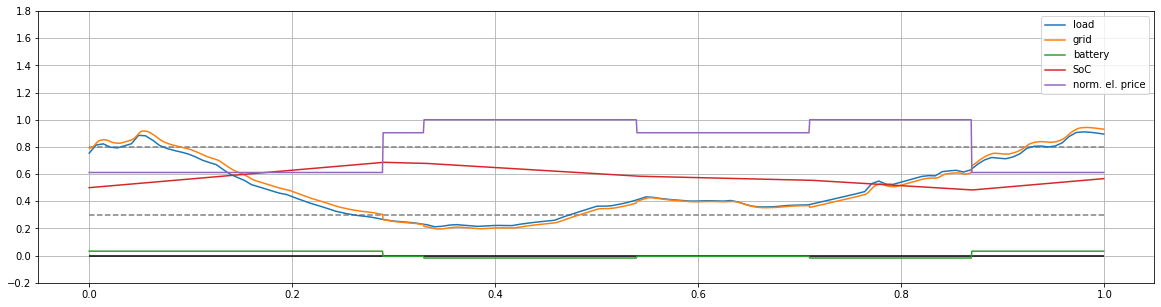

((0.16677993193060311,
  0.5904845947210353,
  -0.0032715314457994003,
  -0.3947997385684039,
  -0.4597531918834852),
 16.277626065090764,
 55.34859234348764,
 48.277626065090764)

In [73]:
%matplotlib
d=0
S_os_max=0
# cst_sum=Z[d,:,:,:-1].mean(axis=2)
cst_sum=Z[d,:,:,3]+100*Z[d,:,:,2]
Q_=np.power(Q[:,:,:,1],1)

fig = plt.figure()
ax = plt.axes(projection='3d')


# ax.plot_wireframe(X.transpose(), Y.transpose() ,cst_sum[k], color='red')
ax.plot_surface(X.transpose(), Y.transpose() ,cst_sum,cmap='viridis',alpha=0.5 )    
ax.contour3D(X.transpose(), Y.transpose() ,Q_[d],100 )
ax.set_xlabel('par1')
ax.set_ylabel('par2')
ax.set_zlabel('performance/cost')   
plt.show()
optcst=cst_sum.max()
optpar=[par1[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[0]],par2[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[1]]]

# print(optpar,optcst)


max_idx=cst_sum[Q_[d,:]>=-S_os_max].argmax()
opt_par=X.transpose()[Q_[d,:]>=-S_os_max][max_idx],Y.transpose()[Q_[d,:]>=-S_os_max][max_idx]
print('best constrained par= ',opt_par[:])
opt_cost=cst_sum[Q_[d,:]>=-S_os_max].max()
print('best constrained performance= ',opt_cost)
print('best par=',optpar)
print('best performance= ',optcst)
# print('mean cost= ',cst_sum.mean())

plant_cost(opt_par,p_load=data.power_load.values[d*day:],plot=True,noise=False)


#### Design cost, all days

In [219]:
days=Z.shape[0]
# print('best day=',np.unravel_index(cst_sum.argmax(), cst_sum.shape)[0])
# print('best par=',par1[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[1]],
#       par2[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[2]])
optpar=np.zeros((days,2))
optcst=np.zeros(days)
%matplotlib

for d in range(days):
    S_os_max=0
    # cst_sum=Z[d,:,:,:-1].mean(axis=2)
    cst_sum=Z[d,:,:,3]+Z[d,:,:,1]
    Q_=np.power(Q[:,:,:,2]/40,1)


    # cst_sum2=+Z[:,:,:,-1]
    # print('best par=',par1[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[0]],par2[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[1]])
    optpar=np.zeros((d,2))
    optcst=np.zeros(d)

    fig = plt.figure()
    ax = plt.axes(projection='3d')


    #     ax.plot_wireframe(X.transpose(), Y.transpose() ,cst_sum[k], color='red')
#     ax.plot_surface(X.transpose(), Y.transpose() ,cst_sum,cmap='viridis',alpha=0.7 )    
    ax.contour3D(X.transpose(), Y.transpose() ,Q_[d]/10,10 )
    ax.set_xlabel('par1')
    ax.set_ylabel('par2')
    ax.set_zlabel('performance/cost')   
    plt.show()
    
    optcst=cst_sum.max()
    optpar=[par1[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[0]],par2[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[1]]]

    # print(optpar,optcst)

    max_idx=cst_sum[Q_[d,:]>=-S_os_max].argmax()
    opt_par=X.transpose()[Q_[d,:]>=-S_os_max][max_idx],Y.transpose()[Q_[d,:]>=-S_os_max][max_idx]
    print('best constrained par= ',opt_par[:])
    opt_cost=cst_sum[Q_[d,:]>=-S_os_max].max()
    print('best constrained performance= ',opt_cost)
    print('best par=',optpar)
    print('best performance= ',optcst,end='\n')
    # print('mean cost= ',cst_sum.mean())

#     plant_cost(opt_par,p_load=data.power_load.values[d*day:],plot=True,noise=False)

Using matplotlib backend: MacOSX
best constrained par=  (0.5306122448979591, -0.34693877551020413)
best constrained performance=  -1.0662822379599781
best par= [0.5306122448979591, -0.34693877551020413]
best performance=  -1.0662822379599781
best constrained par=  (0.4897959183673469, -0.26530612244897966)
best constrained performance=  -0.3915578517607218
best par= [0.4897959183673469, -0.26530612244897966]
best performance=  -0.3915578517607218
best constrained par=  (0.5306122448979591, -0.34693877551020413)
best constrained performance=  -0.9826170859560901
best par= [0.5306122448979591, -0.34693877551020413]
best performance=  -0.9826170859560901
best constrained par=  (0.5306122448979591, -0.34693877551020413)
best constrained performance=  -1.0486920792867465
best par= [0.5306122448979591, -0.34693877551020413]
best performance=  -1.0486920792867465
best constrained par=  (0.5306122448979591, -0.34693877551020413)
best constrained performance=  -1.0486920792867465
best par= [0.5

#### Mean design cost and constrain

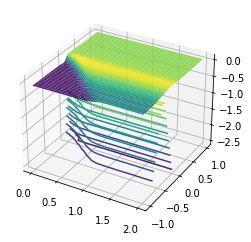

In [97]:
fig = plt.figure()
ax = plt.axes(projection='3d')
cst_mean=Z[:,:,:,3].mean(axis=0)
Q_mean=Q[:,:,:,1].mean(axis=0)/10
ax.plot_surface(X.transpose(), Y.transpose() ,cst_mean, cmap='viridis')
ax.contour3D(X.transpose(), Y.transpose() ,Q_mean,10)

plt.show()

### Performance + constrain 1day contour

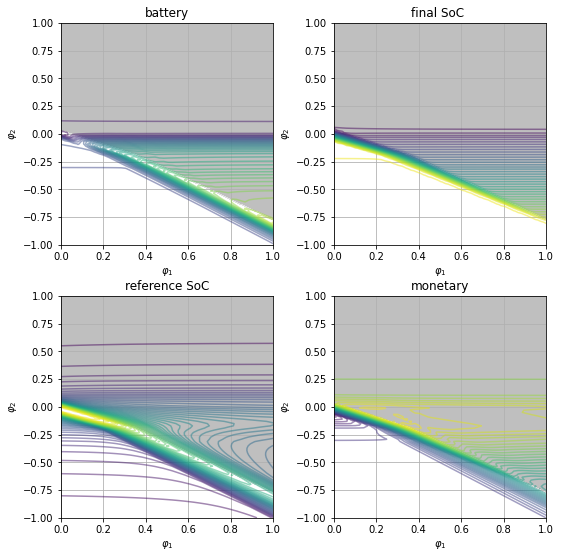

In [31]:
%matplotlib inline
fig, ax = plt.subplots(2,2,figsize=(8,8))
fig.tight_layout(pad=3)
# c0=ax[0,0].contour(X.transpose(), Y.transpose() ,Z[0,:,:,-1],50,alpha=0.8)
# c1=ax[0,1].contour(X.transpose(), Y.transpose() ,Z[0,:,:,1],50,alpha=0.8)
# c2=ax[1,0].contour(X.transpose(), Y.transpose() ,Z[0,:,:,3],50,alpha=0.8)
# c3=ax[1,1].contour(X.transpose(), Y.transpose() ,Z[0,:,:,2],50,alpha=0.8)
cost_list=['r_ps','r_b','g_sf','g_b','g_sr','g_g','r_price','r_money']
cost_list_=['battery','final SoC ','reference SoC','monetary']
Z_=Z[0,:,:,:-1]
Q_=Q[0,:,:,1]
Q__=Q[0,:,:,0]
for i,axis in enumerate(ax.flatten()):
    axis.contour(X.transpose(), Y.transpose() ,Z_[:,:,i],50,alpha=0.5)
#     axis.contourf(X.transpose(), Y.transpose() ,Q_[:,:],levels=[-np.inf,-0,np.inf],colors=['black','white'],linestyles='-',alpha=0.5)
    axis.contourf(X.transpose(), Y.transpose() ,Q__[:,:],levels=[-np.inf,-0,np.inf],colors=['grey','white'],linestyles='-',alpha=0.5)
    axis.set_xlabel(r'$\varphi_1$')
    axis.set_ylabel(r'$\varphi_2$')
    axis.set_title(cost_list_[i])
    axis.set_xlim([0,1])
#     fig.colorbar(c0,ax=axis,format='%.2f')

plt.show()

# h=colorbar('location','southoutside');
# yt=get(h,'XTick');
# set(h,'XTickLabel',sprintf('%2.4f|',yt));

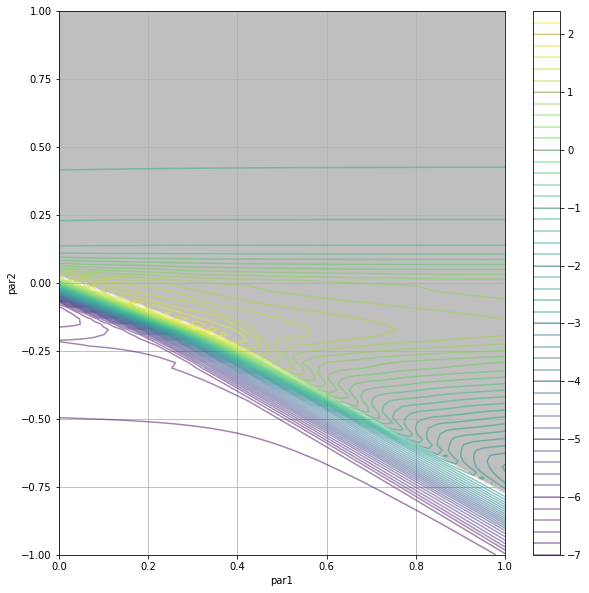

In [36]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
cst=1*Z[0,:,:,3]+20*Z[0,:,:,2]
cont=ax.contour(X.transpose(), Y.transpose(), cst,50,alpha=0.5)
# ax.contourf(X.transpose(), Y.transpose() ,Q_[:,:],levels=[-np.inf,-0,np.inf],colors=['black','white'],linestyles='-',alpha=0.5)
ax.contourf(X.transpose(), Y.transpose() ,Q__[:,:],levels=[-np.inf,-0,np.inf],colors=['grey','white'],linestyles='-',alpha=0.5)
ax.set_xlim([0,1])
plt.colorbar(cont)
# plt.plot(a[0],a[1],'x')
ax.set_xlabel('par1')
ax.set_ylabel('par2')
plt.show()

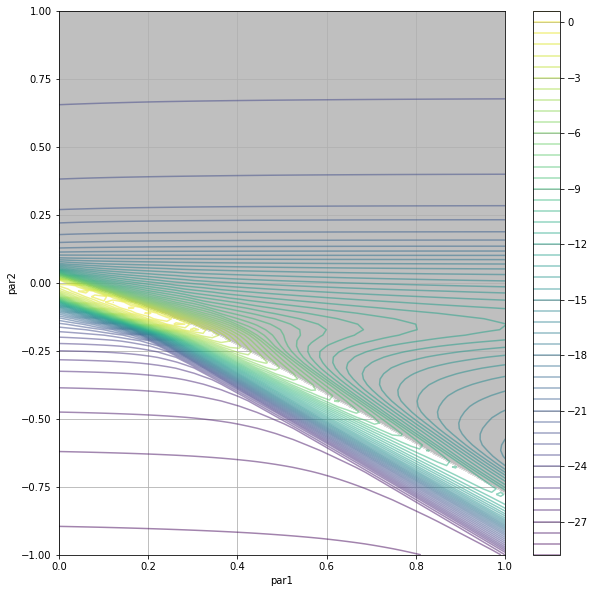

In [47]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
cst=1*Z[0,:,:,3]+200*Z[0,:,:,2]
cont=ax.contour(X.transpose(), Y.transpose(), cst,50,alpha=0.5)
# ax.contourf(X.transpose(), Y.transpose() ,Q_[:,:],levels=[-np.inf,-0,np.inf],colors=['black','white'],linestyles='-',alpha=0.5)
ax.contourf(X.transpose(), Y.transpose() ,Q__[:,:],levels=[-np.inf,-0,np.inf],colors=['grey','white'],linestyles='-',alpha=0.5)
ax.set_xlim([0,1])
plt.colorbar(cont)
# plt.plot(a[0],a[1],'x')
ax.set_xlabel('par1')
ax.set_ylabel('par2')
plt.show()

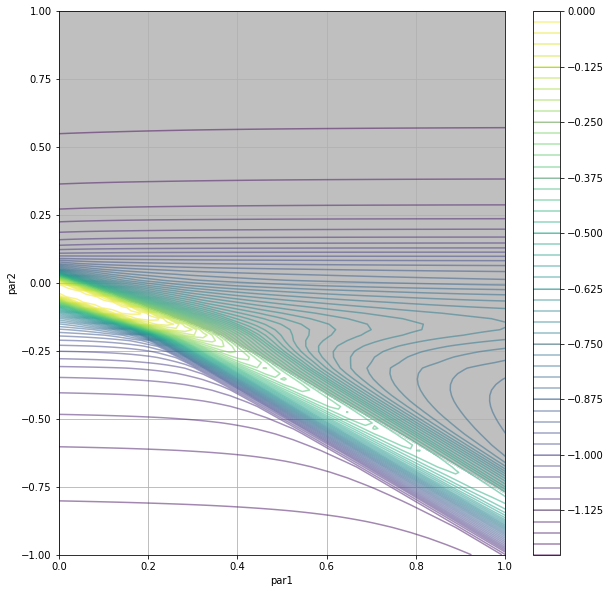

In [34]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
cst=0*Z[0,:,:,3]+10*Z[0,:,:,2]
cont=ax.contour(X.transpose(), Y.transpose(), cst,50,alpha=0.5)
# ax.contourf(X.transpose(), Y.transpose() ,Q_[:,:],levels=[-np.inf,-0,np.inf],colors=['black','white'],linestyles='-',alpha=0.5)
ax.contourf(X.transpose(), Y.transpose() ,Q__[:,:],levels=[-np.inf,-0,np.inf],colors=['grey','white'],linestyles='-',alpha=0.5)
ax.set_xlim([0,1])
plt.colorbar(cont)
# plt.plot(a[0],a[1],'x')
ax.set_xlabel('par1')
ax.set_ylabel('par2')
plt.show()

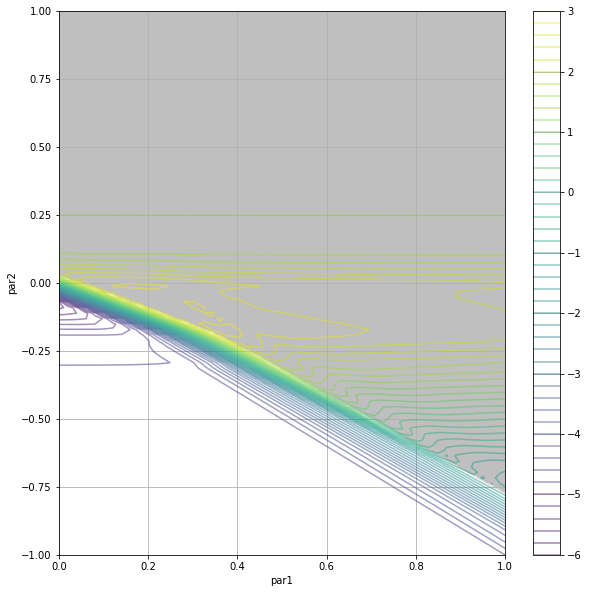

In [35]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
cst=1*Z[0,:,:,3]+0*Z[0,:,:,2]
cont=ax.contour(X.transpose(), Y.transpose(), cst,50,alpha=0.5)
# ax.contourf(X.transpose(), Y.transpose() ,Q_[:,:],levels=[-np.inf,-0,np.inf],colors=['black','white'],linestyles='-',alpha=0.5)
ax.contourf(X.transpose(), Y.transpose() ,Q__[:,:],levels=[-np.inf,-0,np.inf],colors=['grey','white'],linestyles='-',alpha=0.5)
ax.set_xlim([0,1])
plt.colorbar(cont)
# plt.plot(a[0],a[1],'x')
ax.set_xlabel('par1')
ax.set_ylabel('par2')
plt.show()

## Fit to GP

In [ ]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Const
cst_mean=Z[:,:,:,3].mean(axis=0)
Q_mean=Q[:,:,:,1].mean(axis=0)
X = np.array(list(product(par1,par2)))

y =cst_mean.flatten()
print(X.shape,y.shape)

kernel = Const(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp.fit(X, y)
print(gp.kernel_)
y=Q_mean.flatten()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp.fit(X, y)
print(gp.kernel_)


(2500, 2) (2500,)


## Contextual fit to GP

In [80]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel ,WhiteKernel,Matern
# data=data_prepocess(winter)
# Z=get_data('data/summer_c_3_1_2/cost_2022_02_27_0526.npy')
# Q=get_data('data/summer_c_3_1_2/constraint_2022_02_27_0526.npy')
# par1,par2=get_data('data/summer_c_3_1_2/meta_2022_02_27_0526.npy')
# Z=get_data('data/winter_c_3_1_2/cost_2022_03_03_0506.npy')
# Q=get_data('data/winter_c_3_1_2/constraint_2022_03_03_0506.npy')
# par1,par2=get_data('data/winter_c_3_1_2/meta_2022_03_03_0506.npy')

data=get_data('model_data/model_winter_data_2022_03_15_0131.csv',npy=False)
data=data.set_index(pd.to_datetime(data.index))
# Model data
Z=get_data('data/winter_c_3_1_2/cost_2022_03_20_0937.npy')
Q=get_data('data/winter_c_3_1_2/constraint_2022_03_20_0937.npy')
par1,par2=get_data('data/winter_c_3_1_2/meta_2022_03_20_0937.npy')
Z=get_data('data/winter_c_3_1_2/cost_2022_03_20_0231.npy')
Q=get_data('data/winter_c_3_1_2/constraint_2022_03_20_0231.npy')
par1,par2=get_data('data/winter_c_3_1_2/meta_2022_03_20_0231.npy')

print(Q.shape)


# rss_df=data.Rss_day.asfreq('D').shift(-2) # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
e_ch=data.e_char.asfreq('D').shift(-2)
e_dis=data.e_dis.asfreq('D').shift(-2)
context=e_ch[:len(Q)]

(30, 50, 50, 7)


### RBF

In [2]:
p=0.005
y=Z[:,:,:,3].flatten()+Z[:,:,:,2].flatten()
X = np.array(list(product(context,par1,par2)))
print(X.shape)
samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]

print(X_.shape,y_.shape)

kernel = ConstantKernel(0.05, (1e-3, 5e1)) * RBF([0.1,0.1,0.1], (1e-3, 2e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 5))
gp_cost = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_cost.fit(X_, y_)
print(gp_cost.kernel_)

# y=(Q[:,:,:,1].flatten()-55)/soc_std
# X = np.array(list(product(context,par1,par2)))
# print(X.shape)
# samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
# y_=y[samples]
# X_=X[samples,:]

# print(X_.shape,y_.shape)

# kernel = ConstantKernel(10, (1e-3, 50e1)) * RBF([0.1,0.1,0.1], (1e-3, 2e1))+WhiteKernel(
#     noise_level=1e-2, noise_level_bounds=(1e-8, 2e1))
# gp_const = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
# gp_const.fit(X_, y_)
# print(gp_const.kernel_)

# y=(Q[:,:,:,2].flatten()-40)/soc_std
# X = np.array(list(product(context,par1,par2)))
# print(X.shape)
# samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
# y_=y[samples]
# X_=X[samples,:]

# print(X_.shape,y_.shape)

# kernel = ConstantKernel(10, (1e-3, 50e1)) * RBF([0.1,0.1,0.1], (1e-3, 5e1))+WhiteKernel(
#     noise_level=1e-2, noise_level_bounds=(1e-8, 1e1))
# gp_const2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
# gp_const2.fit(X_, y_)
# print(gp_const2.kernel_)

NameError: name 'Z' is not defined

### Matern

In [74]:
p=0.002
y=Z[:,:,:,3].flatten()#+20*Z[:,:,:,4].flatten()
X = np.array(list(product(context,par1,par2)))
print(X.shape)
samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]

print(X_.shape,y_.shape)

kernel = ConstantKernel(0.05, (1e-3, 5e1)) * Matern([0.1,0.1,0.1], (1e-3, 5e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 5))
gp_cost = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp_cost.fit(X_, y_)
print(gp_cost.kernel_)

y=(Q[:,:,:,1].flatten()-50)/soc_std
X = np.array(list(product(context,par1,par2)))
print(X.shape)
samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]

print(X_.shape,y_.shape)

kernel = ConstantKernel(10, (1e-3, 50e1)) * Matern([0.1,0.1,0.1], (1e-3, 5e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 2e1))
gp_const = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp_const.fit(X_, y_)
print(gp_const.kernel_)

y=(Q[:,:,:,2].flatten()-50)/soc_std
X = np.array(list(product(context,par1,par2)))

samples=np.random.choice([True,False],size=len(y),p=[p,1-p])
y_=y[samples]
X_=X[samples,:]



kernel = ConstantKernel(10, (1e-3, 50e1)) * Matern([0.1,0.1,0.1], (1e-3, 10e1))+WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-8, 1e1))
gp_const2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
gp_const2.fit(X_, y_)
print(gp_const2.kernel_)

(75000, 3)
(687, 3) (687,)
4.9**2 * Matern(length_scale=[1.06, 1.28, 0.698], nu=1.5) + WhiteKernel(noise_level=0.1)
(75000, 3)
(660, 3) (660,)
0.291**2 * Matern(length_scale=[0.309, 0.682, 0.478], nu=1.5) + WhiteKernel(noise_level=1.84e-05)
0.263**2 * Matern(length_scale=[0.779, 0.425, 0.472], nu=1.5) + WhiteKernel(noise_level=2.43e-07)


# 1D-Grid search cost function

In [148]:
N_samples=50
x=np.linspace(0,2,N_samples)
days=20
cost_list=['r_ps','r_b','r_ss','g_sf','g_b','g_sr','g_g','r_price']
n_costs=len(cost([0,0],data=data.power_load))
# y=np.linspace(-2,0.01,N_samples)
Z=np.zeros((days,len(x),n_costs))
Q=np.zeros((days,len(x)))

In [ ]:
for k in tqdm.trange(days):
    for i,x_ in enumerate(x):
    #     print(i,x_)
        Z[k,i,:] = cost([x_,2],data=data.power_load[k*day//dt:])
        Q[k,i]=constrain([x_,2],data=data.power_load[k*day//dt:])

 10%|████▍                                       | 2/20 [00:44<06:38, 22.16s/it]

name='summer_c_bgbg_ps__all'
save_data(Z,f'data/cost_{name}')

(20, 50, 7)
best day= 3
best par= 0.0
r_ps


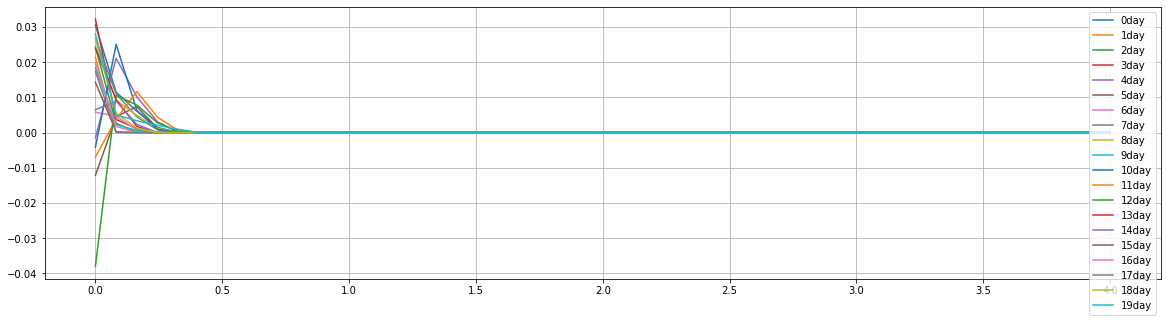

0.03265306122448979 0.0 0.05414897616906775
0.019927493690943775 0.02124907131255048 0.0076886149641802026


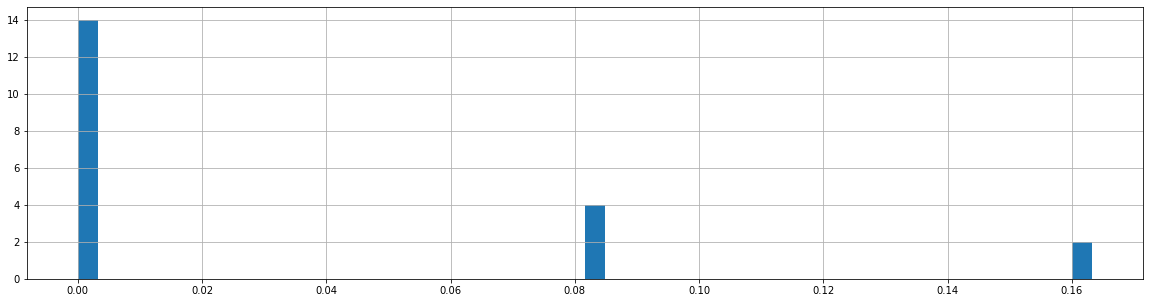

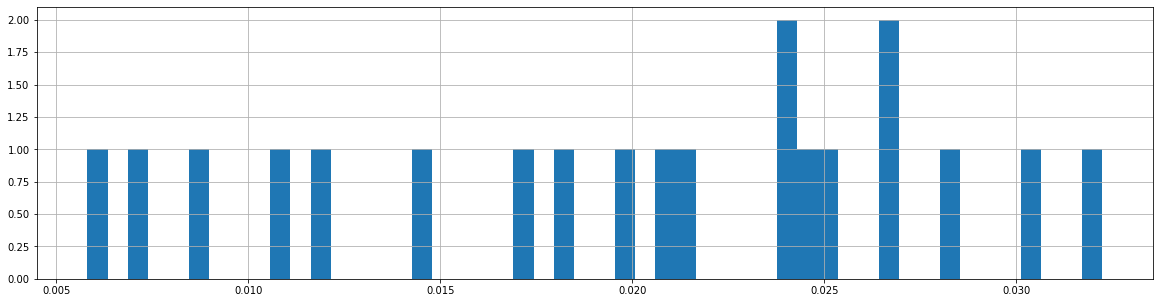

best day= 10
best par= 0.08163265306122448
r_b


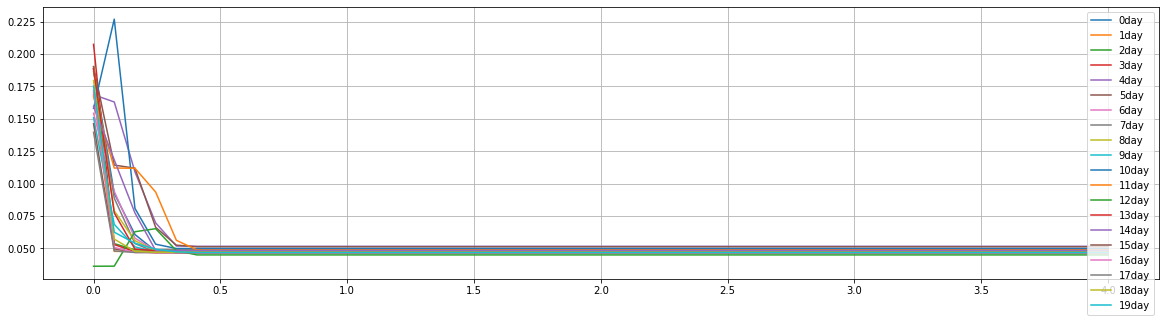

0.016326530612244896 0.0 0.05536595904592056
0.17071875277139079 0.17350701186463008 0.03168954067660587


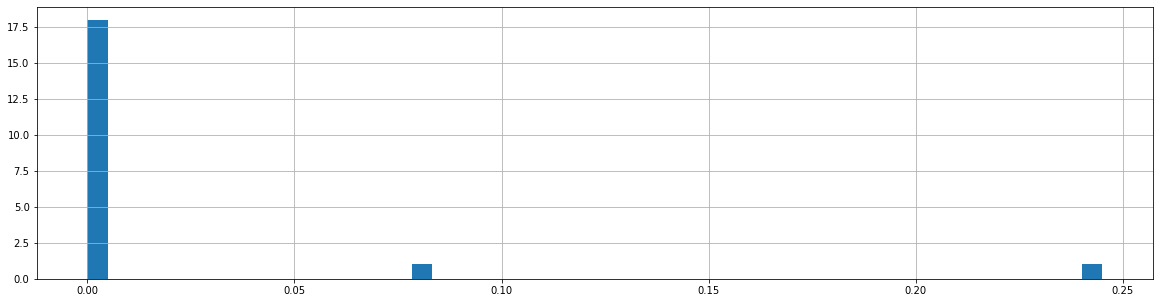

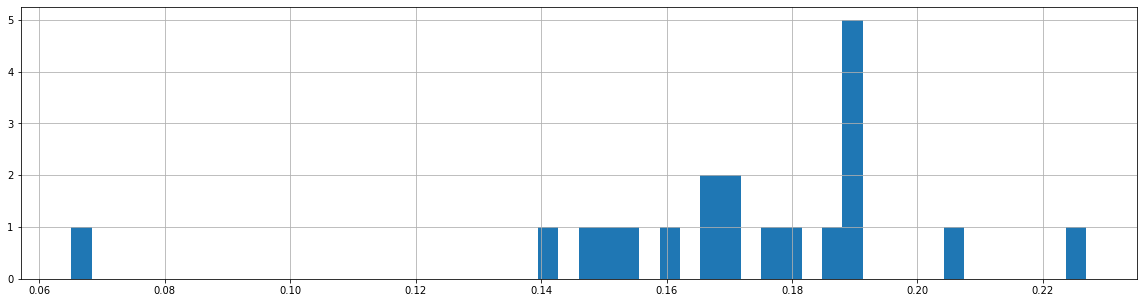

best day= 4
best par= 0.0
r_ss


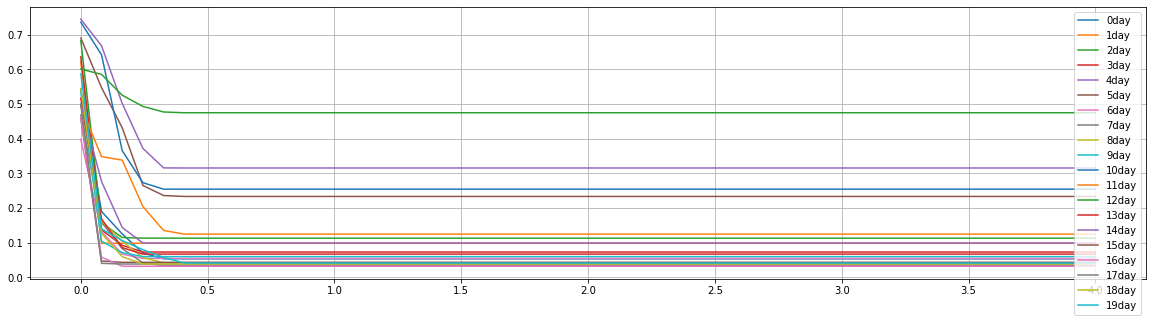

0.0 0.0 0.0
0.5604266247118586 0.5376680638653621 0.09554469839332602


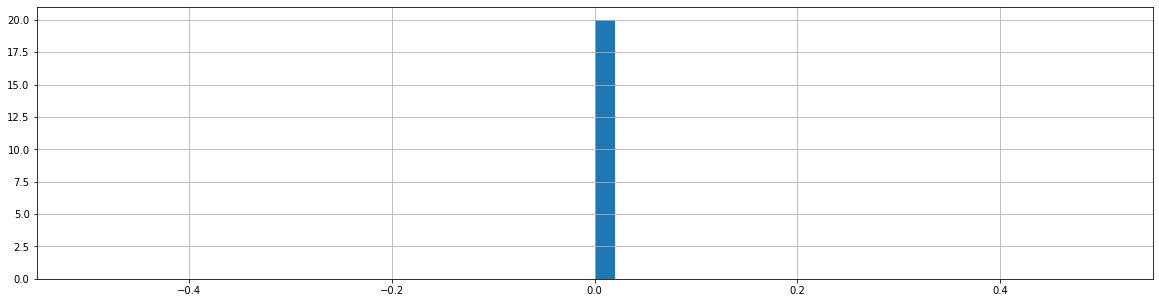

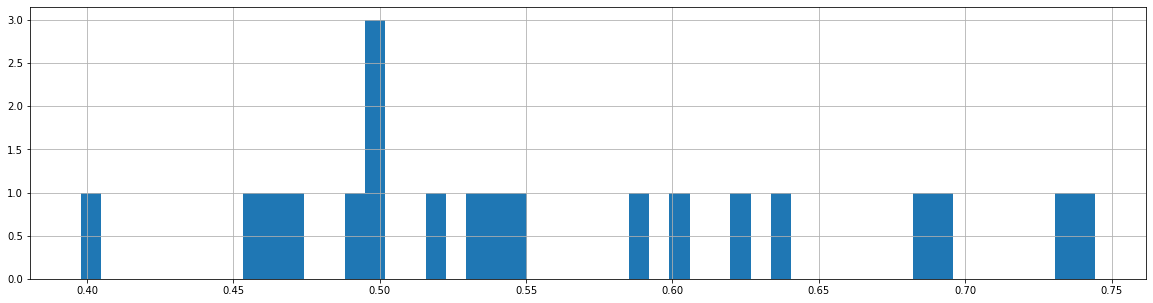

best day= 6
best par= 0.0
g_sf


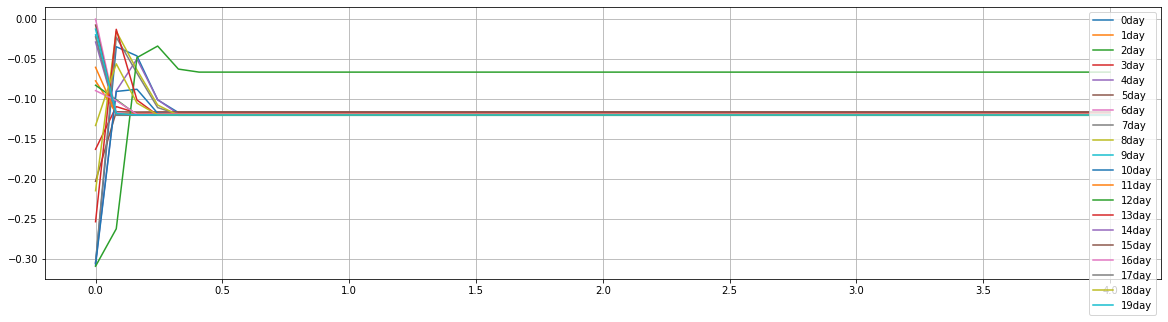

0.05714285714285714 0.04081632653061224 0.0687848961075621
-0.04723674784065424 -0.034435894700380915 0.03484203667710491


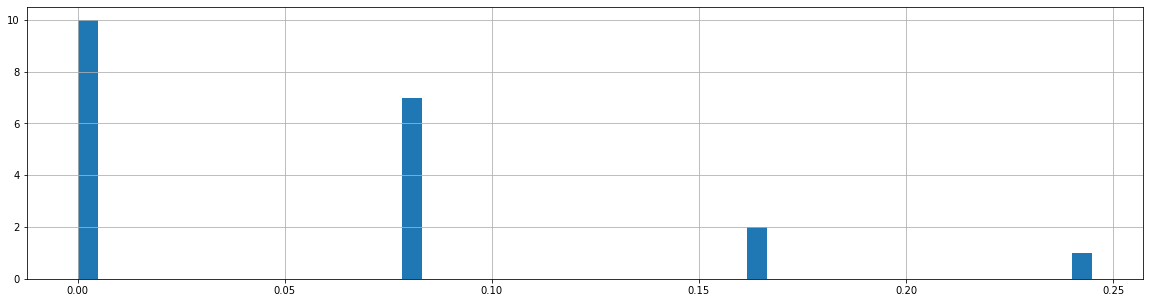

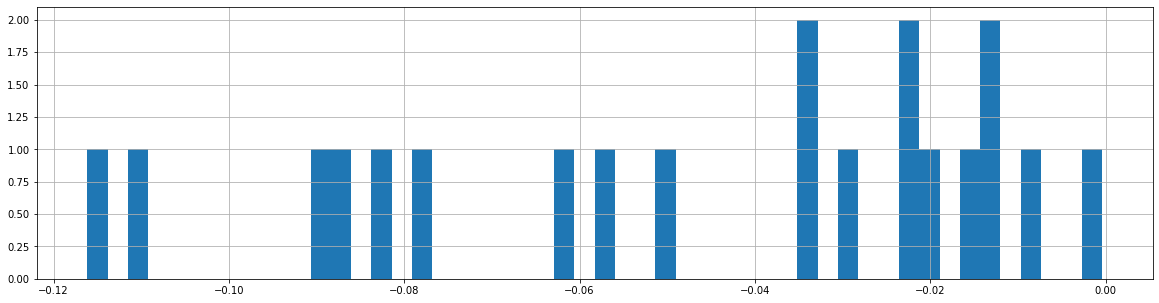

best day= 13
best par= 0.08163265306122448
g_b


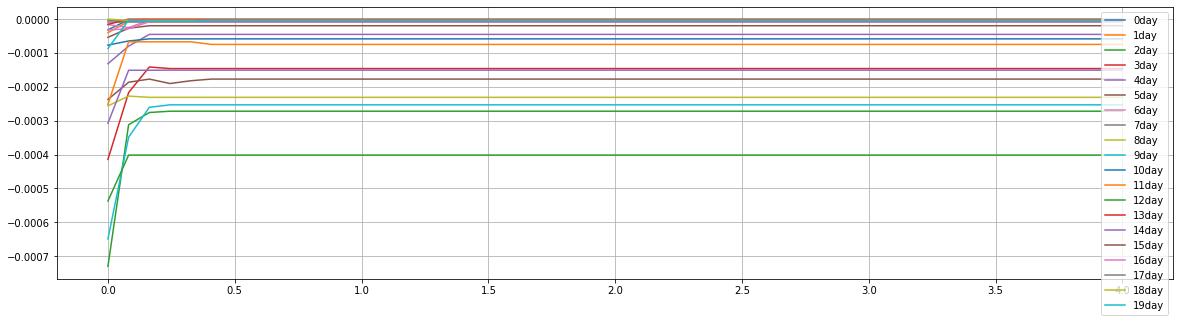

0.12244897959183673 0.12244897959183673 0.07526158740647255
-9.2408348865394e-05 -3.222785340390041e-05 0.00011497255711889482


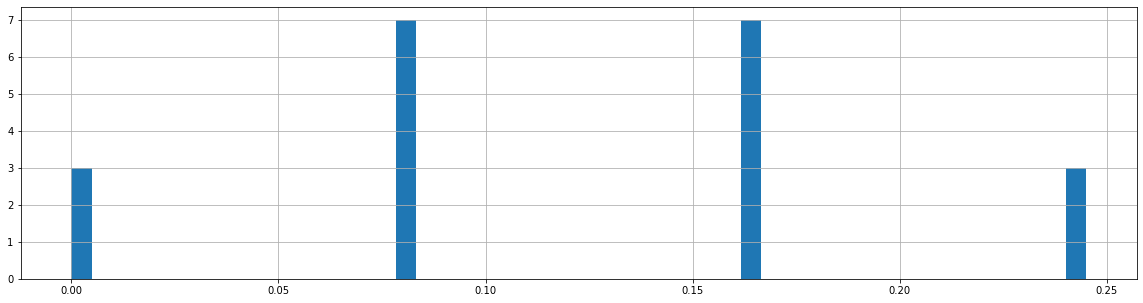

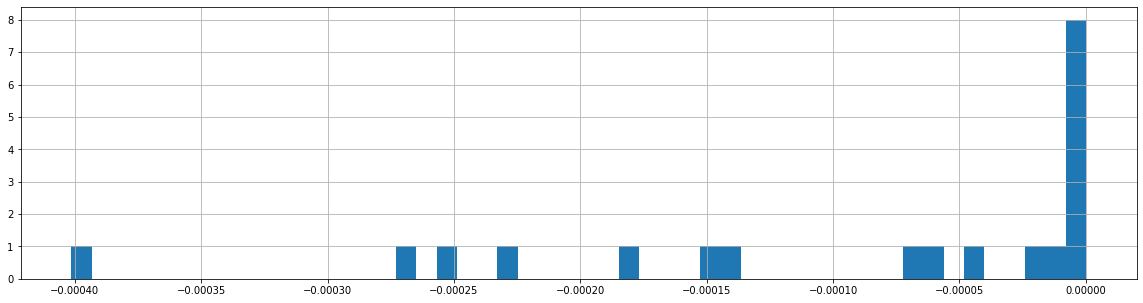

best day= 12
best par= 0.24489795918367346
g_sr


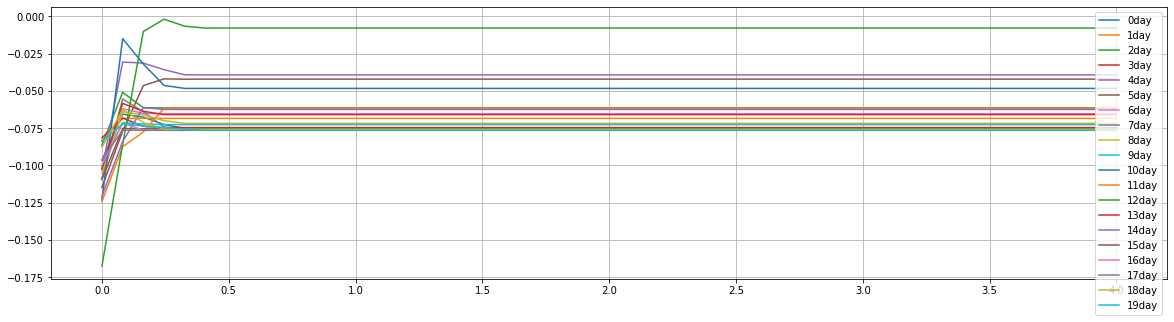

0.11428571428571428 0.08163265306122448 0.07022306340442962
-0.056704950326062695 -0.06229285936950267 0.019494238832660177


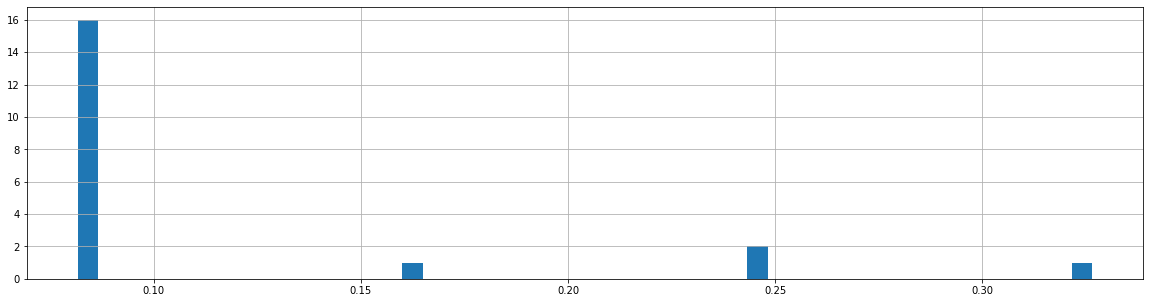

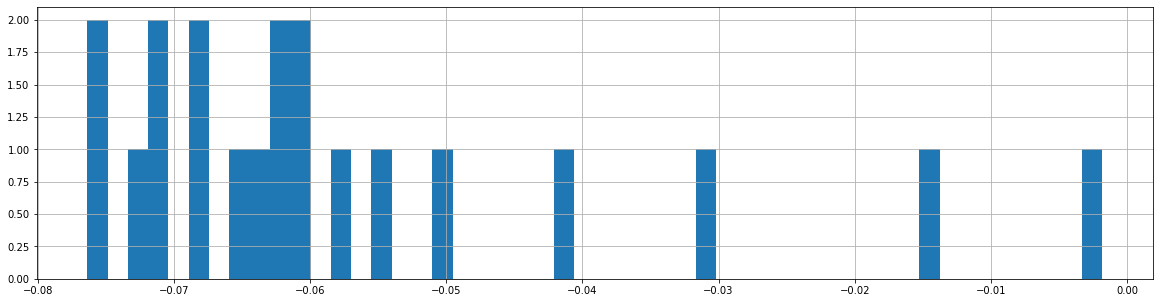

best day= 12
best par= 0.4081632653061224
g_g


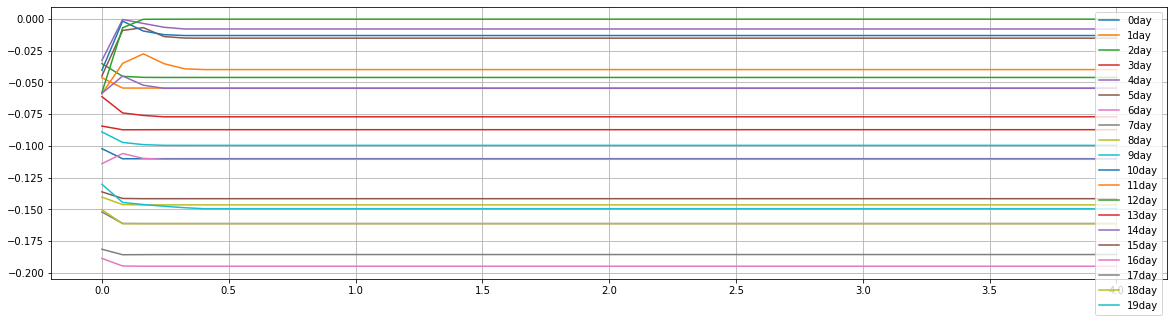

0.05306122448979591 0.0 0.09753308690080423
-0.08431221510796572 -0.08674160935925579 0.06088781263284738


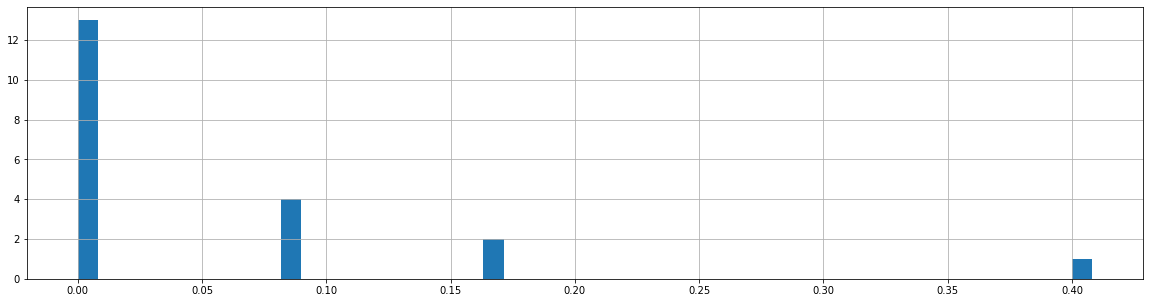

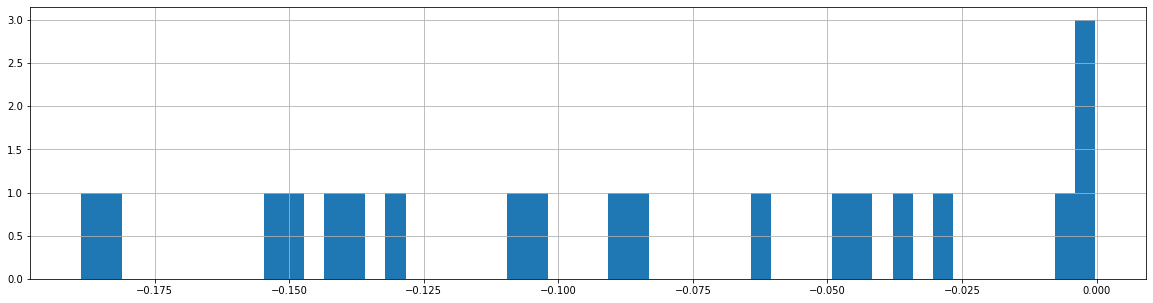

In [123]:
Z=np.load('data/cost_summer_c_bgbg_ps__all.npy')
print(Z.shape)
optcst=np.zeros((Z.shape[0],Z.shape[-1]))
optpar=np.zeros((Z.shape[0],Z.shape[-1]))
cost_list=['r_ps','r_b','r_ss','g_sf','g_b','g_sr','g_g']

for nc in range(7):
    cst=Z[:,:,nc]
    print('best day=',np.unravel_index(cst.argmax(), cst.shape)[0])
    print('best par=',x[np.unravel_index(cst.argmax(), cst.shape)[1]])
    print(cost_list[nc])
    for k in range(days):
        plt.plot(x,cst[k,:],label=f'{k}day')
        optcst[k,nc]=max(cst[k,:])
        optpar[k,nc]=x[cst[k,:].argmax()]
    plt.legend()  
    plt.show()
    # plt.savefig(f'figs/cost_{name}')
    print(optpar[:,nc].mean(),np.median(optpar[:,nc]),optpar[:,nc].std())
    print(optcst[:,nc].mean(),np.median(optcst[:,nc]),optcst[:,nc].std())
    # save_data(optpar,f'data/optpar_{name}')
    _=plt.hist(optpar[:,nc],bins=50)
    plt.show()
    _=plt.hist(optcst[:,nc],bins=50)
    plt.show()


best day= 12
best par= 0.12244897959183673


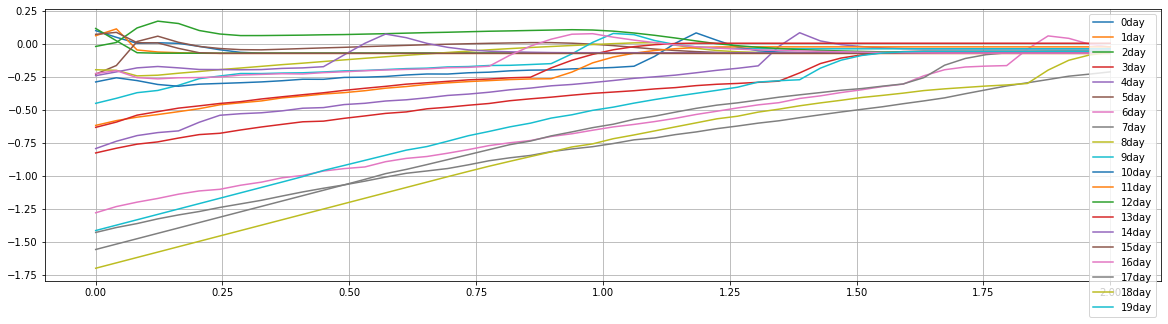

1.0061224489795917 1.1428571428571428 0.7186774608923456
0.033231654984475015 0.06781950104203319 0.08669172935154411


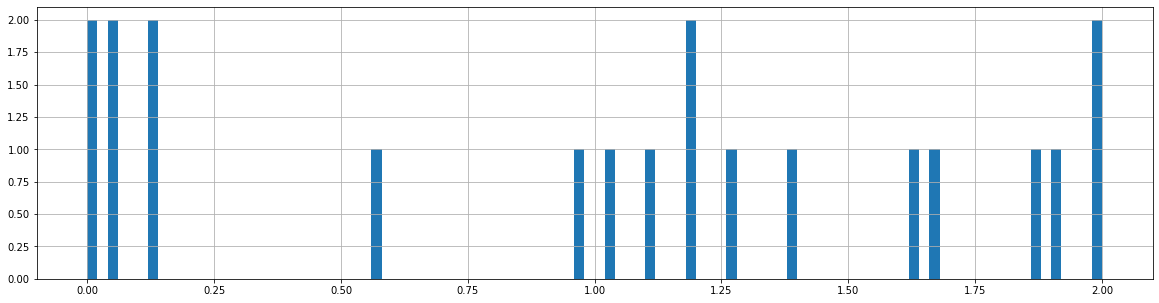

In [40]:
cst_sum=Z[:,:,0]+Z[:,:,1]+Z[:,:,3]
print('best day=',np.unravel_index(cst_sum.argmax(), cst_sum.shape)[0])
print('best par=',x[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[1]])
optpar=np.zeros(days)
optcst=np.zeros(days)

for k in range(days):
    plt.plot(x,cst_sum[k,:],label=f'{k}day')
    optpar[k]=x[cst_sum[k,:].argmax()]
    optcst[k]=max(cst_sum[k,:])
   
plt.legend()  
plt.show()
# plt.savefig(f'figs/cost_{name}')
print(optpar.mean(),np.median(optpar),optpar.std())
print(optcst[:].mean(),np.median(optcst[:]),optcst[:].std())

# save_data(optpar,f'data/optpar_{name}')
_=plt.hist(optpar,bins=100)
plt.show()

## Fit to GP

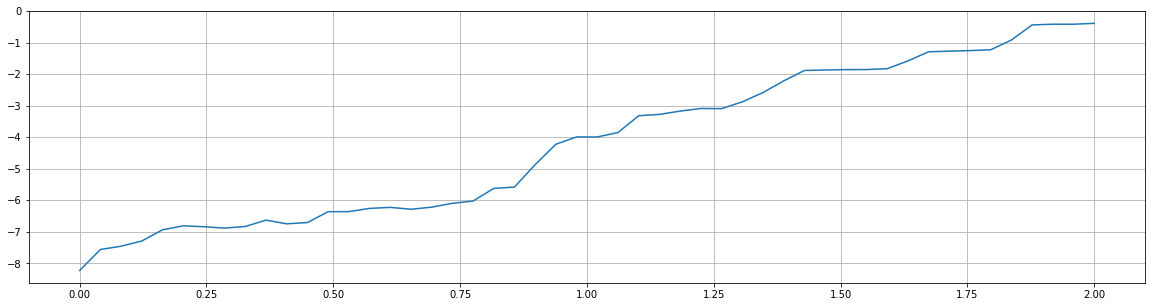

In [41]:
plt.plot(x,Q.mean(axis=0))

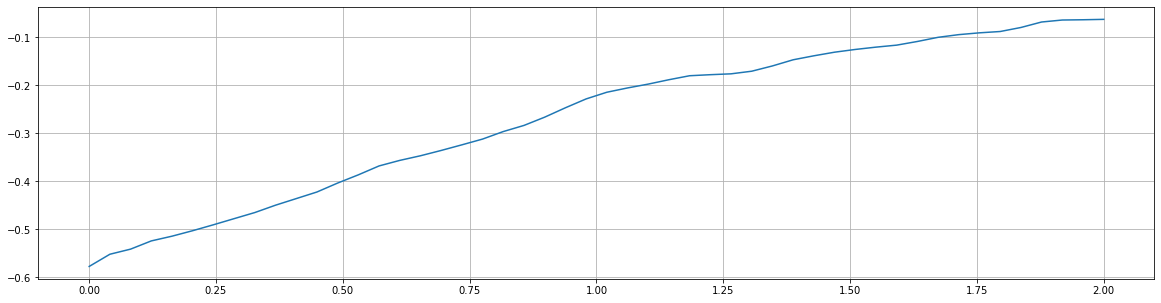

In [42]:
plt.plot(x,cst_sum.mean(axis=0))

In [47]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(x[None,:], cst_sum.mean(axis=0)[None,:])
gaussian_process.kernel_


0.0589**2 * RBF(length_scale=0.0163)

In [56]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(x[None,:], Q.mean(axis=0)[None,:])
gaussian_process.kernel_


5.07**2 * RBF(length_scale=0.651)

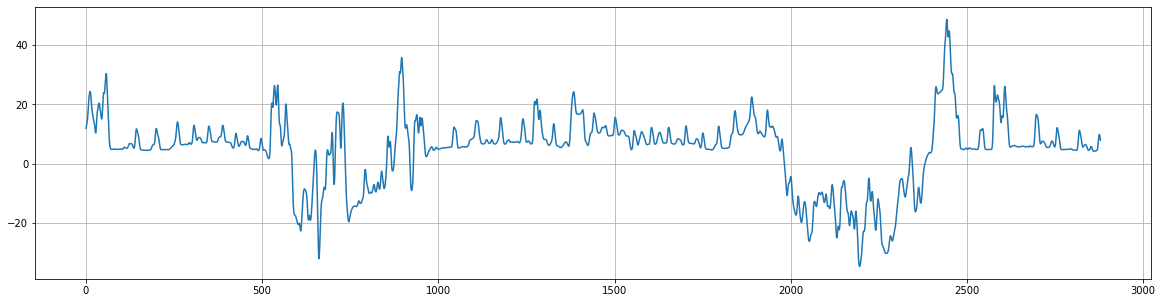

In [15]:

data=data_prepocess(winter,rss_bounds=[0.1,0.3])
plt.plot(data.power_load.values)
# data=data_prepocess(spring,rss_bounds=[0.4,0.6])
# plt.plot(data.power_load.values)

# 3D-Grid search cost function

In [81]:
def cost(x,data):
    return np.array(plant_cost(x,T=1,p_load=data,N_lim=[15,day],soc_lim=[25,75],soc_ref=50,soc_i=50,phib=phib,noise=True)[0])
def constrain(x,data):
    return plant_cost(x,T=1,p_load=data,N_lim=[15,day],soc_lim=[25,75],soc_ref=50,soc_i=50,phib=phib,noise=True)[1]

N_samples=10
days=1
n_costs=len(cost([0,0,0],data=data.power_load.values))
par1=np.linspace(0,6,N_samples)
par2=np.linspace(1,10,N_samples)
par3=[0,1]
Z=np.zeros((days,len(par1),len(par2),len(par3),n_costs))
Q=np.zeros((days,len(par1),len(par2),len(par3)))
stat=0

for d in range(days):
    for i,x_ in enumerate(par1):
        for j,y_ in enumerate(par2):
            for k,r_ in enumerate(par3):
                print(f'{stat/days/len(par1)/len(par2)/len(par3)*100:.3f}','%',end='\r')
    #                 print(len(cost.send([x_,y_,z_])[0]))
                Z[d,i,j,k,:] =cost([x_,y_,r_],data=data.power_load[d*day//dt:])
                Q[d,i,j,k] = constrain([x_,y_,r_],data=data.power_load[d*day//dt:])
                stat=stat+1

In [ ]:
name='winter_c_3_2'
datafolder=os.path.join('data',name)
meta=np.array([par1,par2])
save_data(meta,'meta',folder=datafolder)
save_data(Z,'cost',folder=datafolder)
save_data(Q,'constraint',folder=datafolder)

### Performance + constrain 1day contour

####  Get data

In [69]:
Z=get_data('data/winter_c_3_2/cost_2022_02_06_0504.npy')
Q=get_data('data/winter_c_3_2/constraint_2022_02_06_0504.npy')
par1,par2=get_data('data/winter_c_3_2/meta_2022_02_06_0504.npy')
print(Z.shape)

(1, 50, 50, 2, 5)


In [100]:
days=Q.shape[0]
n_costs=Z.shape[-1]
optcst=np.zeros((days,n_costs))
optpar=np.zeros((days,n_costs,2))
cost_list=['r_b','g_sf','g_sr','r_money','r_ps']
X,Y=np.meshgrid(par1,par2)

# cost_list=['r_ps','r_b','r_ss','g_sf','g_b','g_sr','g_g','r_price','r_money']

#### Design cost, one day

In [102]:
d=0
rst=1
# Z=Z[:,:,1:,:,:]
# Q=Q[:,:,1:,:]
Z_=Z[d,:,:,rst,:]
Q_=Q[d,:,:,rst]
cst_sum=(0*Z_[:,:,0]+0*Z_[:,:,1]+1*Z_[:,:,2]+Z_[:,:,3])


# cst_sum2=+Z[:,:,:,-1]
print('best par=',par1[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[0]],par2[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[1]])
optpar=np.zeros((d,2))
optcst=np.zeros(d)

%matplotlib
fig = plt.figure()
ax = plt.axes(projection='3d')


#     ax.plot_wireframe(X.transpose(), Y.transpose() ,cst_sum[k], color='red')
# ax.plot_surface(X.transpose(), Y.transpose() ,cst_sum,cmap='viridis',alpha=0.3 )    
# ax.contour3D(X.transpose(), Y.transpose() ,Q_, 10)

optcst=cst_sum.max()
optpar=[par1[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[0]],par2[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[1]]]
ax.set_xlabel('par1')
ax.set_ylabel('par2')
ax.set_zlabel('performance/cost')   
plt.show()
print(optpar,optcst)
# plt.savefig(f'figs/cost_{name}')
# print(optpar[:,0].mean(),np.median(optpar[:,0]),optpar[:,0].std())
# print(optpar[:,1].mean(),np.median(optpar[:,1]),optpar[:,1].std())
# print(optcst[:].mean(),np.median(optcst[:]),optcst[:].std())

# save_data(optpar,f'data/optpar_{name}')
# %matplotlib inline
# _=plt.hist(optpar[:,0],bins=50)
# plt.show()
# _=plt.hist(optpar[:,1],bins=50)
# plt.show()
# _=plt.hist(optcst[:],bins=50)
# plt.show()

best par= 0.6666666666666666 3.0
Using matplotlib backend: MacOSX
[0.6666666666666666, 3.0] 0.09486707748024248


In [103]:
S_os_max=1
max_idx=cst_sum[Q_[:]>=-S_os_max].argmax()
opt_par=X.transpose()[Q_[:]>=-S_os_max][max_idx],Y.transpose()[Q_[:]>=-S_os_max][max_idx]
print('best constrained par= ',opt_par)
opt_cost=cst_sum[Q_[:]>=-S_os_max].max()
print('best constrained performance= ',opt_cost)
print('best par=',par1[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[0]],par2[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[1]])
print('best performance= ',cst_sum[:].max())
print('mean cost= ',cst_sum.mean())

best constrained par=  (0.6666666666666666, 3.0)
best constrained performance=  0.09486707748024248
best par= 0.6666666666666666 3.0
best performance=  0.09486707748024248
mean cost=  0.04202403161387267


In [79]:
S_os_max=1
max_idx=cst_sum[Q_[:]>=-S_os_max].argmax()
opt_par=X.transpose()[Q_[:]>=-S_os_max][max_idx],Y.transpose()[Q_[:]>=-S_os_max][max_idx]
print('best constrained par= ',opt_par)
opt_cost=cst_sum[Q_[:]>=-S_os_max].max()
print('best constrained performance= ',opt_cost)
print('best par=',par1[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[0]],par2[np.unravel_index(cst_sum.argmax(), cst_sum.shape)[1]])
print('best performance= ',cst_sum[:].max())
print('mean cost= ',cst_sum.mean())

best constrained par=  (0.36734693877551017, 4.285714285714286)
best constrained performance=  0.10453144934699662
best par= 0.6122448979591837 3.673469387755102
best performance=  0.10688932868451244
mean cost=  0.0699929199135725


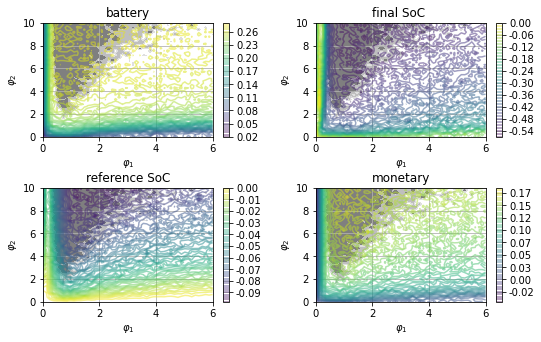

In [47]:
%matplotlib inline
fig, ax = plt.subplots(2,2,figsize=(8,5))
fig.tight_layout(pad=3)
# c0=ax[0,0].contour(X.transpose(), Y.transpose() ,Z[0,:,:,-1],50,alpha=0.8)
# c1=ax[0,1].contour(X.transpose(), Y.transpose() ,Z[0,:,:,1],50,alpha=0.8)
# c2=ax[1,0].contour(X.transpose(), Y.transpose() ,Z[0,:,:,3],50,alpha=0.8)
# c3=ax[1,1].contour(X.transpose(), Y.transpose() ,Z[0,:,:,2],50,alpha=0.8)
cost_list_=['battery','final SoC ','reference SoC','monetary']
rst=0
Z_=Z[0,:,:,rst,:-1]
Q_=Q[0,:,:,rst]
for i,axis in enumerate(ax.flatten()):
    c0=axis.contour(X.transpose(), Y.transpose() ,Z_[:,:,i],50,alpha=0.5)
    axis.contourf(X.transpose(), Y.transpose() ,Q_[:,:],levels=[-np.inf,-2.,-1,0],colors=['black','grey','white'],linestyles='-',alpha=0.5)
    axis.set_xlabel(r'$\varphi_1$')
    axis.set_ylabel(r'$\varphi_2$')
    axis.set_title(cost_list_[i])
    fig.colorbar(c0,ax=axis,format='%.2f')

plt.show()

# h=colorbar('location','southoutside');
# yt=get(h,'XTick');
# set(h,'XTickLabel',sprintf('%2.4f|',yt));

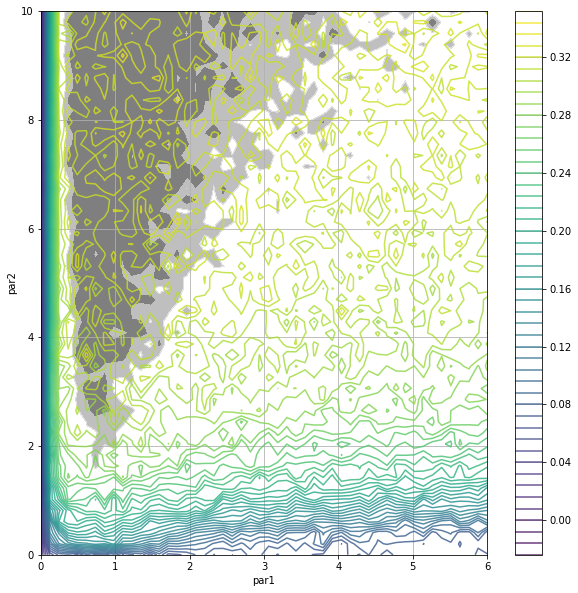

In [48]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
cont=ax.contour(X.transpose(), Y.transpose(), cst_sum,50,alpha=0.8)
ax.contourf(X.transpose(), Y.transpose() ,Q_[:,:],levels=[-np.inf,-2.,-1,0],colors=['black','grey','white'],linestyles='-',alpha=0.5)
plt.colorbar(cont)
# plt.plot(a[0],a[1],'x')
ax.set_xlabel('par1')
ax.set_ylabel('par2')
plt.show()

# 1day Optimization simulation 

In [15]:
Z=get_data('data/winter_c_3_1_2/cost_2022_02_15_1847.npy')
Q=get_data('data/winter_c_3_1_2/constraint_2022_02_15_1847.npy')
par1,par2=get_data('data/winter_c_3_1_2/meta_2022_02_15_1847.npy')
print(Z.shape)
Q[:,:,:,1]=Q[:,:,:,1]-50
# Q[:,:,:,1]=-Q[:,:,:,1]

(30, 50, 50, 5)


In [16]:
cst_mmnt_noise=Z[:,:,:,3].std(axis=0)
const_mmnt_noise=Q[:,:,:,1].std(axis=0)
cst_std=Z[:,:,:,3].std()
const_std=Q[:,:,:,1].std()
cst_mean=Z[:,:,:,3].mean()
const_mean=Q[:,:,:,1].mean()
print('Cost measurement std (noise) is: ',cst_mmnt_noise.mean())
print('Constraint measurement std is:' ,const_mmnt_noise.mean())
print('Cost  std (noise) is: ',cst_std.mean())
print('Constraint  std is:' ,const_std.mean())
print('Cost mean is: ',cst_mean)
print('Constaint mean is: ',const_mean)

Cost measurement std (noise) is:  0.020321811990051
Constraint measurement std is: 0.5235614763246387
Cost  std (noise) is:  0.06117315499131897
Constraint  std is: 21.714260687656918
Cost mean is:  0.03168111811153857
Constaint mean is:  -6.821033381639033


In [17]:
rnd_opt_cst=get_data('rnd_opt_cst_winter_2022_02_15_2317.npy')
rnd_opt_par=get_data('rnd_opt_par_winter_2022_02_15_2317.npy')
 


<AxesSubplot:xlabel='timestamp'>

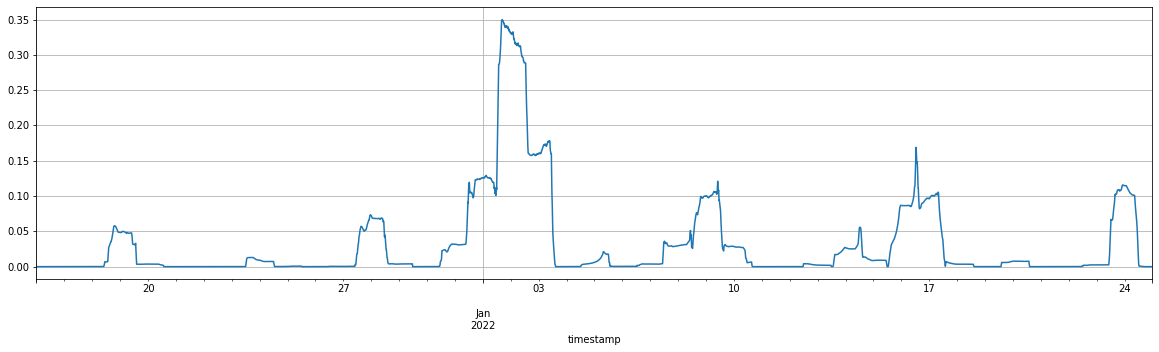

In [61]:
data=data_prepocess(winter)
# data.power_load.plot()
data.Rss.plot()

Cost measurement std (noise) is:  0.020321811990051
Constraint measurement std is: 0.5235614763246387
SO convergence time:  1
SO-UCB convergence time:  5
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.28571429, -0.07142857]), 0.056328273281532504)
(array([ 0.28571429, -0.07142857]), 0.056328273281532504)


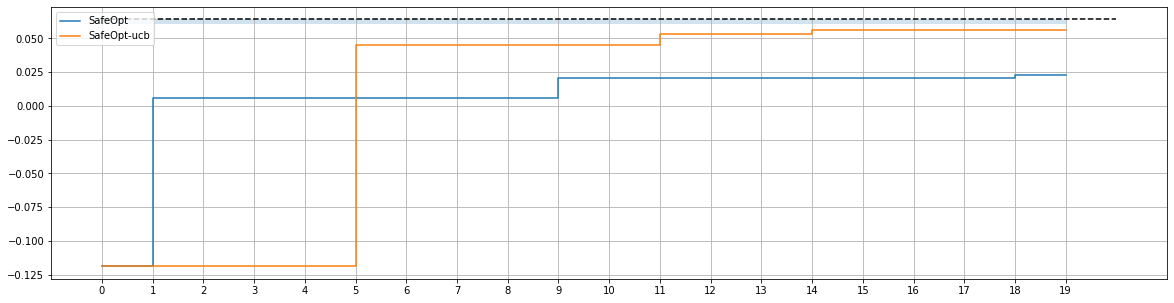

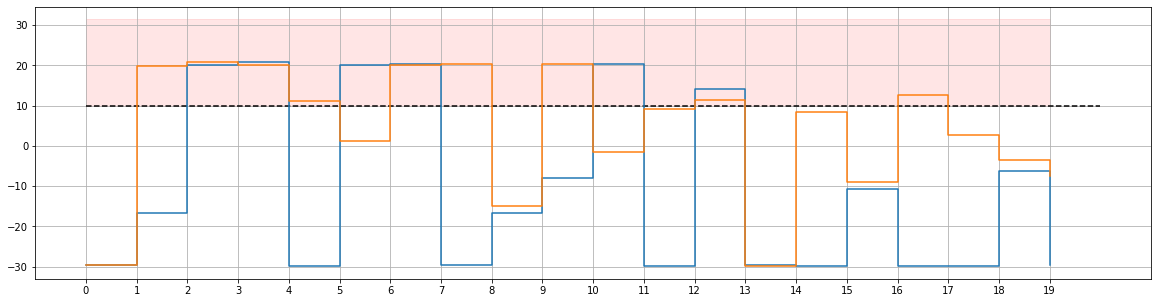

SO convergence time:  nan
SO-UCB convergence time:  13
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.51020408, -0.13265306]), 0.06057880069115033)
(array([ 0.51020408, -0.13265306]), 0.06057880069115033)


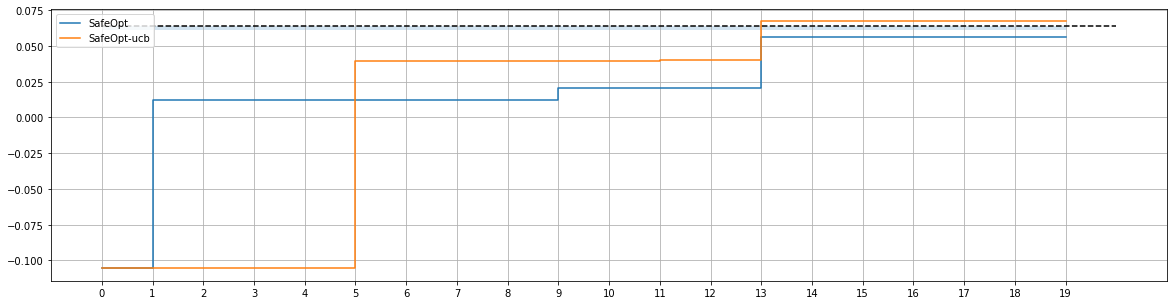

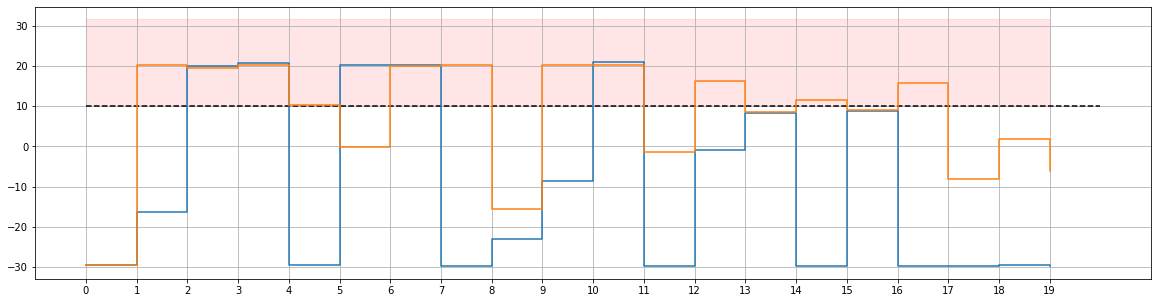

SO convergence time:  nan
SO-UCB convergence time:  15
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.34693878, -0.09183673]), 0.06624603603455739)
(array([ 0.34693878, -0.09183673]), 0.06624603603455739)


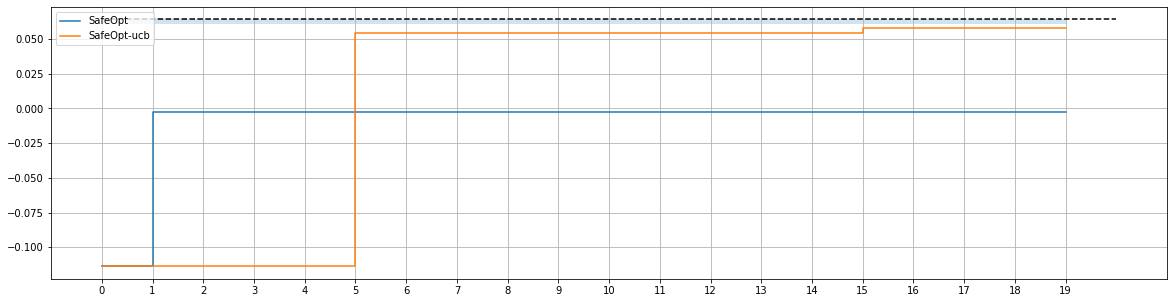

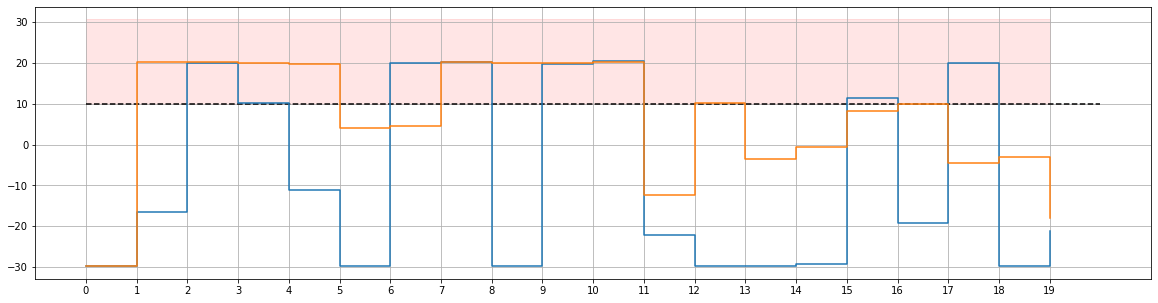

SO convergence time:  nan
SO-UCB convergence time:  17
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.59183673, -0.21428571]), 0.06345303386528527)
(array([ 0.59183673, -0.21428571]), 0.06345303386528527)


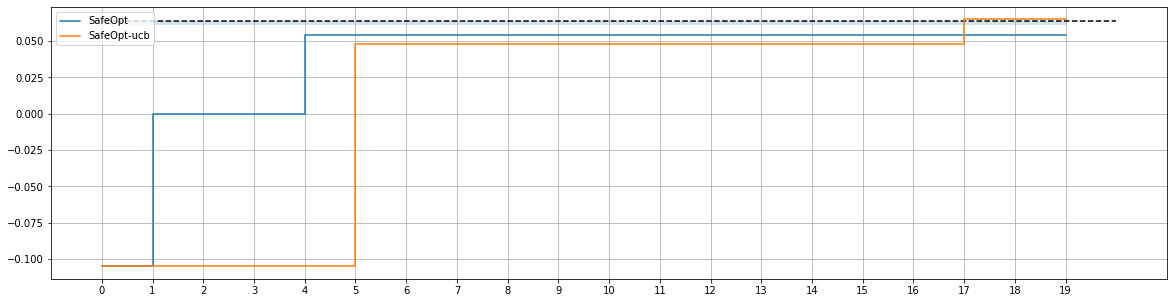

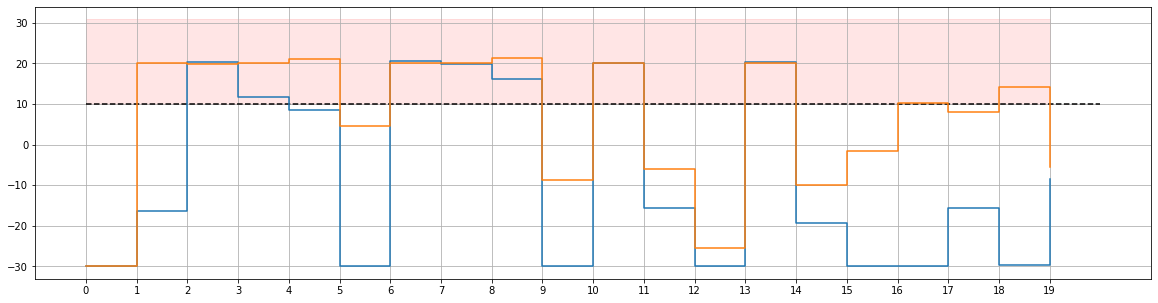

SO convergence time:  nan
SO-UCB convergence time:  19
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.46938776, -0.15306122]), 0.06307234224212135)
(array([ 0.46938776, -0.15306122]), 0.06307234224212135)


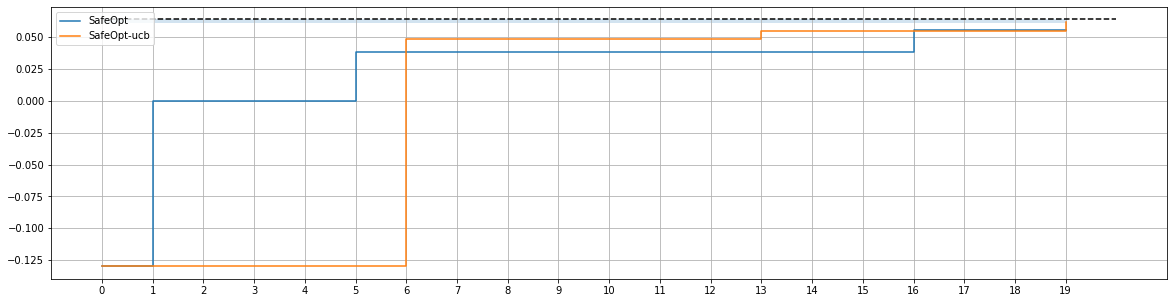

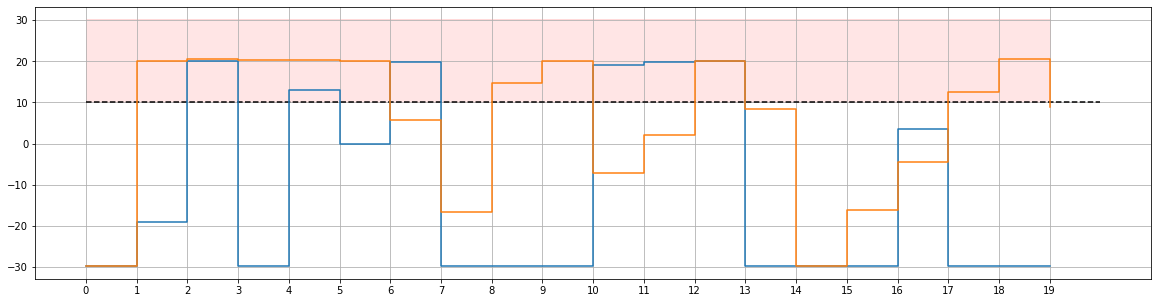

SO convergence time:  nan
SO-UCB convergence time:  17
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.48979592, -0.15306122]), 0.06570690325739188)
(array([ 0.48979592, -0.15306122]), 0.06570690325739188)


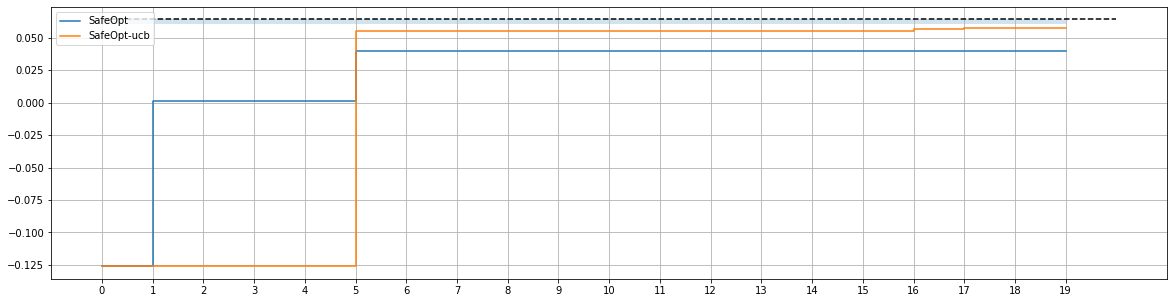

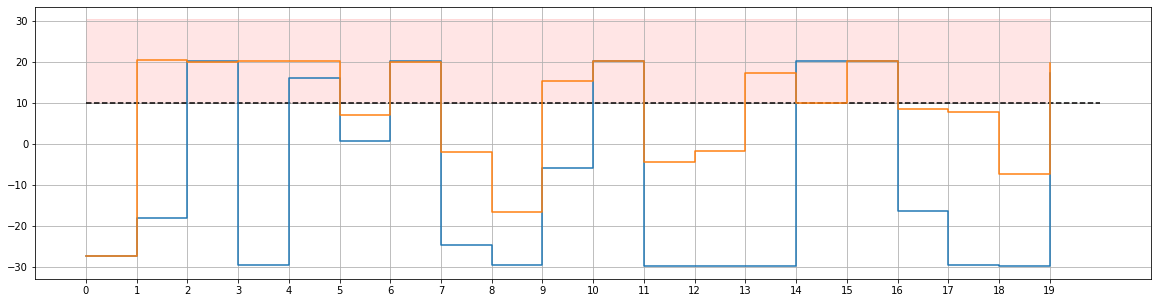

SO convergence time:  nan
SO-UCB convergence time:  4
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.59183673, -0.23469388]), 0.06601319085600818)
(array([ 0.59183673, -0.23469388]), 0.06601319085600818)


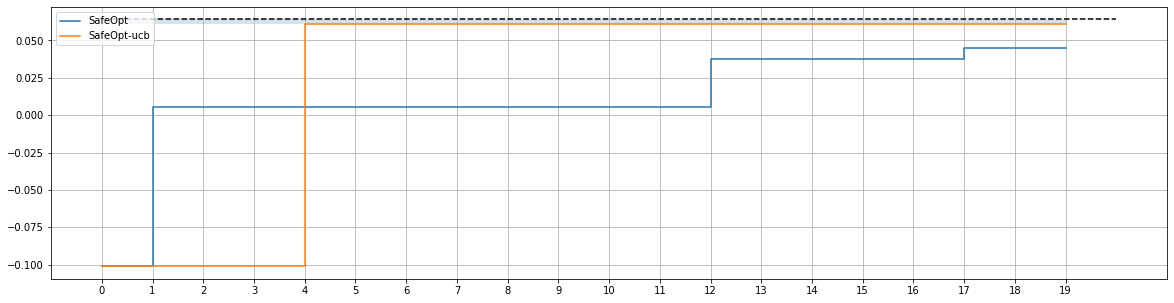

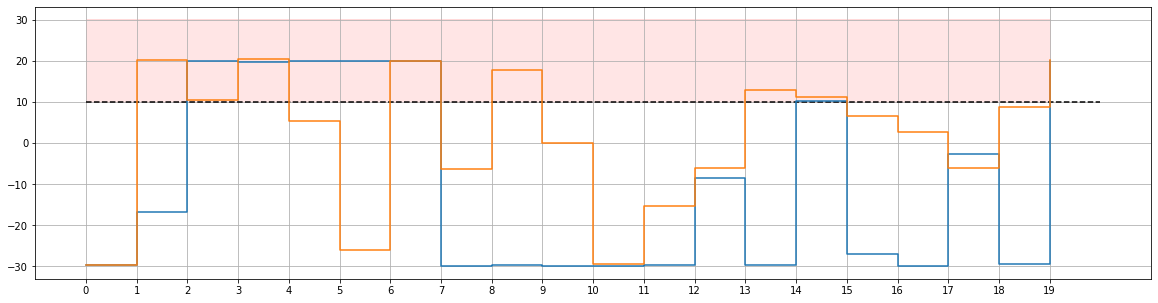

SO convergence time:  4
SO-UCB convergence time:  14
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.6122449 , -0.21428571]), 0.06787965854400667)
(array([ 0.6122449 , -0.21428571]), 0.06787965854400667)


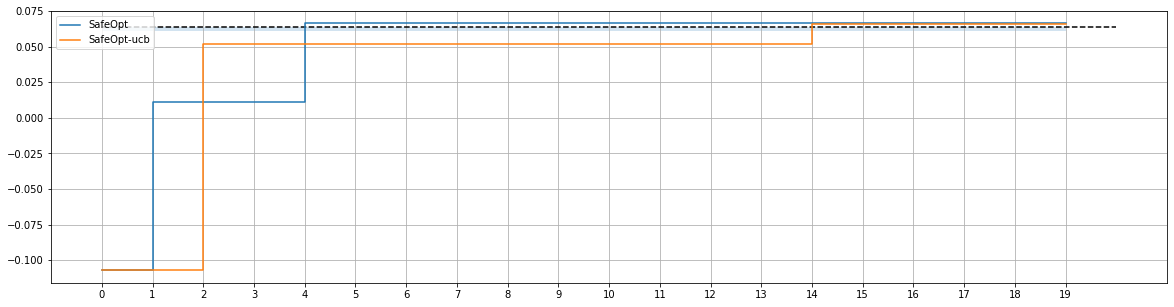

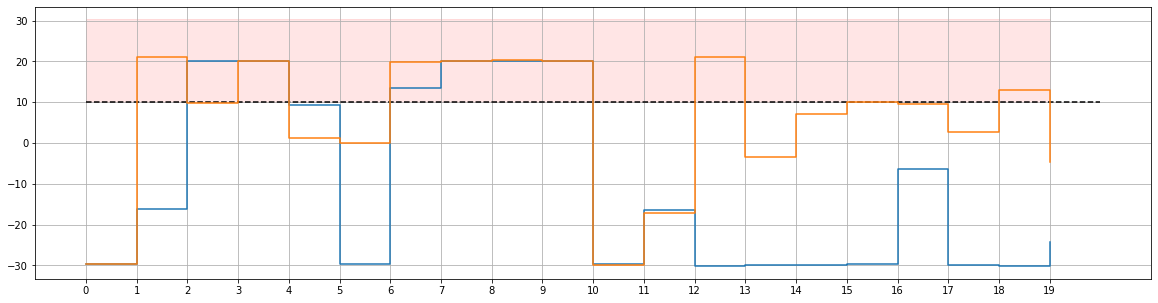

SO convergence time:  nan
SO-UCB convergence time:  13
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.48979592, -0.17346939]), 0.06531643367686267)
(array([ 0.48979592, -0.17346939]), 0.06531643367686267)


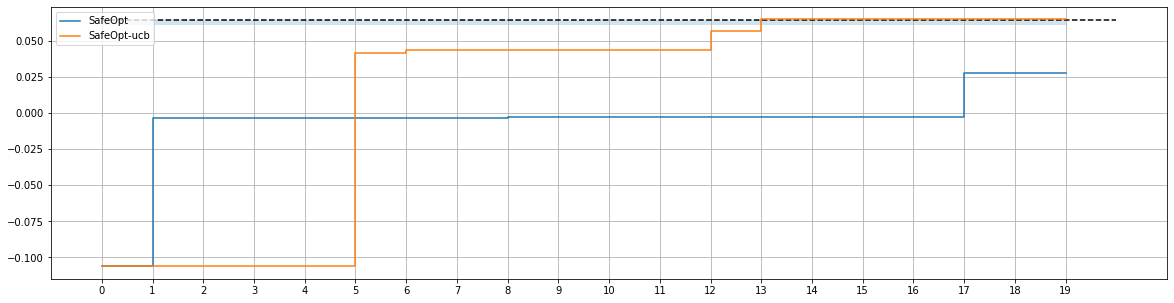

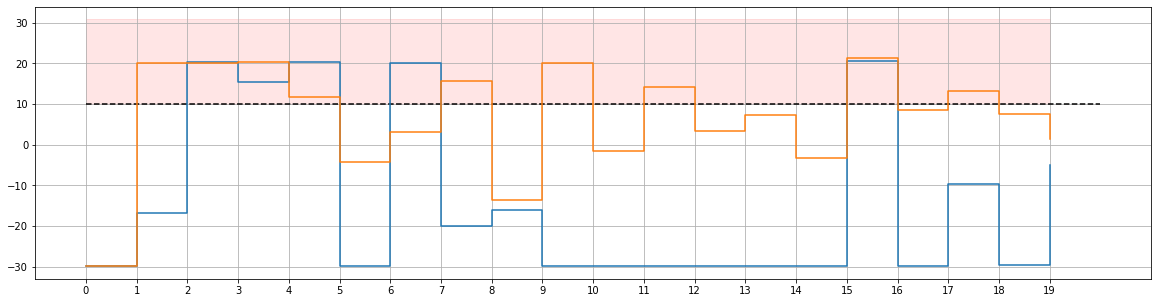

SO convergence time:  nan
SO-UCB convergence time:  15
opt cost is:  0.06405123129356873
opt par is:  [ 0.36426671 -0.18031987]
(array([ 0.55102041, -0.19387755]), 0.06169136429924782)
(array([ 0.55102041, -0.19387755]), 0.06169136429924782)


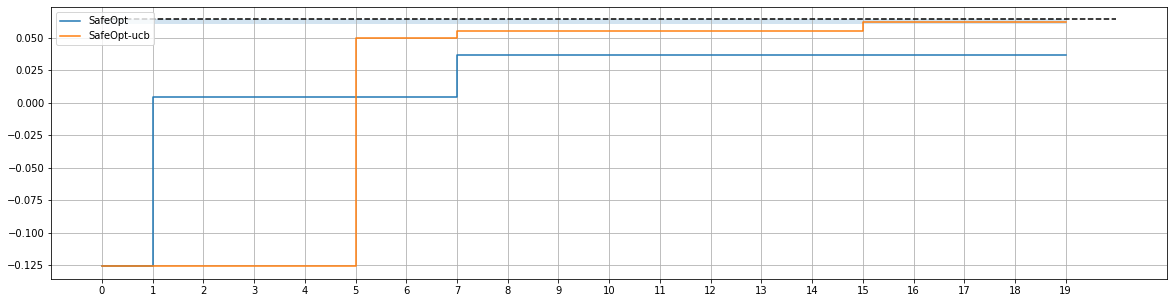

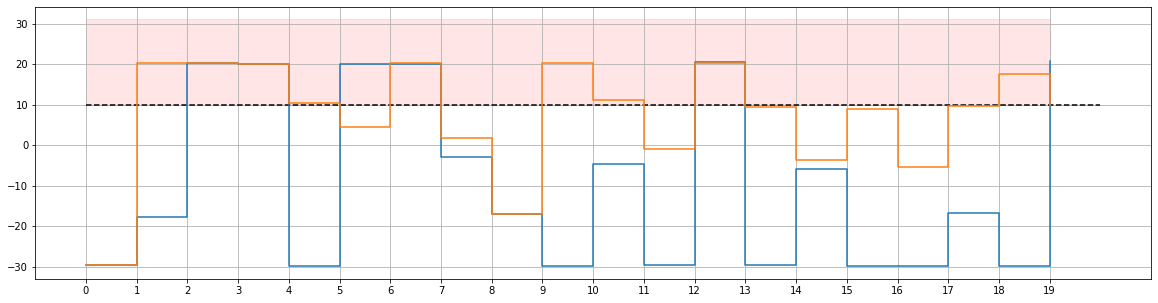

In [49]:
hp=[0.03062711 ,0.07965357 ,3.66768921 ,0.1665233  ,0.59013054]
# hp=[0.06141974, 0.11845341, 4.56919819, 0.07219048, 2.22105846]
# [0.0316132  0.12614127 4.1930857  0.06940804 0.81407142]
# [0.08103178 0.06086422 3.19074855 0.16933167 2.94930198]
# [0.07239133 0.14326271 8.77797375 0.18006289 1.8183776 ]
hp=[0.0858622,  0.14612614 ,9.81241298 ,0.17682919 ,2.57451667]
# hp=[0.03346027 ,0.15612457 ,8.44635747 ,0.07669521 ,2.80042934]
hp=[0.09529001, 0.13195035, 1.05457062, 0.17805899, 1.47036873]
Vz=hp[0]
Lz=hp[1]
Vq=hp[2]
Lq=hp[3]
beta=hp[4]


print('Cost measurement std (noise) is: ',cst_mmnt_noise.mean())
print('Constraint measurement std is:' ,const_mmnt_noise.mean())

S_os_max=10
opt_cost=rnd_opt_cst[0]
def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
    p_load=data[:T*day+N_lim[1]]
#     c0=plant_cost(x0,T,p_load.copy(),N_lim,soc_lim,soc_i,phib,plot=False,plot_cost=False)[0]
#     c0=c0[3]+1*c0[2]+c0[1]+1*c0[0]
    x=x0
    i=0
#     plt.plot(p_load)
#     plt.show()
    while True:
        i+=1
        i=0 #always first day
        soc_i=50 #always same soc_i
        c,q,soc_f=plant_cost(x,T,p_load.copy(),N_lim,soc_lim,soc_i,phib,plot=False,plot_cost=False,noise=True)
        x=yield c[3],soc_f-50
        p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
#         plt.plot(p_load)
#         plt.show()

T=1 #Time horizon in days
noise_cst = cst_mmnt_noise.mean()
noise_const = const_mmnt_noise.mean()
stop=100
# Bounds on the inputs variable
bounds = [(0., 1.),(-0.5,0.5)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 50)
# Define Kernel
for x_ in np.random.uniform(-0.5,-0.05,10):
    cost_kernel = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz,Lz], ARD=True,)
    const_kernel=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq,Lq], ARD=True)
    x0=np.array([[0,x_]])

    cost=cost_g(x0.flatten())
    y0= np.atleast_2d(cost.send(None))
    mf0 = GPy.core.Mapping(2,1)
    mf1 = GPy.core.Mapping(2,1)
    def prior_cst(x):
        return 0
    mf0.f = prior_cst
    mf0.update_gradients=lambda a,b:None
    def prior_const(x):
        return 0
    mf1.f = prior_const
    mf1.update_gradients=lambda a,b:None

    cost_gp = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel, noise_var=noise_cst,mean_function=mf0)
    const_gp= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel, noise_var=noise_const,mean_function=mf1)
    gp=[cost_gp,const_gp]
    # The optimization routine
    opt = safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-50]),beta=beta)
    opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-50]),beta=beta)
    # opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
    iterations=20
    y_meas=np.empty((iterations,y0.shape[1]))
    x_next=np.empty((iterations,x0.shape[1]))
    y_meas_ucb=np.empty((iterations,y0.shape[1]))
    x_next_ucb=np.empty((iterations,x0.shape[1]))
    y_meas[0,:]=y0.flatten()
    y_meas_ucb[0,:]=y0.flatten()
    x_next[0,:]=x0.flatten()
    x_next_ucb[0,:]=x0.flatten()

    # print(x0,y0)
    for i in range(1,iterations):
    #     print(i)
        # Obtain next query point
        x_next[i,:] = opt.optimize()
        x_next_ucb[i,:] = opt_ucb.optimize(ucb=True)

        # Get a measurement from the real system
        y_meas[i,:] = cost.send(x_next[i,:].flatten())
        y_meas_ucb[i,:] = cost.send(x_next_ucb[i,:].flatten())

    #     print(x_next[i,:],y_meas[i,:])
    #     print(x_next_ucb[i,:],y_meas_ucb[i,:])

    #     if y_meas[0,0]>stop:
    #         break
        # Add this to the GP model
        opt.add_new_data_point(x_next[i,:], np.atleast_2d(y_meas[i,:]))
        opt_ucb.add_new_data_point(x_next_ucb[i,:], np.atleast_2d(y_meas_ucb[i,:]))

#         opt.plot(100,plot_3d=False,**{'figsize':(5,5)})
    #     print('current max estiamte= ',opt.get_maximum())
    #     print('current max estiamte ucb= ',opt_ucb.get_maximum())

    #     plt.savefig('%s.png'%i)
#         plt.show()

    # Cut-------------------------------------------
    def best_constrained_value(y):
        y=y.copy()
        yi=y[0,0]
        for i,y_ in enumerate(y[1:,:]):
            if y_[1]>-S_os_max:     
                y[i+1,0]=max(yi,y_[0])
                yi=y[i+1,0]
            else:
                y[i+1,0]=yi
        return y[:,0]
    def find_iter(y,opt,tol=1e-1,cnt=None):
        for i,y_ in enumerate(y):
            if y_[0]>=opt*(1-tol) and y_[1]>=cnt:
                return i
        return np.nan
    print('SO convergence time: ',find_iter(y_meas,opt_cost,cnt=-S_os_max))        
    print('SO-UCB convergence time: ',find_iter(y_meas_ucb,opt_cost,cnt=-S_os_max))

    opt_cost=-rnd_opt_cst[0]
    print('opt cost is: ',-rnd_opt_cst[0])
    print('opt par is: ',rnd_opt_par[0])
    print(opt.get_maximum())
    print(opt_ucb.get_maximum())

    err=5e-2
    plt.step(range(iterations),best_constrained_value(y_meas),where='post',label='SafeOpt')
    plt.step(range(iterations),best_constrained_value(y_meas_ucb),where='post',label='SafeOpt-ucb')
    plt.hlines(opt_cost,0,iterations,'k',linestyles='--')
    plt.fill_between(range(iterations),opt_cost*np.ones(iterations),(1-err)*opt_cost*np.ones(iterations),alpha=0.2)
    # plt.plot(range(iterations),y_meas[:,0],'--')
    plt.xticks(np.arange(0,iterations,1))
    plt.legend()
    plt.show()
    plt.step(range(iterations),-y_meas[:,1],where='post',label='SafeOpt')
    plt.step(range(iterations),-y_meas_ucb[:,1],where='post',label='SafeOpt-ucb')
    plt.hlines(S_os_max,0,iterations,'k',linestyles='--')
    plt.fill_between(range(iterations),y1=S_os_max,y2=1.5*max(-y_meas[:,1]),color='red',alpha=0.1)
    plt.xticks(np.arange(0,iterations,1))
    plt.show()


In [58]:
def gmax_const(opt,cnt=S_os_max):     
    x,y = opt.data
    max_idx=y[y[:,1]>=-cnt][:,0].argmax()
    print(max_idx)
    return x[y[:,1]>=-cnt][max_idx], y[y[:,1]>=-cnt][:,0].max()
gmax_const(opt,10)

3


(array([ 0.46938776, -0.29591837]), 0.03683652027078285)

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/safeopt/utilities.py:362: UserWarning:The following kwargs were not used by contour: 'figsize'
 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/safeopt/utilities.py:362: UserWarning:The following kwargs were not used by contour: 'figsize'
 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/safeopt/utilities.py:362: UserWarning:The following kwargs were not used by contour: 'figsize'
 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/safeopt/utilities.py:362: UserWarning:The following kwargs were not used by contour: 'figsize'


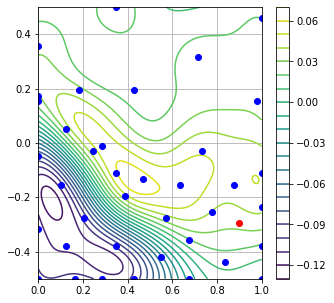

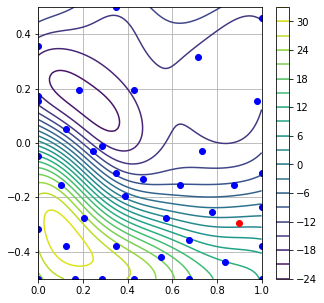

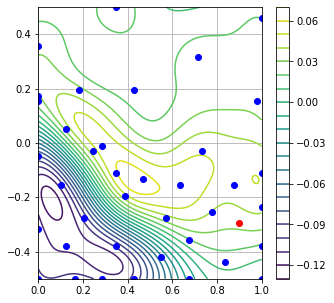

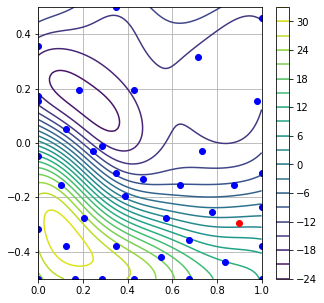

In [24]:
opt.plot(100,plot_3d=False,**{'figsize':(5,5)})
opt_ucb.plot(100,plot_3d=False,**{'figsize':(5,5)})


In [174]:
save_data(opt.data[0],'../fig_scripts/metrics_subplots/parameters_search_winter_c_3_0')
save_data(opt.data[1],'../fig_scripts/metrics_subplots/cost_search_winter_c_3_0')

../fig_scripts/metrics_subplots/parameters_search_winter_c_3_0_2022_01_27_0742
../fig_scripts/metrics_subplots/cost_search_winter_c_3_0_2022_01_27_0742


In [63]:
%matplotlib 
opt_ucb.plot(200,plot_3d=True)

Using matplotlib backend: MacOSX


 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


# K-day contextual optimization simulation 

Z=get_data('data/winter_c_3_1_2/cost_2022_02_26_1029.npy')
Q=get_data('data/winter_c_3_1_2/constraint_2022_02_26_1029.npy')
par1,par2=get_data('data/winter_c_3_1_2/meta_2022_02_26_1029.npy')
print(Z.shape)
Q[:,:,:,1]=Q[:,:,:,1]-50


cst_mmnt_noise=Z[:,:,:,3].std(axis=0)
const_mmnt_noise=Q[:,:,:,1].std(axis=0)
cst_std=Z[:,:,:,3].std()
const_std=Q[:,:,:,0].std()
cst_mean=Z[:,:,:,3].mean()
const_mean=Q[:,:,:,0].mean()
print('Cost measurement std (noise) is: ',cst_mmnt_noise.mean())
print('Constraint measurement std is:' ,const_mmnt_noise.mean())
print('Cost  std (noise) is: ',cst_std.mean())
print('Constraint  std is:' ,const_std.mean())
print('Cost mean is: ',cst_mean)
print('Constaint mean is: ',const_mean)

data=data_prepocess(winter)
data= data_context(load_generator(data))

In [53]:
# (75000, 3)
# (684, 3) (684,)
# 3.13**2 * RBF(length_scale=[0.486, 0.487, 0.247]) + WhiteKernel(noise_level=0.0991)
# (75000, 3)
# (676, 3) (676,)
# 0.296**2 * RBF(length_scale=[0.227, 0.896, 0.279]) + WhiteKernel(noise_level=0.000826)
# (75000, 3)
# (673, 3) (673,)
# 0.195**2 * RBF(length_scale=[0.344, 0.161, 0.11]) + WhiteKernel(noise_level=6.37e-07)


In [3]:
# data=get_data('model_data/model_spring_data_2022_03_16_0745.csv',npy=False)
data=get_data('model_data/model_winter_data_2022_03_15_0131.csv',npy=False)
data=data.set_index(pd.to_datetime(data.index))

In [4]:
# rnd_opt_cst=get_data('NL_opt/mrnd_opt_cst_spring_3_1_2_2022_03_16_1143.npy')
# rnd_opt_par=get_data('NL_opt/mrnd_opt_par_spring_3_1_2_2022_03_16_1143.npy')
# meta=get_data('NL_opt/mrnd_opt_metadata_spring_3_1_2_2022_03_16_1143.npy')
# code=get_data('NL_opt/mrnd_opt_code_spring_3_1_2_2022_03_16_1143.npy')
# Cdev=1.2
# Standard 
rnd_opt_cst=get_data('NL_opt/mrnd_opt_cst_winter_3_1_2_2022_04_03_1333.npy')
rnd_opt_par=get_data('NL_opt/mrnd_opt_par_winter_3_1_2_2022_04_03_1333.npy')
meta=get_data('NL_opt/mrnd_opt_metadata_winter_3_1_2_2022_04_03_1333.npy')
code=get_data('NL_opt/mrnd_opt_code_winter_3_1_2_2022_04_03_1333.npy')
meta

array([0, list([30, 80]), list([32, 80]), 'rp_100gb_qs_qf_winter', 96, 1],
      dtype=object)

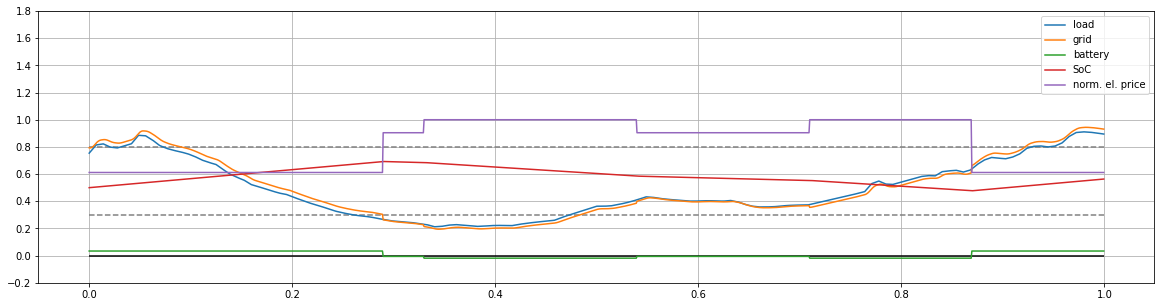

[ 0.21021354 -0.1351839 ]
47.702651594253126 54.999999516547305
context 0.0


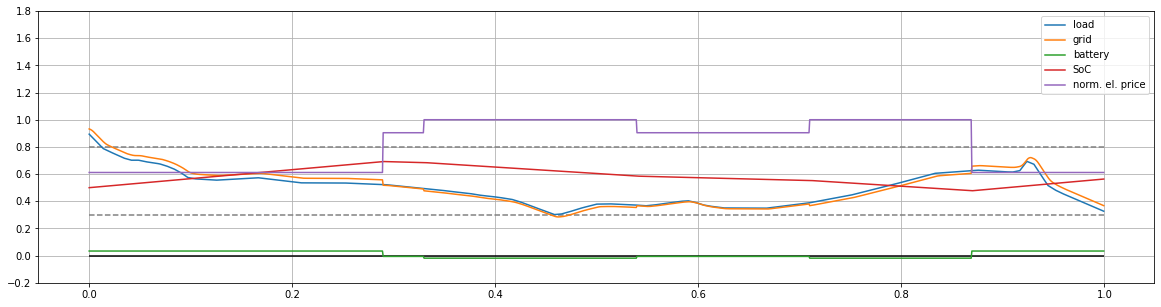

[ 0.2099771  -0.13505349]
47.71027879417995 54.999999514844795
context 0.0


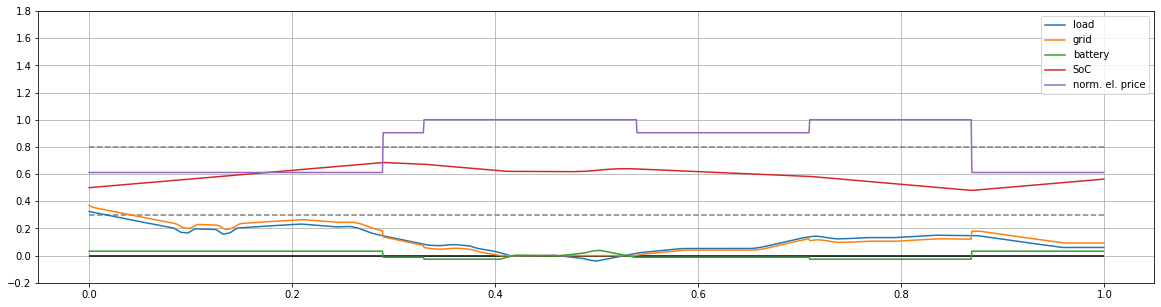

[ 0.23569406 -0.13056275]
47.97291905118423 54.99999966780265
context 0.0304603837270082


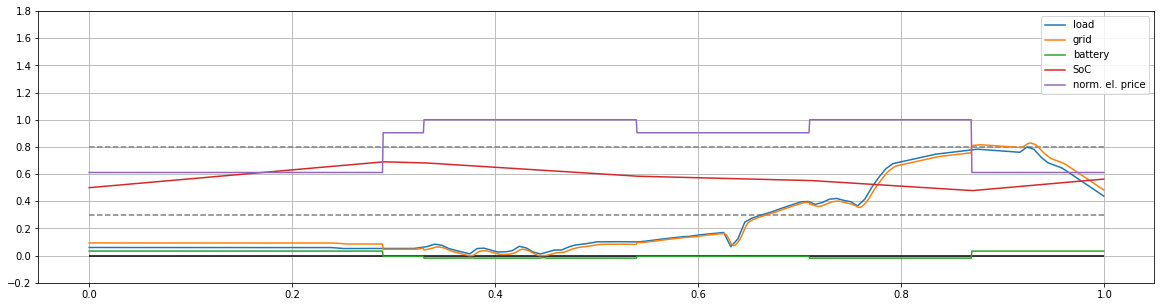

[ 0.2076587  -0.13369295]
47.78984976852756 54.99999959599424
context 0.0


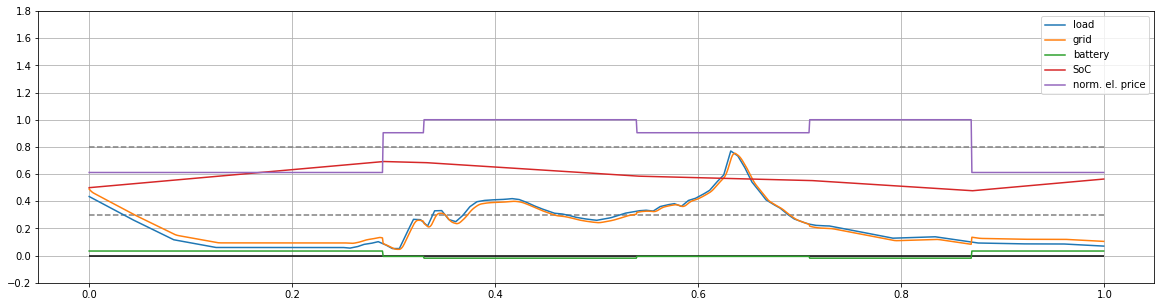

[ 0.21021699 -0.1351858 ]
47.70254031151494 54.99999951644685
context 0.0


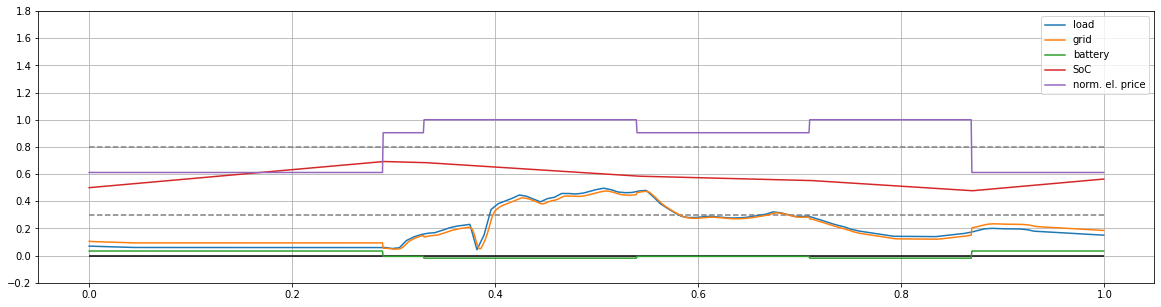

[ 0.21021716 -0.13518589]
47.7025349893315 54.99999951644231
context 0.0


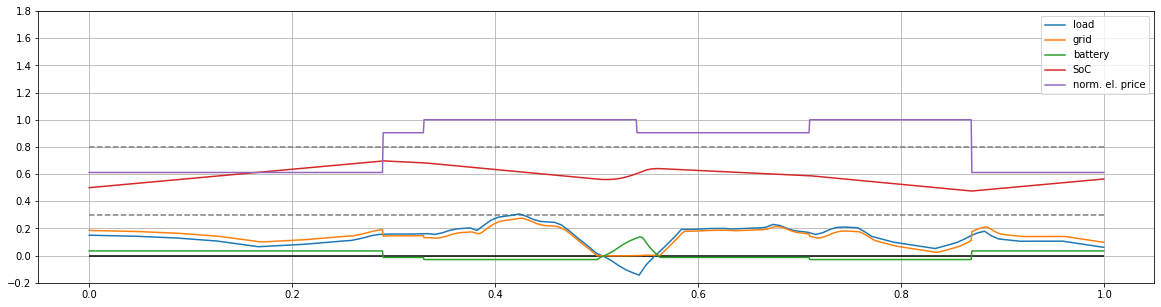

[ 0.25377925 -0.13817708]
47.527595241277304 54.99999905861682
context 0.0923122024953503


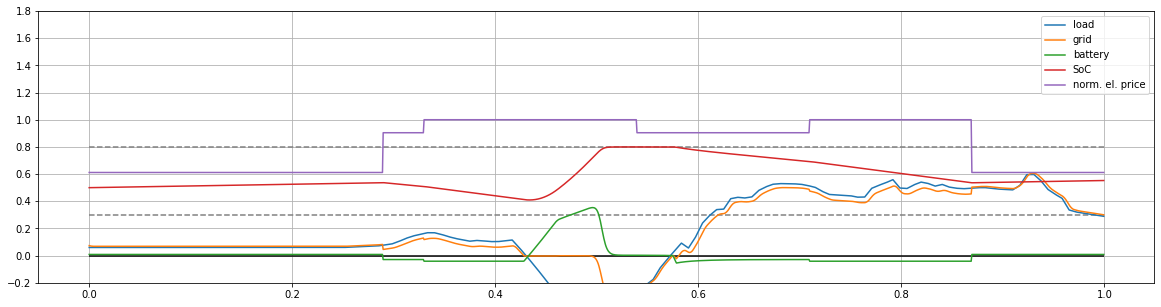

[ 0.19882525 -0.03438694]
40.945965097700004 55.00000000321296
context 0.5


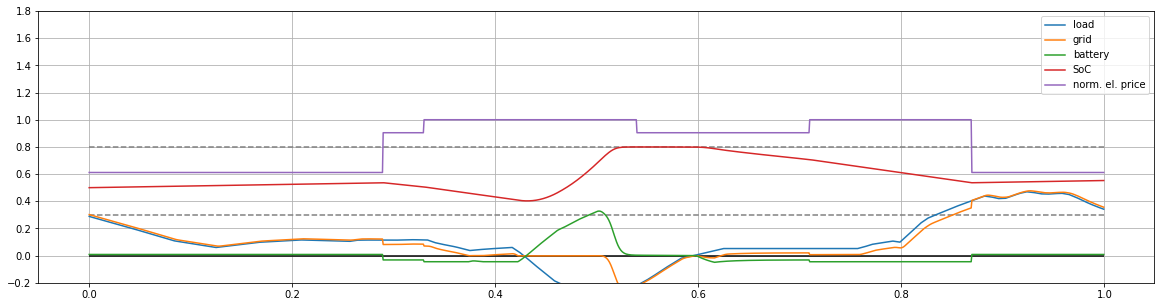

[ 0.21363874 -0.03400648]
40.27722952203413 54.999999943043484
context 0.5


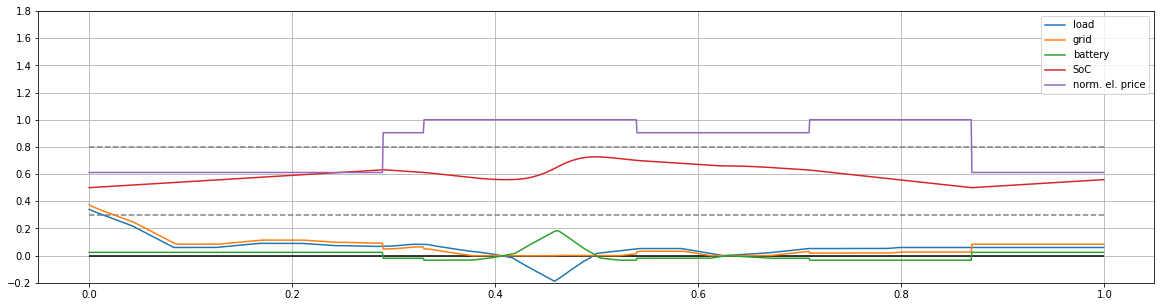

[ 0.23025199 -0.09595693]
49.99683290004985 54.99999864807874
context 0.1910048349416401


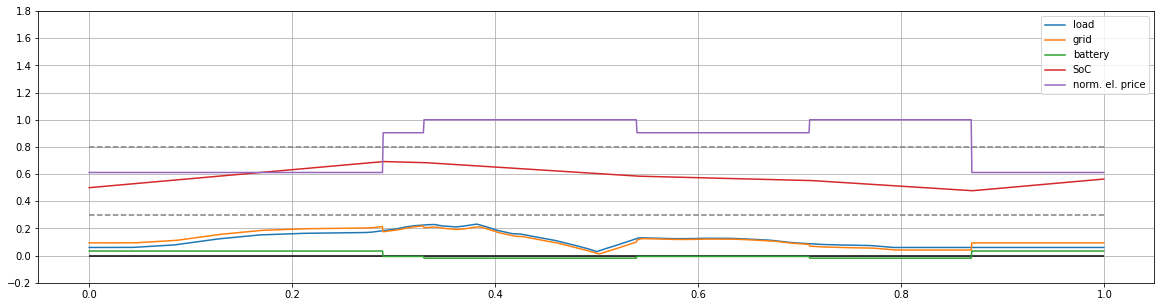

[ 0.2099434 -0.1350349]
47.71136571967939 54.999999515835995
context 0.0


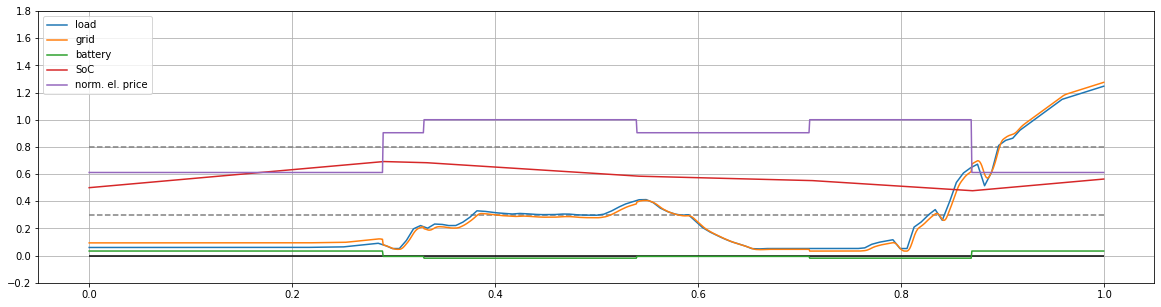

[ 0.20997454 -0.13505208]
47.71036124157012 54.99999951491966
context 0.0


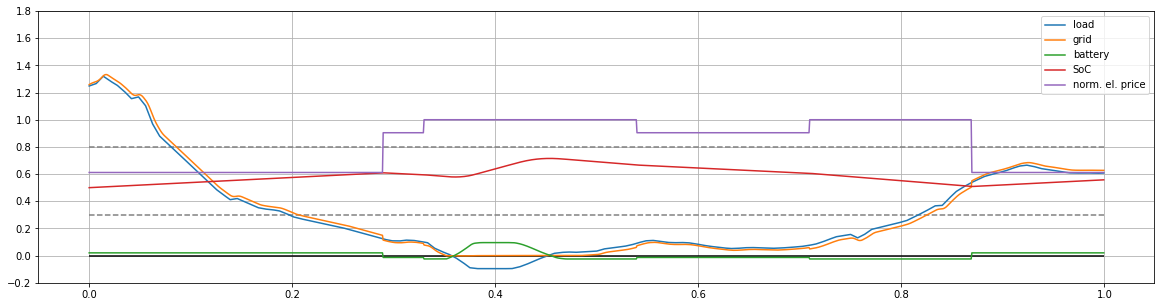

[ 0.17933923 -0.0812447 ]
50.85727496962879 54.99999881745075
context 0.1564303737521792


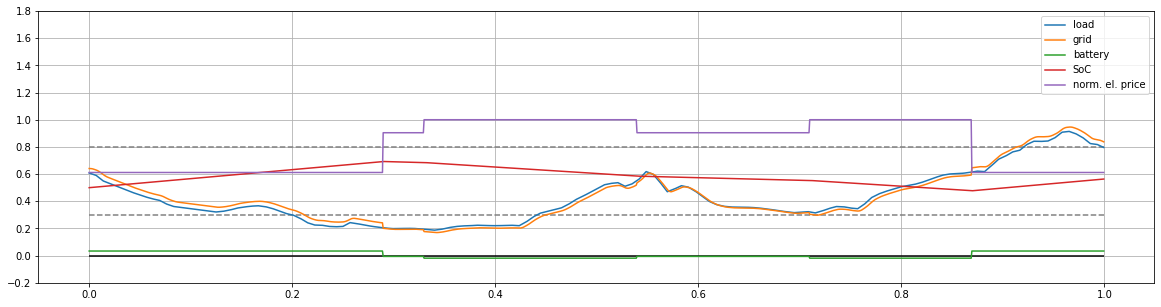

[ 0.21021354 -0.1351839 ]
47.702651594253126 54.999999516547305
context 0.0


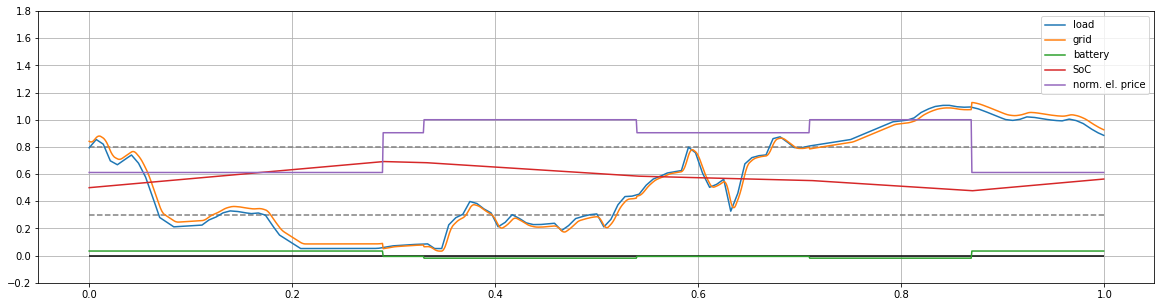

[ 0.209973   -0.13505123]
47.71041096280479 54.999999514963996
context 0.0


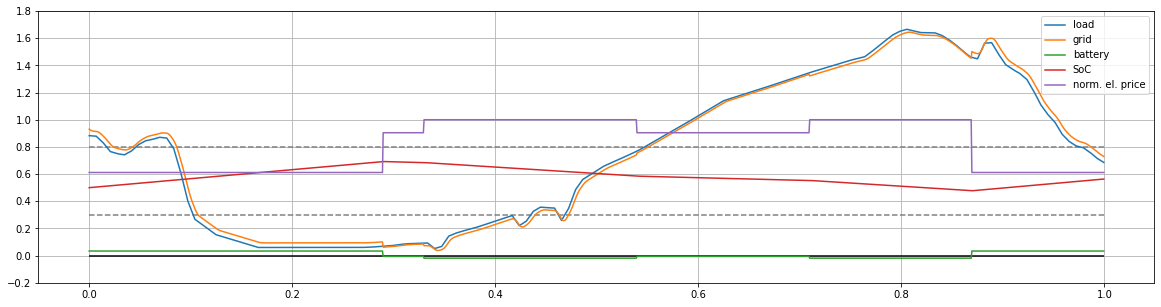

[ 0.20997569 -0.13505271]
47.71032405987396 54.99999951488792
context 0.0


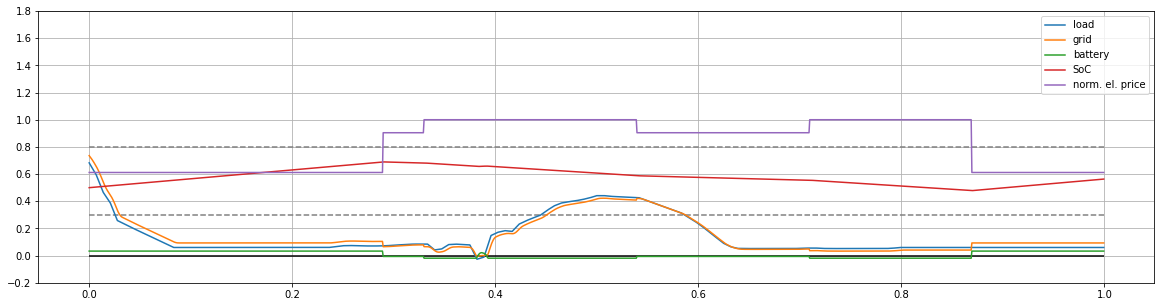

[ 0.20896024 -0.13322293]
47.81733871314924 54.99999960559254
context 0.003812497070542


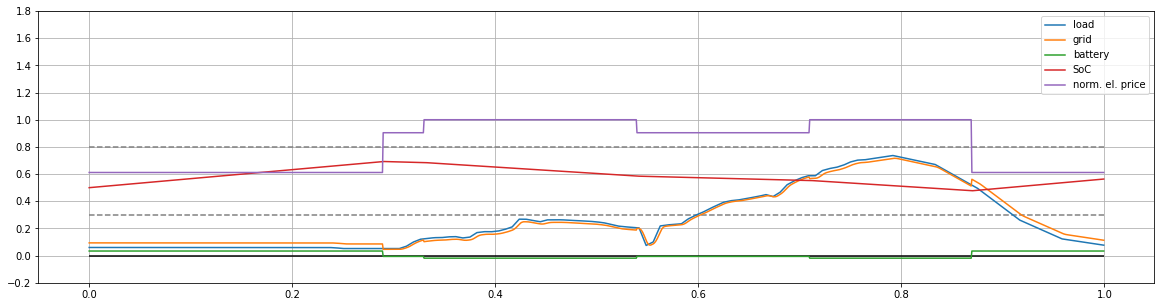

[ 0.21022132 -0.13518819]
47.70240081280223 54.99999951632253
context 0.0


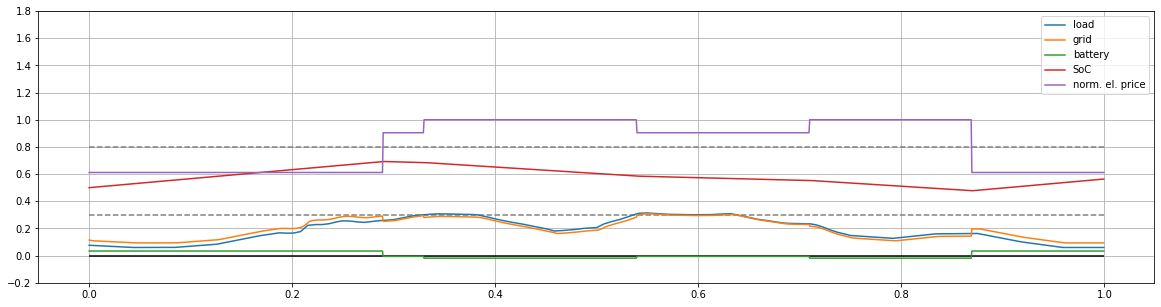

[ 0.21021661 -0.13518559]
47.70255259793081 54.99999951645821
context 0.0


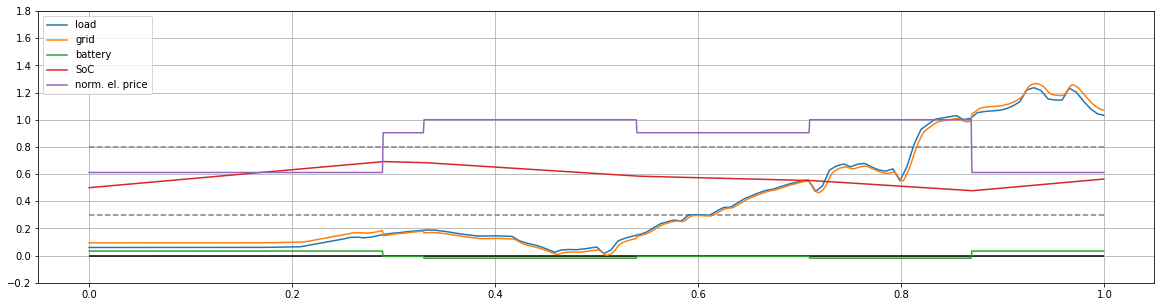

[ 0.20969369 -0.13489717]
47.71942056792319 54.99999931006147
context 0.0


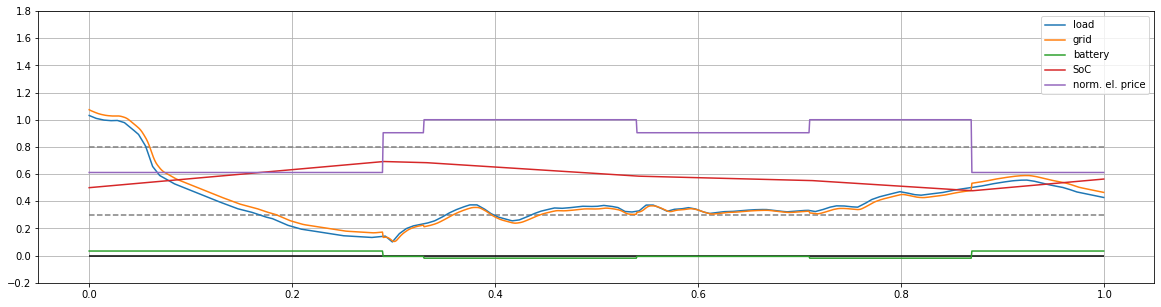

[ 0.21021354 -0.1351839 ]
47.702651594253126 54.999999516547305
context 0.0


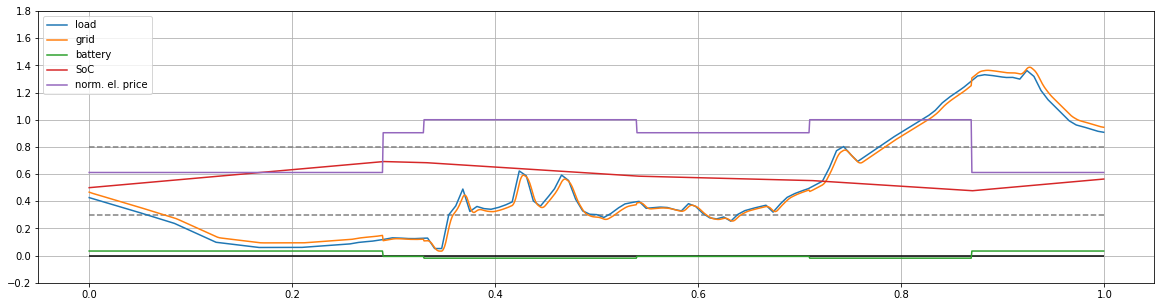

[ 0.2099768  -0.13505332]
47.71028841802535 54.99999951485401
context 0.0


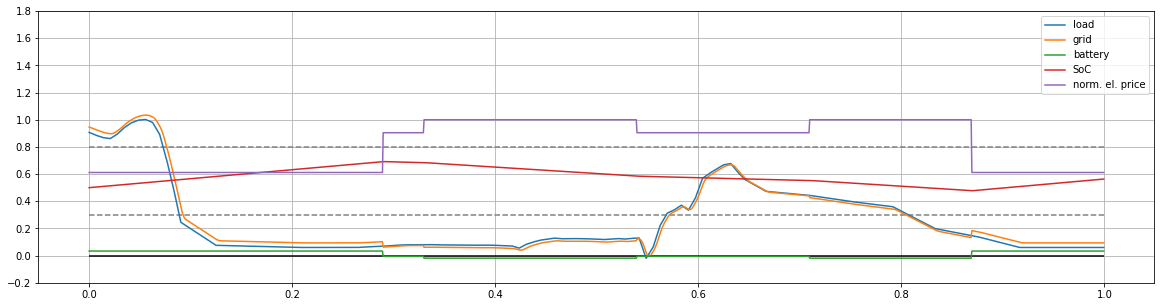

[ 0.20966912 -0.13484068]
47.722724399588856 54.99999928828289
context 0.0006582514051761


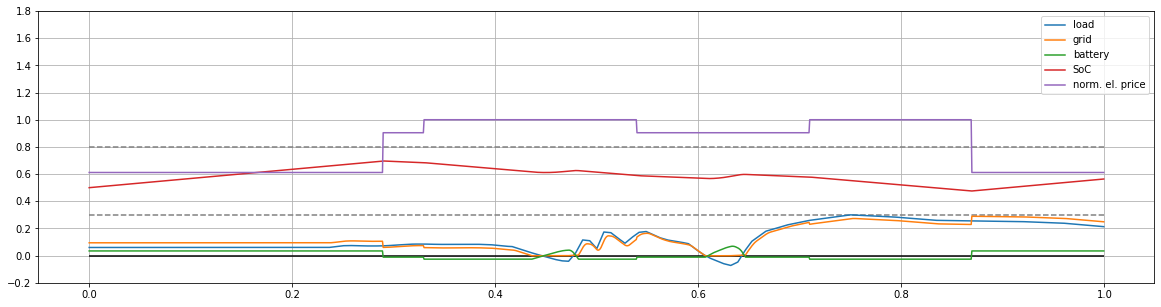

[ 0.24190685 -0.13765027]
47.55840564684199 54.99999916208014
context 0.0555077351849198


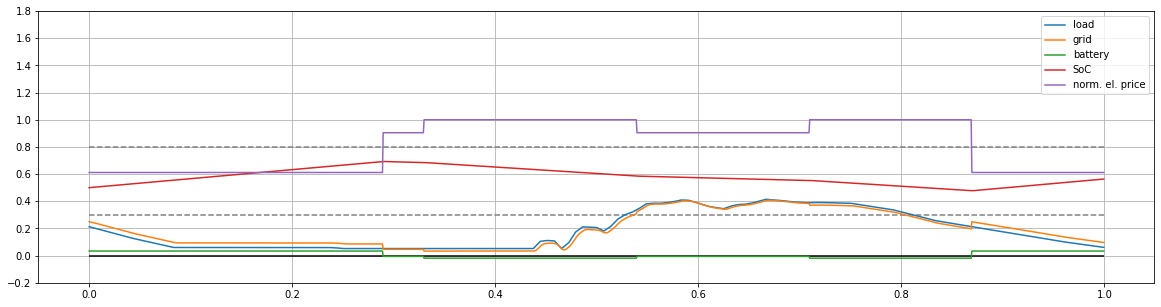

[ 0.21034264 -0.1352551 ]
47.69848705673517 54.99999928274833
context 0.0


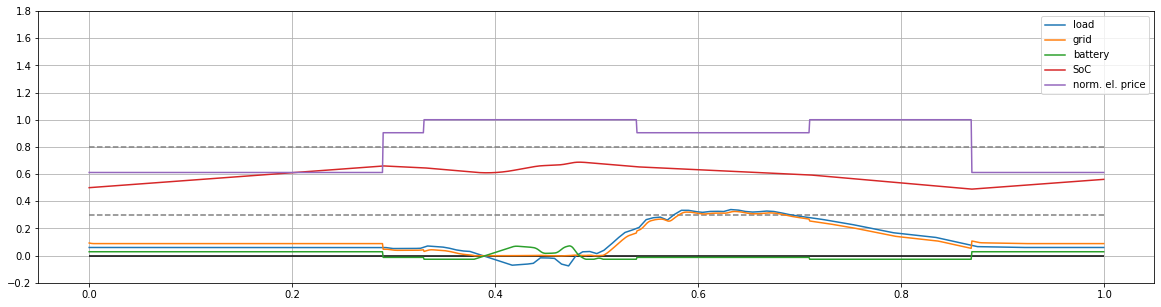

[ 0.22067743 -0.1141064 ]
48.93536606806571 54.99999982368568
context 0.0938682549998716


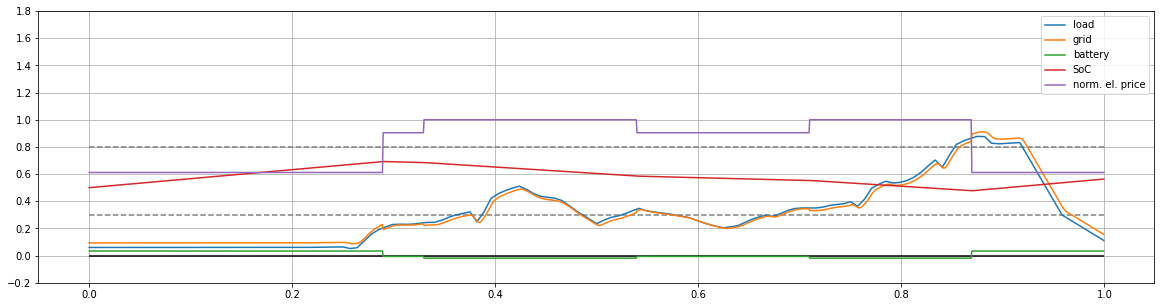

[ 0.21021354 -0.1351839 ]
47.702651594253126 54.999999516547305
context 0.0


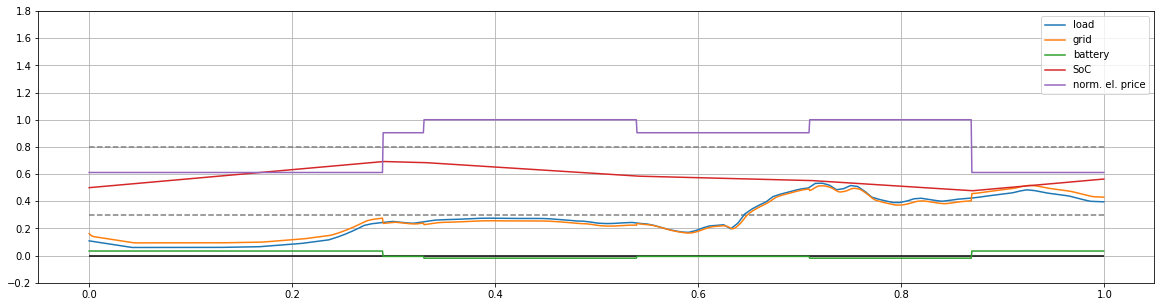

[ 0.21021354 -0.1351839 ]
47.702651594253126 54.999999516547305
context 0.0


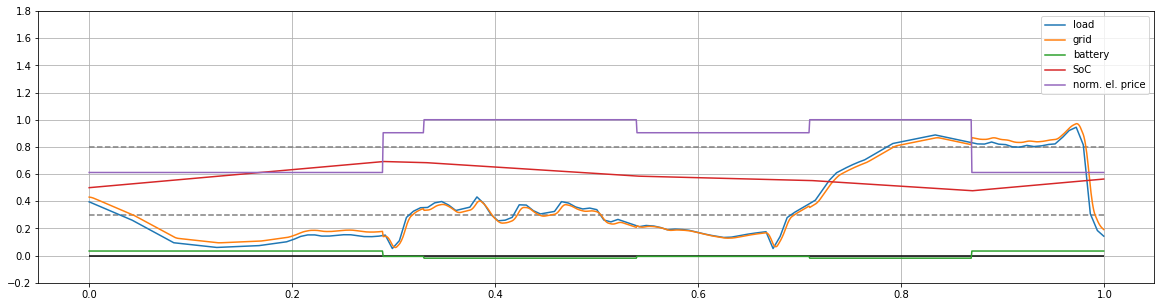

[ 0.2102132  -0.13518371]
47.70266280539397 54.99999951655661
context 0.0


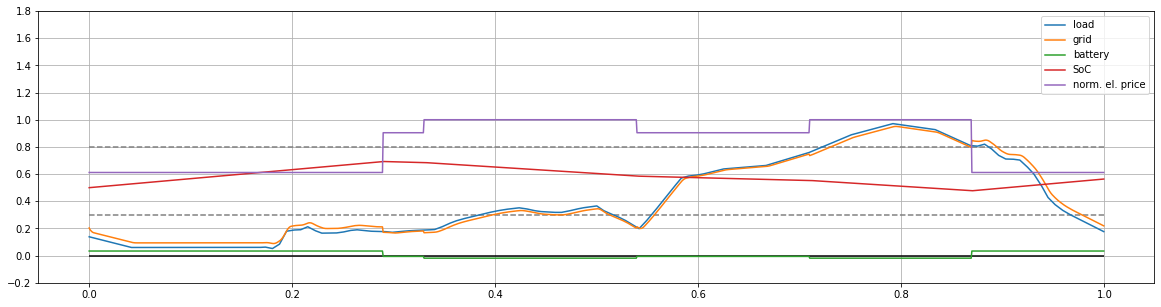

[ 0.21021354 -0.1351839 ]
47.702651594253126 54.999999516547305
context 0.0


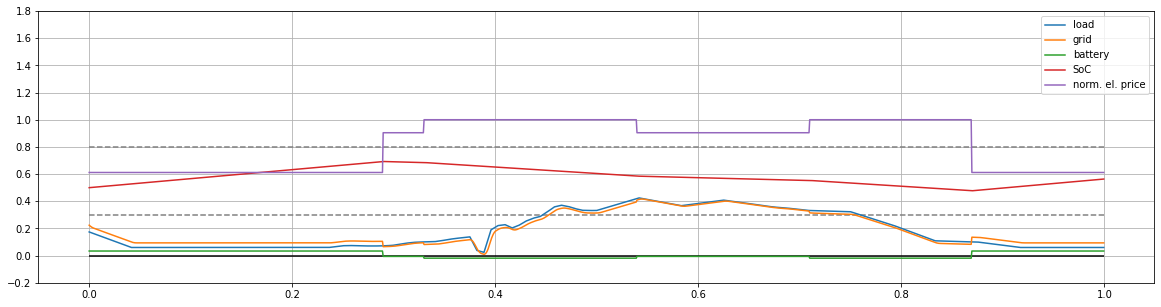

[ 0.21024296 -0.13520012]
47.70170242946812 54.99999928699917
context 0.0


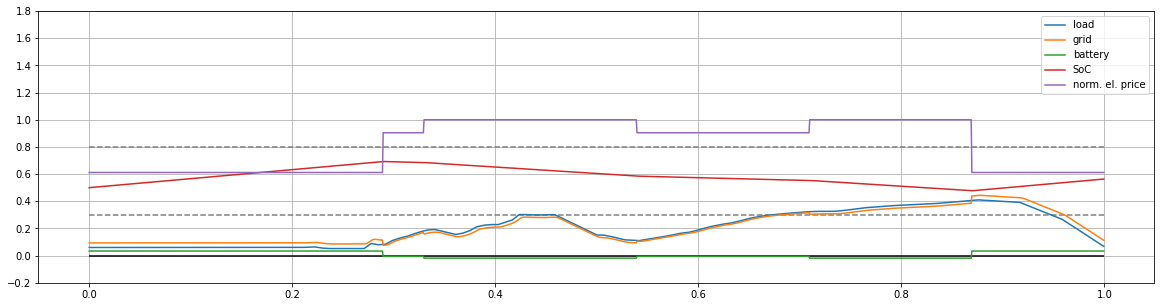

[ 0.21021359 -0.13518392]
47.70265014449959 54.99999951654709
context 0.0


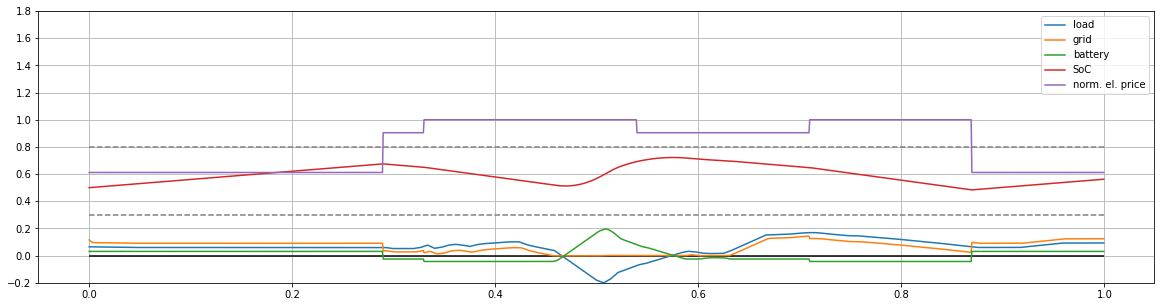

[ 0.29648565 -0.123803  ]
48.36826951180539 55.000007196481505
context 0.2377087549776856


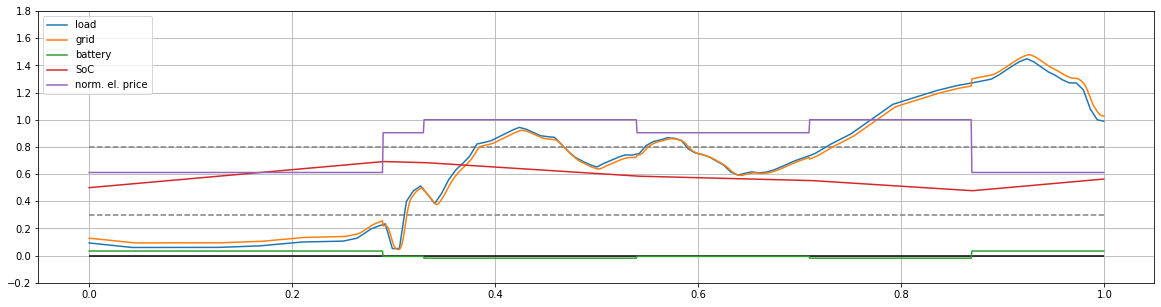

[ 0.20997674 -0.13505329]
47.71029021495915 54.99999951485597
context 0.0


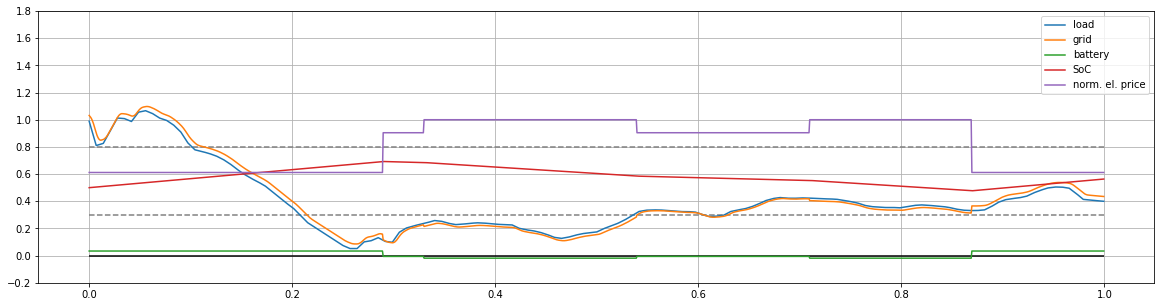

[ 0.21021354 -0.1351839 ]
47.702651594253126 54.999999516547305
context 0.0


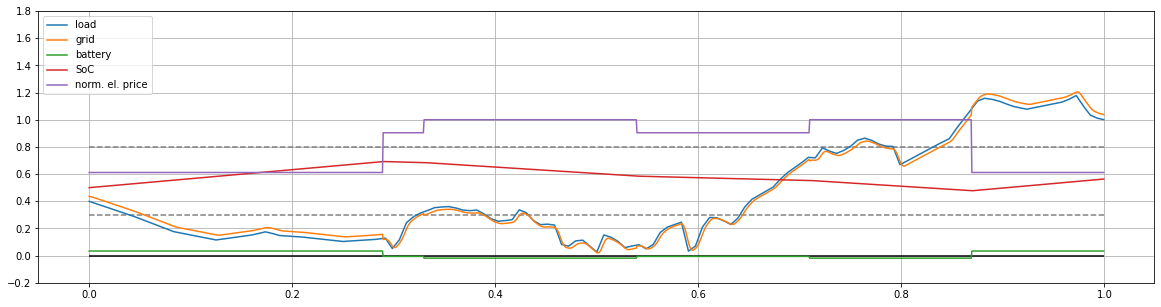

[ 0.20997812 -0.13505405]
47.710245958278215 54.999999514815755
context 0.0


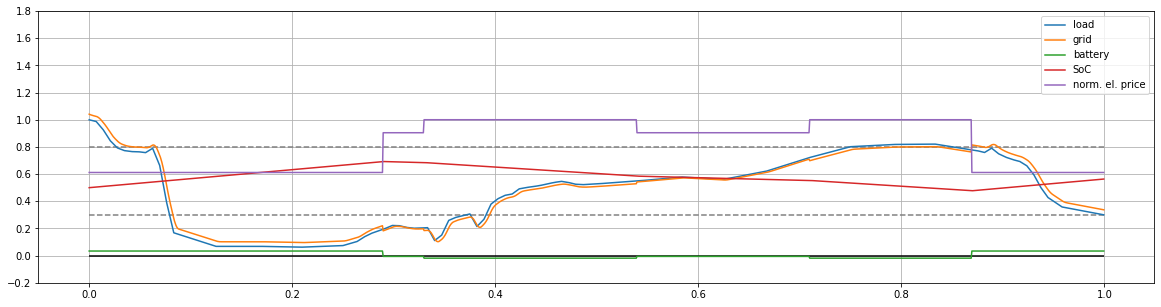

[ 0.2099771  -0.13505349]
47.71027879417995 54.999999514844795
context 0.0


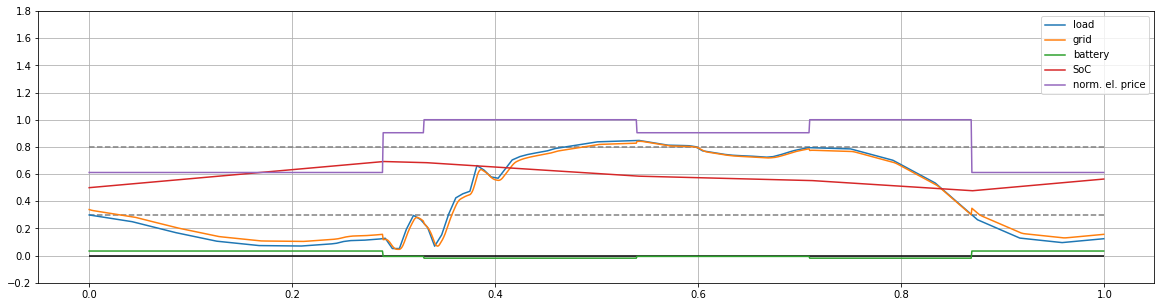

[ 0.21021529 -0.13518487]
47.70259509090883 54.99999951649631
context 0.0


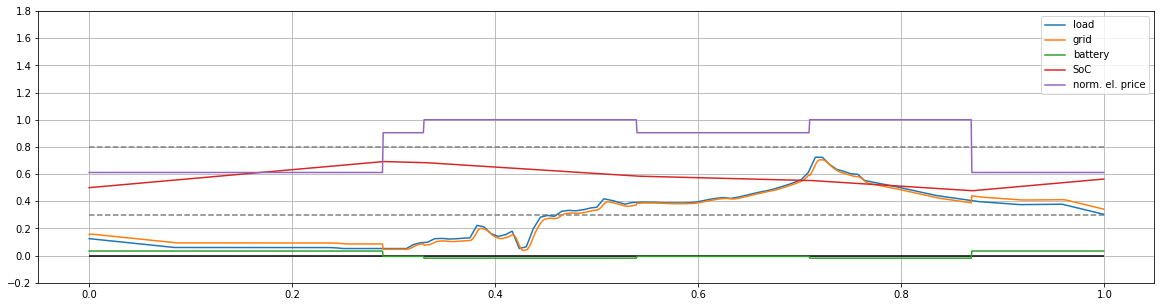

[ 0.20996097 -0.13504459]
47.710798947743385 54.9999995153131
context 0.0


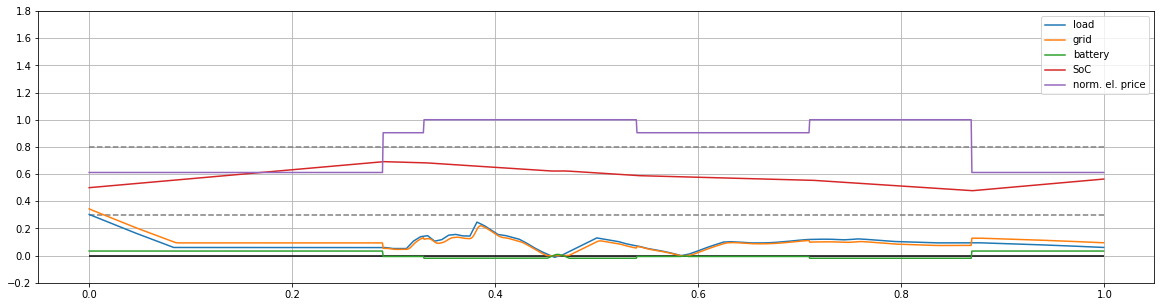

[ 0.21189437 -0.13453845]
47.740400841212114 54.999999567474745
context 0.0014453914456276


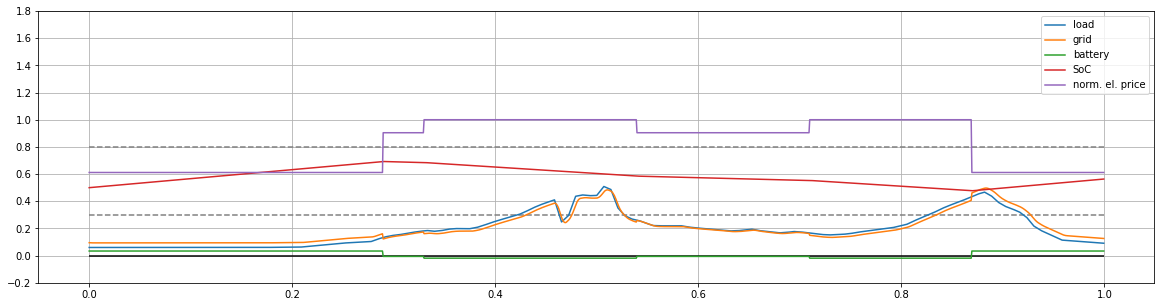

[ 0.21021475 -0.13518457]
47.70261266529119 54.999999516512574
context 0.0


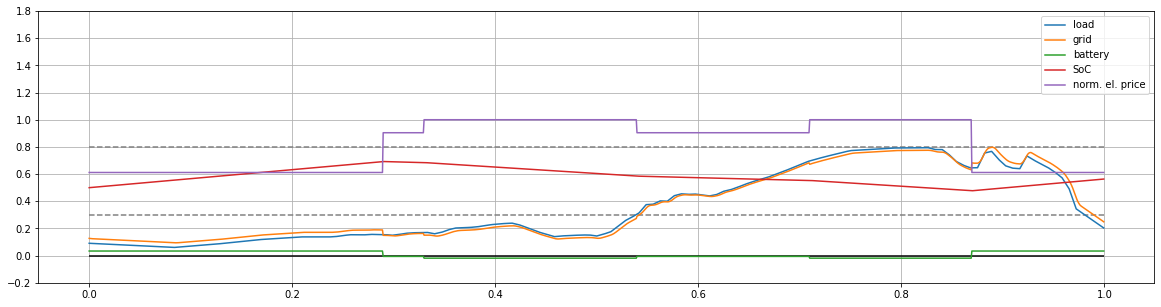

[ 0.2099771  -0.13505349]
47.71027879417995 54.999999514844795
context 0.0


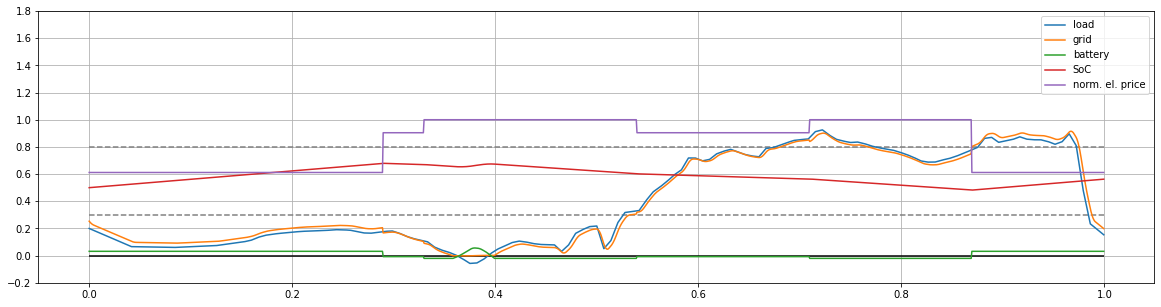

[ 0.20751226 -0.12650807]
48.21005641048683 54.999999759098124
context 0.0255798784174301


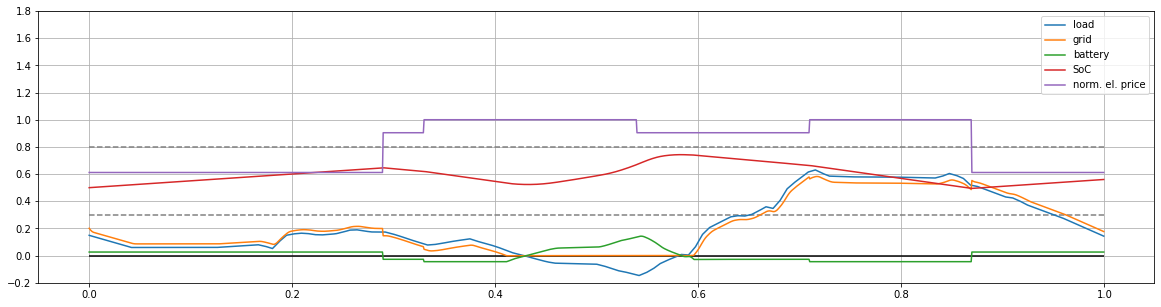

[ 0.28335306 -0.10525862]
49.452824734682906 54.999997817484335
context 0.2537785574402315


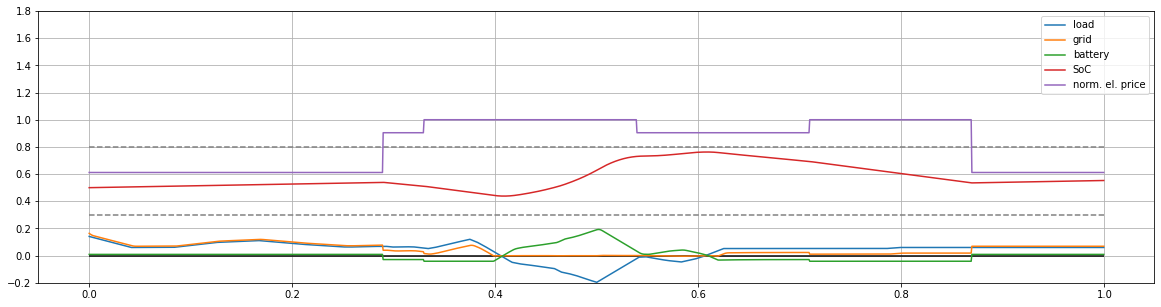

[ 0.20120858 -0.03581271]
43.807191615220056 54.9999947978866
context 0.3739482987939415


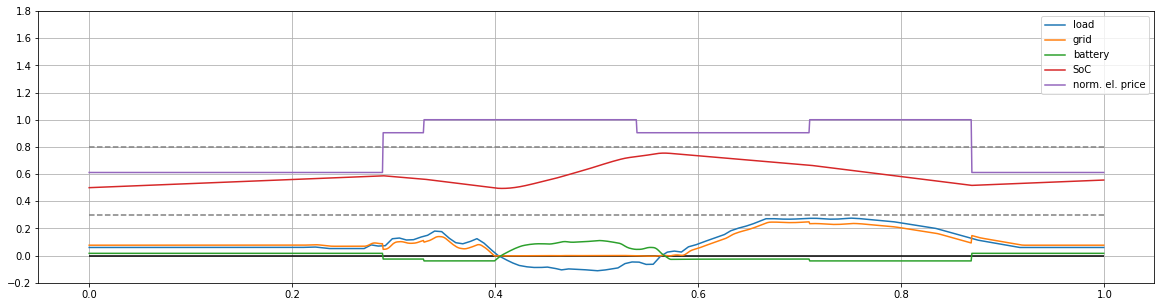

[ 0.22284403 -0.06719003]
49.452325033028195 54.999995587002694
context 0.2985864901437889


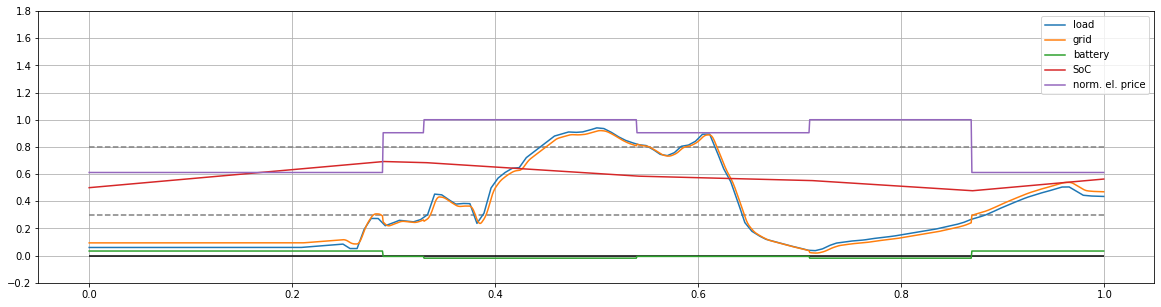

[ 0.21021335 -0.1351838 ]
47.70265764615458 54.99999951655329
context 0.0


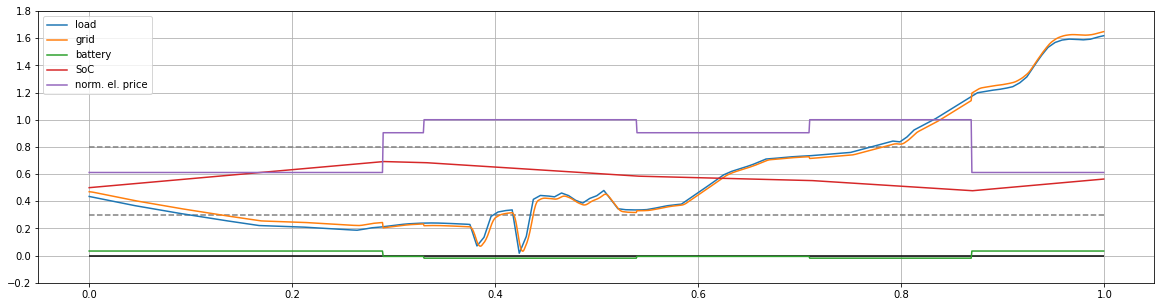

[ 0.20992156 -0.13502286]
47.71206994944246 54.99999930120386
context 0.0


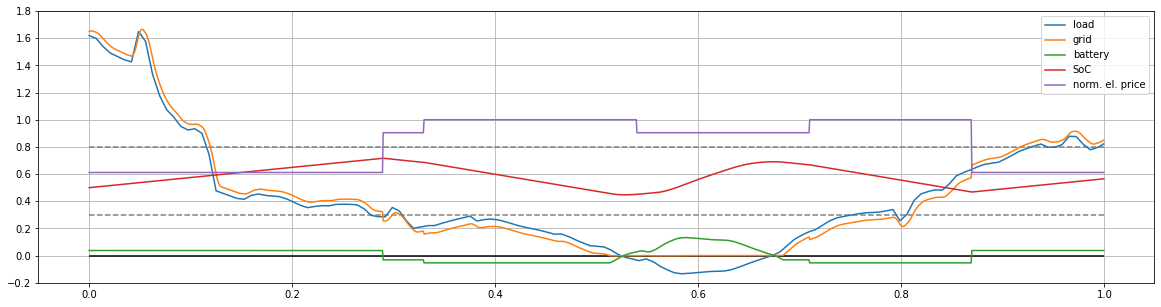

[ 0.36369126 -0.15073133]
44.73617701433985 54.99999706557465
context 0.276945862153338


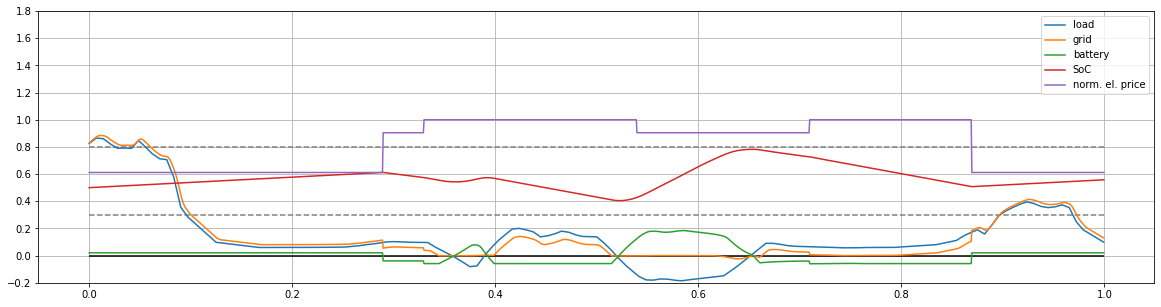

[ 0.31731444 -0.08301121]
40.4539044645011 54.99674301175325
context 0.4718704316639169


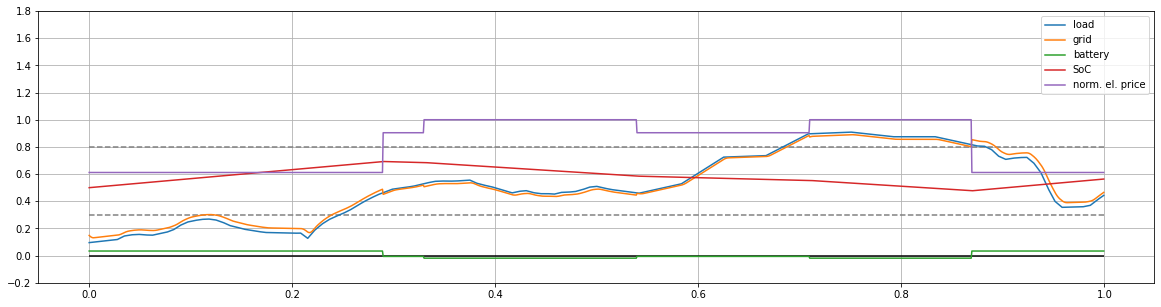

[ 0.21021354 -0.1351839 ]
47.702651594253126 54.999999516547305
context 0.0


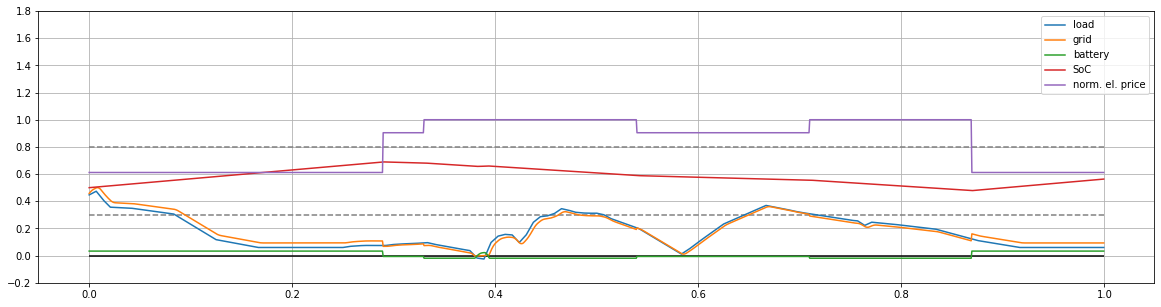

[ 0.2095587  -0.13320928]
47.81813683695788 54.999999614126594
context 0.0044785866403469


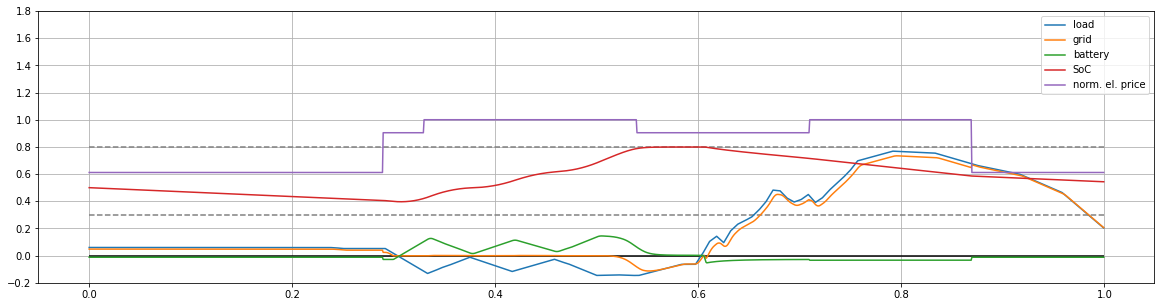

[0.08631036 0.04784594]
39.6437245987324 54.999999838736834
context 0.5


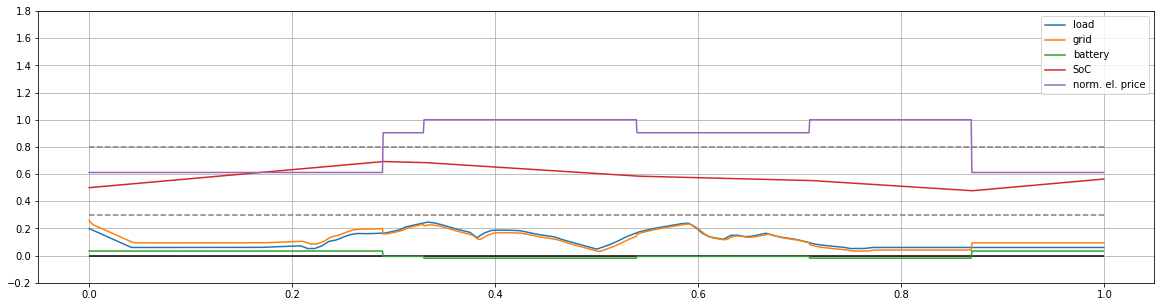

[ 0.21021634 -0.13518544]
47.70256134564098 54.999999516466126
context 0.0


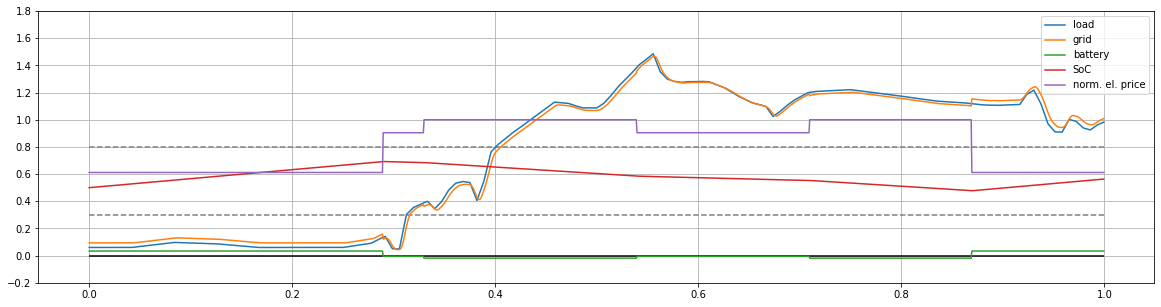

[ 0.20997581 -0.13505277]
47.7103204270628 54.99999951488535
context 0.0


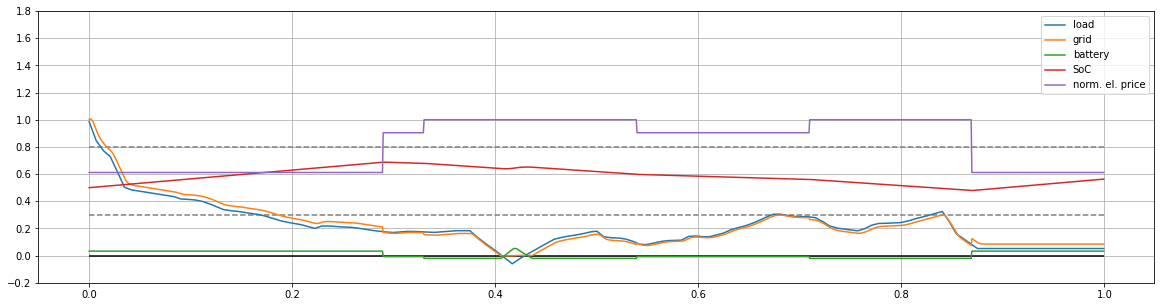

[ 0.21362889 -0.13219284]
47.87758307448134 54.99999950184636
context 0.0160385717948277


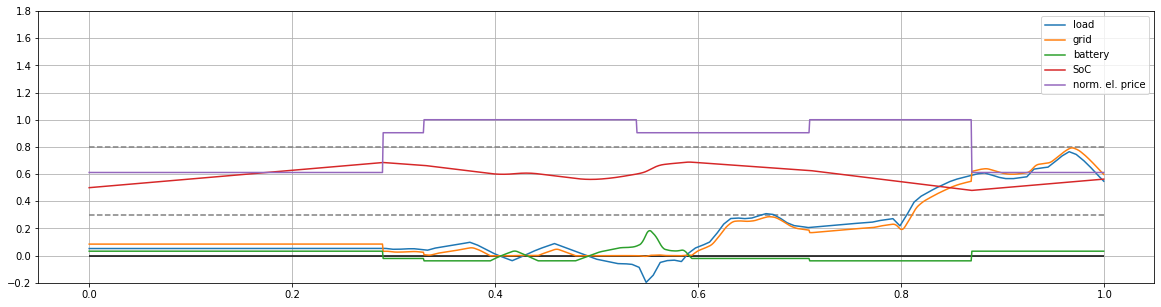

[ 0.28379321 -0.13037525]
47.983903968241144 55.000018497389654
context 0.15880149573756


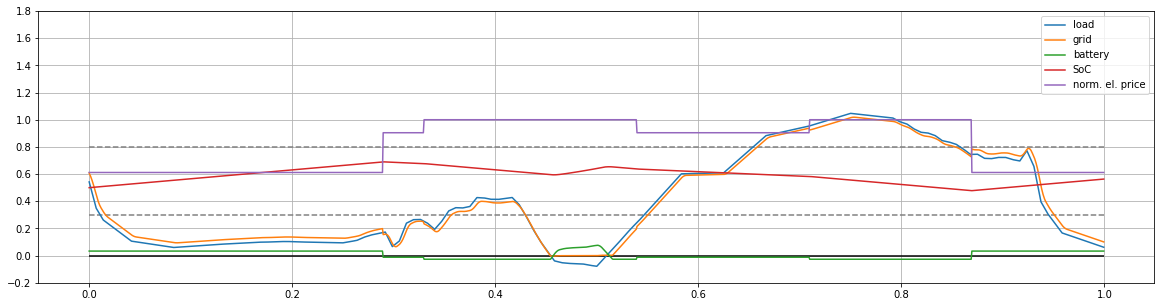

[ 0.2400415  -0.13356065]
47.797587389650076 54.99999961775122
context 0.0708024691025881


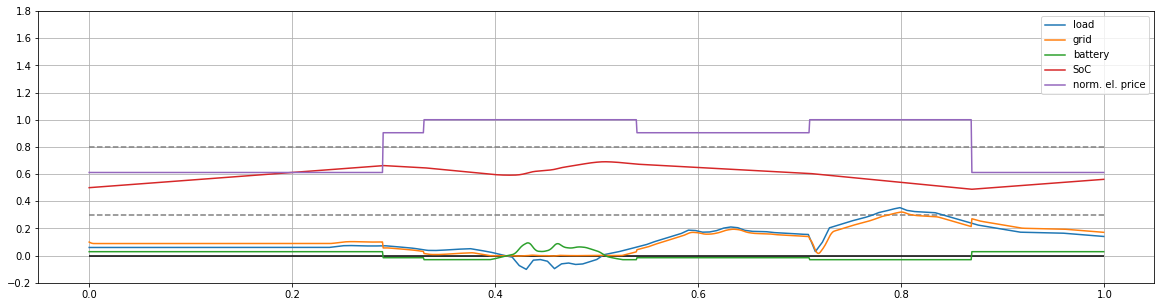

[ 0.23536042 -0.11582463]
48.83487554528779 54.99999972651682
context 0.1163194023334869


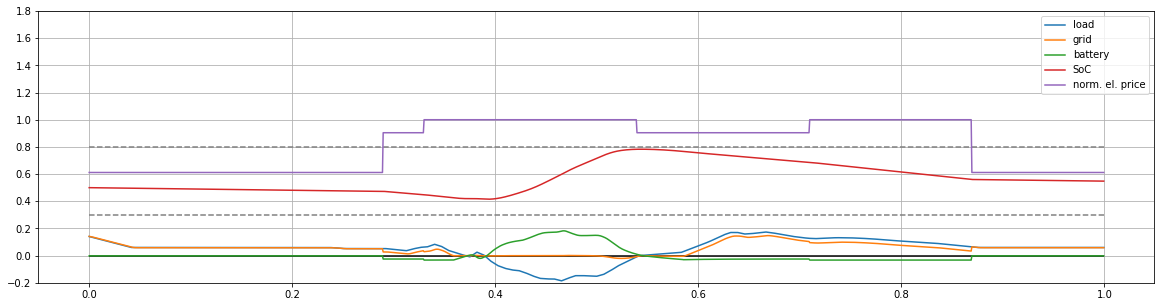

[0.12418312 0.00660767]
41.51040047270469 54.99998734399899
context 0.4276920494420402


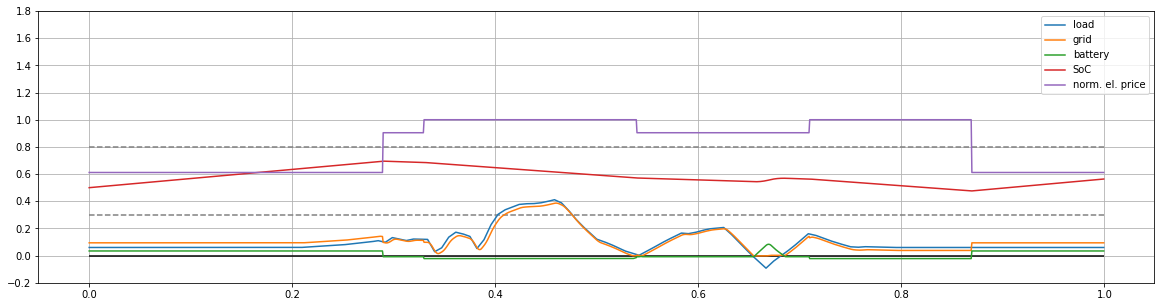

[ 0.22430734 -0.13685564]
47.604879348029634 54.999999072819804
context 0.0305467837221092


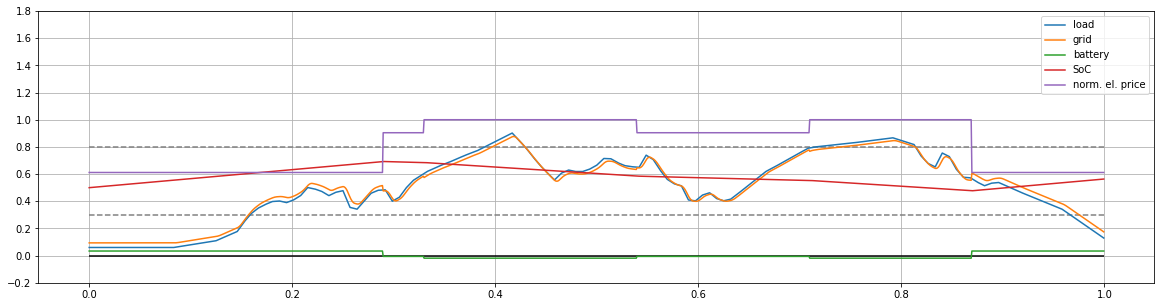

[ 0.21021354 -0.1351839 ]
47.702651594253126 54.999999516547305
context 0.0


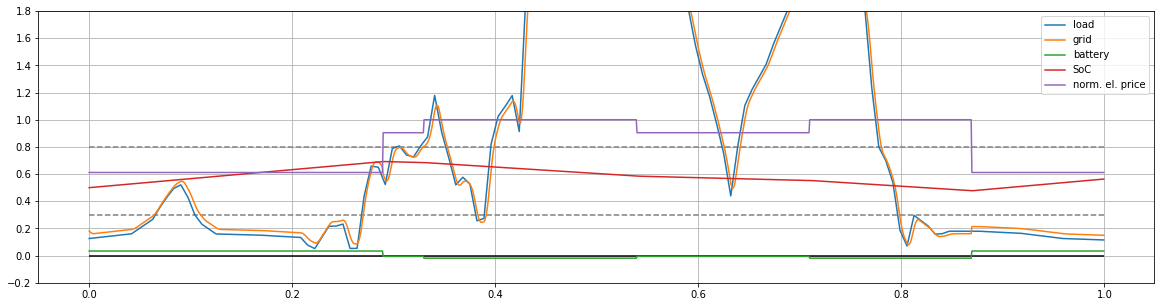

[ 0.21021448 -0.13518442]
47.70262126100501 54.999999516520674
context 0.0


[]

In [5]:
e_ch=data.e_char.asfreq('D').shift(-2)
e_dis=data.e_dis.asfreq('D').shift(-2) 
violations=[]
for d,par in enumerate(rnd_opt_par):
    c= plant_cost(par,p_load=data.power_load[d*day:],plot=True)
    if (c[3]<31.9)| (c[2]<54.9):
        violations.append(d)
        print('viol')
    print(par)
    print(c[3],c[2])
    print('context',e_ch[d])
violations

In [15]:
print(len(data)/day)
def drop_violated(df,viol_days=None,dt=1):
    data=df.copy()
    data['days']=(data.reset_index().index.values*dt/day).astype(int)
    data=data[~data.days.isin(viol_days)]
    return data
data=drop_violated(data,violations)
rnd_opt_cst=np.delete(rnd_opt_cst,violations)
rnd_opt_par=np.delete(rnd_opt_par,violations,axis=0)
len(data)/day

64.00069444444445


63.00069444444444

plant_cost(rnd_opt_par[27],p_load=data.power_load[27*day:],plot=True)


Winter rss rp_new with soc_std norm
cost: 2.53**2 * RBF(length_scale=[0.118, 0.321, 0.207]) + WhiteKernel(noise_level=0.251)
final: 0.259**2 * RBF(length_scale=[0.482, 0.259, 0.141]) + WhiteKernel(noise_level=0.000687)
safe: 0.251**2 * RBF(length_scale=[0.408, 0.184, 0.135]) + WhiteKernel(noise_level=0.000479)
    
Winter e_ch r_new soc_std norm
2.07**2 * RBF(length_scale=[0.702, 0.292, 0.144]) + WhiteKernel(noise_level=0.0378)
0.269**2 * RBF(length_scale=[2.13, 0.266, 0.149]) + WhiteKernel(noise_level=0.000643)
0.236**2 * RBF(length_scale=[0.566, 0.163, 0.118]) + WhiteKernel(noise_level=0.000276)  

cost: 1.85**2 * RBF(length_scale=[0.3, 0.355, 0.17]) + WhiteKernel(noise_level=0.05)
const: 0.281**2 * RBF(length_scale=[0.824, 0.412, 0.231]) + WhiteKernel(noise_level=0.000429)
safe: 0.206**2 * RBF(length_scale=[0.67, 0.181, 0.167]) + WhiteKernel(noise_level=0.000216)


###  RBF

In [65]:
import glob
# rss_df=data.Rss_day.asfreq('D').shift(-2) # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
e_ch=data.e_char.asfreq('D').shift(-2).dropna()
e_dis=data.e_dis.asfreq('D').shift(-2).dropna() # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
ctxt=e_ch
# paths=glob.glob('sim_data_312_winter_rp0_qf_55/hyperpar_loglike4*')
# hp=get_data(paths[-1])
hp=[3.13**2,[0.486,0.247], #cost
    0.296**2,[0.896,0.279],# const
    0.195**2,[0.161, 0.11],#safe 
    2,#beta
    0.486,0.227,0.344] #contexts lenght
Vz=hp[0]
Lz=hp[1]
Vq=hp[2]
Lq=hp[3]
Vqs=hp[4]
Lqs=hp[5]
beta=hp[6]
Lctxt_z=hp[7]
Lctxt_q=hp[8]
Lctxt_qs=hp[9]

noise_cst = 2e-1#cst_mmnt_noise.mean()/10
noise_const =5e-4
noise_safeconst =5e-4
S_f_sp=55
S_os_max=0
soc_softc=[32,80]
# opt_cost=rnd_opt_cst[0]
def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
    p_load=data[:T*day+N_lim[1]]
    x=x0
    i=0
    while True:
#         i=0 #always first day
        soc_i=50 #always same soc_i
        res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,plot_cost=False,noise=False)
        c=res[0]
        q=res[1:]  
        x,i=yield c[3],(q[1]-S_f_sp)/soc_std,(q[2]-soc_softc[0])/soc_std
        p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
#         print('day: ',i)
#         plt.plot(p_load[N_lim[1]:])
#         plt.show()
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
# parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
# Define Kernel
# for x_ in np.random.uniform(-0.5,-0.05,10):

cost_kernel_ = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
cost_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
cost_kernel=cost_kernel_*cost_context_kernel

const_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
const_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
const_kernel=const_kernel_*const_context_kernel

safeconst_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
safeconst_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

context=np.array([[ctxt[0]]])
x0=np.array([[0.,-0.5]])
x=np.hstack([x0,context])
cost=cost_g(x0.flatten())
y0= np.atleast_2d(cost.send(None))
cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)

cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
safeconst_gp_= GPy.models.GPRegression(x0,y0[:,2,None], safeconst_kernel_, noise_var=noise_safeconst)

gp=[cost_gp,const_gp,safeconst_gp]
gp_=[cost_gp_,const_gp_,safeconst_gp_]
gp__=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
gpva=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]

# The optimization routine
optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf,-np.inf], threshold=np.array([-np.inf,-np.inf,-50]),beta=beta)
opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta,num_contexts=1)
# opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
iterations=len(data)*dt//day-2

y_post=np.empty((iterations,y0.shape[1]))
x_post=np.empty((iterations,x0.shape[1]))
x_prior=np.empty((iterations,x0.shape[1]))
y_prior=[]
y_prior.append(y0.flatten())

y_post_=np.empty((iterations,y0.shape[1]))
x_post_=np.empty((iterations,x0.shape[1]))
x_prior_=np.empty((iterations,x0.shape[1]))
y_prior_=[]
y_prior_.append(y0.flatten())

y_post__=np.empty((iterations,y0.shape[1]))
x_post__=np.empty((iterations,x0.shape[1]))
x_prior__=np.empty((iterations,x0.shape[1]))
y_prior__=[]
y_prior__.append(y0.flatten())

y_postva=np.empty((iterations,y0.shape[1]))
x_postva=np.empty((iterations,x0.shape[1]))
x_priorva=np.empty((iterations,x0.shape[1]))
y_priorva=[]
y_priorva.append(y0.flatten())

for i in range(iterations):
    print(i)
    # Get optimizer for same day
    try:
        x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
        x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
        x_post__[i,:] = opt.optimize()
        x_postva[i,:] = optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]
        x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
        x_post__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]
        x_postva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]

    y_post[i,:] = cost.send((x_post[i,:].flatten(),i))
    y_post_[i,:] = cost.send((x_post_[i,:].flatten(),i))
    y_post__[i,:] = cost.send((x_post__[i,:].flatten(),i))
    y_postva[i,:] = cost.send((x_postva[i,:].flatten(),i))    

#     if y_post[i,1]<-1e-1:
#         print('Constraint violated',-soc_std*y_post[i,1],y_post[i,1])
#         break
    # Get context of next day
    context=np.array([ctxt[i+1]])
    print('context= ',context)
    try:
        x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
        x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
        x_prior__[i,:] =  opt.optimize(ucb=False)
        x_priorva[i,:] =  optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
        x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
        x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
        x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]            

    y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))
    y_prior_.append(cost.send((x_prior_[i,:].flatten(),i+1)))
    y_prior__.append(cost.send((x_prior__[i,:].flatten(),i+1)))    
    y_priorva.append(cost.send((x_priorva[i,:].flatten(),i+1)))    


    print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
    opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
    opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
    opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
    optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 

    print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
y_prior=np.array(y_prior[:-1])
y_prior_=np.array(y_prior_[:-1])
y_prior__=np.array(y_prior__[:-1])
y_priorva=np.array(y_priorva[:-1])

# err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
# print(np.abs(err).sum()/(iterations-10))

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.22110553 -0.53768844] [-7.38057822  0.49911206  0.95848245]
current max estiamte ucb=  (array([ 0.60301508, -0.72864322]), -1.7222433628019171)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.40201005 -0.59798995] [-6.95517072  0.49920233  0.95752532]
current max estiamte ucb=  (array([ 0.8040201 , -0.79899497]), -1.5028878509793635)
2
context=  [0.]
opt parameter and cost:  [ 0.60301508 -0.65829146] [-5.98651202  0.49927592  0.95152921]
current max estiamte ucb=  (array([ 0.98492462, -0.86934673]), -1.3553650865868285)
3
context=  [0.]
opt parameter and cost:  [ 0.7839196  -0.72864322] [-4.62200038  0.499345    0.21345992]
current max estiamte ucb=  (array([ 0.94472362, -0.43718593]), -1.7575945665318682)
4
context=  [0.]
opt parameter and cost:  [ 0.60

current max estiamte ucb=  (array([ 0.30150754, -0.2160804 ]), -2.034457037702962)
42
context=  [0.]
opt parameter and cost:  [ 0.08040201 -1.        ] [-7.2468288   0.49952454  0.95761188]
current max estiamte ucb=  (array([ 0.30150754, -0.2160804 ]), -2.1087787836168648)
43
context=  [0.]
opt parameter and cost:  [ 0.58291457 -0.43718593] [-3.25387709  0.46404856  0.01955664]
current max estiamte ucb=  (array([ 0.30150754, -0.2160804 ]), -2.099927897685308)
44
context=  [0.27694586]
opt parameter and cost:  [ 0.58291457 -0.43718593] [-3.18888431  0.46404856  0.01955664]
current max estiamte ucb=  (array([ 0.30150754, -0.2160804 ]), -1.9881012707130972)
45
context=  [0.47187043]
opt parameter and cost:  [ 0.7638191  -0.63819095] [-2.58919995  0.49893138  0.05808368]
current max estiamte ucb=  (array([ 0.34170854, -0.18592965]), -2.157425526258261)
46
context=  [0.]
opt parameter and cost:  [ 0.74371859 -0.65829146] [-3.42719554  0.49924891  0.14576508]
current max estiamte ucb=  (arra

### Matern3/2

In [34]:
# 5.8**2 * Matern(length_scale=[2.45, 1.9, 1.12], nu=1.5) + WhiteKernel(noise_level=0.0477)
# 0.269**2 * Matern(length_scale=[1.35, 0.95, 0.478], nu=1.5) + WhiteKernel(noise_level=2.25e-08)
# 0.251**2 * Matern(length_scale=[0.841, 0.59, 0.38], nu=1.5) + WhiteKernel(noise_level=2.4e-05)
hp=[5.8**2,[1.9,1.12], #cost
    0.27**2,[0.95,0.478],# const
    0.25**2,[0.59, 0.38],#safe 
    2,#beta
    2.45,1.35,0.841] #contexts lenght

In [35]:
import glob
# rss_df=data.Rss_day.asfreq('D').shift(-2) # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
e_ch=data.e_char.asfreq('D').shift(-2).dropna()
e_dis=data.e_dis.asfreq('D').shift(-2).dropna() # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
ctxt=e_ch
# paths=glob.glob('sim_data_312_winter_rp0_qf_55/hyperpar_loglike4*')
# hp=get_data(paths[-1])
Vz=hp[0]
Lz=hp[1]
Vq=hp[2]
Lq=hp[3]
Vqs=hp[4]
Lqs=hp[5]
beta=hp[6]
Lctxt_z=hp[7]
Lctxt_q=hp[8]
Lctxt_qs=hp[9]

noise_cst = 4e-1#cst_mmnt_noise.mean()/10
noise_const =2e-8
noise_safeconst =2.4e-5
S_f_sp=55
S_os_max=0
soc_softc=[32,80]
# opt_cost=rnd_opt_cst[0]
def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
    p_load=data[:T*day+N_lim[1]]
    x=x0
    i=0
    while True:
#         i=0 #always first day
        soc_i=50 #always same soc_i
        res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,plot_cost=False,noise=False)
        c=res[0]
        q=res[1:]  
        x,i=yield c[3],(q[1]-S_f_sp)/soc_std,(q[2]-soc_softc[0])/soc_std
        p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
#         print('day: ',i)
#         plt.plot(p_load[N_lim[1]:])
#         plt.show()
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
# parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
# Define Kernel
# for x_ in np.random.uniform(-0.5,-0.05,10):

cost_kernel_ = GPy.kern.Matern32(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
cost_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
cost_kernel=cost_kernel_*cost_context_kernel

const_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
const_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
const_kernel=const_kernel_*const_context_kernel

safeconst_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
safeconst_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

context=np.array([[ctxt[0]]])
x0=np.array([[0.,-0.5]])
x=np.hstack([x0,context])
cost=cost_g(x0.flatten())
y0= np.atleast_2d(cost.send(None))
cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)

cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
safeconst_gp_= GPy.models.GPRegression(x0,y0[:,2,None], safeconst_kernel_, noise_var=noise_safeconst)

gp=[cost_gp,const_gp,safeconst_gp]
gp_=[cost_gp_,const_gp_,safeconst_gp_]
gp__=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
gpva=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]

# The optimization routine
optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf,-np.inf], threshold=np.array([-np.inf,-np.inf,-50]),beta=beta)
opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta,num_contexts=1)
# opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
iterations=len(data)*dt//day-2

y_post=np.empty((iterations,y0.shape[1]))
x_post=np.empty((iterations,x0.shape[1]))
x_prior=np.empty((iterations,x0.shape[1]))
y_prior=[]
y_prior.append(y0.flatten())

y_post_=np.empty((iterations,y0.shape[1]))
x_post_=np.empty((iterations,x0.shape[1]))
x_prior_=np.empty((iterations,x0.shape[1]))
y_prior_=[]
y_prior_.append(y0.flatten())

y_post__=np.empty((iterations,y0.shape[1]))
x_post__=np.empty((iterations,x0.shape[1]))
x_prior__=np.empty((iterations,x0.shape[1]))
y_prior__=[]
y_prior__.append(y0.flatten())

y_postva=np.empty((iterations,y0.shape[1]))
x_postva=np.empty((iterations,x0.shape[1]))
x_priorva=np.empty((iterations,x0.shape[1]))
y_priorva=[]
y_priorva.append(y0.flatten())

for i in range(iterations):
    print(i)
    # Get optimizer for same day
    try:
        x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
        x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
        x_post__[i,:] = opt.optimize()
        x_postva[i,:] = optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]
        x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
        x_post__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]
        x_postva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]

    y_post[i,:] = cost.send((x_post[i,:].flatten(),i))
    y_post_[i,:] = cost.send((x_post_[i,:].flatten(),i))
    y_post__[i,:] = cost.send((x_post__[i,:].flatten(),i))
    y_postva[i,:] = cost.send((x_postva[i,:].flatten(),i))    

#     if y_post[i,1]<-1e-1:
#         print('Constraint violated',-soc_std*y_post[i,1],y_post[i,1])
#         break
    # Get context of next day
    context=np.array([ctxt[i+1]])
    print('context= ',context)
    try:
        x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
        x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
        x_prior__[i,:] =  opt.optimize(ucb=False)
        x_priorva[i,:] =  optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
        x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
        x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
        x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]            

    y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))
    y_prior_.append(cost.send((x_prior_[i,:].flatten(),i+1)))
    y_prior__.append(cost.send((x_prior__[i,:].flatten(),i+1)))    
    y_priorva.append(cost.send((x_priorva[i,:].flatten(),i+1)))    


    print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
    opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
    opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
    opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
    optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 

    print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
y_prior=np.array(y_prior[:-1])
y_prior_=np.array(y_prior_[:-1])
y_prior__=np.array(y_prior__[:-1])
y_priorva=np.array(y_priorva[:-1])

# err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
# print(np.abs(err).sum()/(iterations-10))

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.16080402 -0.51758794] [-5.26616004  0.49907728  0.95865577]
current max estiamte ucb=  (array([ 0.66331658, -0.69849246]), -1.3701655334066714, -0.23164005300967683)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.32160804 -0.50753769] [-5.26018977  0.49905881  0.95738834]
current max estiamte ucb=  (array([ 0.8241206 , -0.69849246]), -1.3643577207046622, -0.22361407192179972)
2
context=  [0.]
opt parameter and cost:  [ 0.48241206 -0.51758794] [-5.14377882  0.49907715  0.94897182]
current max estiamte ucb=  (array([ 0.98492462, -0.70854271]), -1.3713099532937543, -0.23131386122720887)
3
context=  [0.]
opt parameter and cost:  [ 0.64321608 -0.50753769] [-3.14039117  0.47118753  0.46195906]
current max estiamte ucb=  (array([ 1.02512563, -0.45728643]), -1.

opt parameter and cost:  [ 0.66331658 -0.44723618] [1.47298655 0.01666275 0.03210189]
current max estiamte ucb=  (array([ 0.62311558, -0.40703518]), 1.817424411089796, 1.884280867693839)
39
context=  [0.]
opt parameter and cost:  [ 0.7839196  -0.71859296] [-4.52819167  0.49933697  0.79613139]
current max estiamte ucb=  (array([ 0.62311558, -0.40703518]), 1.8280045758735797, 1.8948652277382607)
40
context=  [0.02557988]
opt parameter and cost:  [ 0.88442211 -0.74874372] [-3.37090326  0.4993335   0.53547159]
current max estiamte ucb=  (array([ 0.60301508, -0.37688442]), 2.35341347773333, 2.4631332012719724)
41
context=  [0.25377856]
opt parameter and cost:  [ 0.60301508 -0.38693467] [ 2.18655596 -0.06182093  0.00950008]
current max estiamte ucb=  (array([ 0.70351759, -0.37688442]), 1.824213838438129, 2.016399418936289)
42
context=  [0.3739483]
opt parameter and cost:  [ 0.68341709 -0.37688442] [1.66210314 0.17452884 0.26681468]
current max estiamte ucb=  (array([ 0.94472362, -0.51758794]

###  Kernel mix

In [ ]:
import glob
# rss_df=data.Rss_day.asfreq('D').shift(-2) # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
e_ch=data.e_char.asfreq('D').shift(-2).dropna()
e_dis=data.e_dis.asfreq('D').shift(-2).dropna() # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
ctxt=e_ch
paths=glob.glob('sim_data_312_winter_rp0_qf_55/hyperpar_loglike1_b1__2022_03_08_0409*')
hp=get_data(paths[-1])

Vz=hp[0]
Lz=hp[1]
Vq=hp[2]
Lq=hp[3]
Vqs=hp[4]=0.25**2
Lqs=hp[5]=[0.184,0.135]
beta=hp[6]
Lctxt_z=hp[7]
Lctxt_q=hp[8]
Lctxt_qs=hp[9]=0.841

noise_cst = 2e-1#cst_mmnt_noise.mean()/10
noise_const =5e-4
noise_safeconst =2.4e-5
S_f_sp=55
S_os_max=0
soc_softc=[32,80]
# opt_cost=rnd_opt_cst[0]
def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
    p_load=data[:T*day+N_lim[1]]
    x=x0
    i=0
    while True:
#         i=0 #always first day
        soc_i=50 #always same soc_i
        res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,plot_cost=False,noise=False)
        c=res[0]
        q=res[1:]  
        x,i=yield c[3],(q[1]-S_f_sp)/soc_std,(q[2]-soc_softc[0])/soc_std
        p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
#         print('day: ',i)
#         plt.plot(p_load[N_lim[1]:])
#         plt.show()
bounds = [(0., 4.),(-1,1)]
parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
# parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
# Define Kernel
# for x_ in np.random.uniform(-0.5,-0.05,10):

cost_kernel_ = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
cost_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
cost_kernel=cost_kernel_*cost_context_kernel

const_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
const_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
const_kernel=const_kernel_*const_context_kernel

safeconst_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
safeconst_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

context=np.array([[ctxt[0]]])
x0=np.array([[0.,-0.5]])
x=np.hstack([x0,context])
cost=cost_g(x0.flatten())
y0= np.atleast_2d(cost.send(None))
cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)

cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
safeconst_gp_= GPy.models.GPRegression(x0,y0[:,2,None], safeconst_kernel_, noise_var=noise_safeconst)

gp=[cost_gp,const_gp,safeconst_gp]
gp_=[cost_gp_,const_gp_,safeconst_gp_]
gp__=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
gpva=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]

# The optimization routine
optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf,-np.inf], threshold=np.array([-np.inf,-np.inf,-50]),beta=beta)
opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta,num_contexts=1)
# opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
iterations=len(data)*dt//day-2

y_post=np.empty((iterations,y0.shape[1]))
x_post=np.empty((iterations,x0.shape[1]))
x_prior=np.empty((iterations,x0.shape[1]))
y_prior=[]
y_prior.append(y0.flatten())

y_post_=np.empty((iterations,y0.shape[1]))
x_post_=np.empty((iterations,x0.shape[1]))
x_prior_=np.empty((iterations,x0.shape[1]))
y_prior_=[]
y_prior_.append(y0.flatten())

y_post__=np.empty((iterations,y0.shape[1]))
x_post__=np.empty((iterations,x0.shape[1]))
x_prior__=np.empty((iterations,x0.shape[1]))
y_prior__=[]
y_prior__.append(y0.flatten())

y_postva=np.empty((iterations,y0.shape[1]))
x_postva=np.empty((iterations,x0.shape[1]))
x_priorva=np.empty((iterations,x0.shape[1]))
y_priorva=[]
y_priorva.append(y0.flatten())

for i in range(iterations):
    print(i)
    # Get optimizer for same day
    try:
        x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
        x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
        x_post__[i,:] = opt.optimize()
        x_postva[i,:] = optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]
        x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
        x_post__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]
        x_postva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]

    y_post[i,:] = cost.send((x_post[i,:].flatten(),i))
    y_post_[i,:] = cost.send((x_post_[i,:].flatten(),i))
    y_post__[i,:] = cost.send((x_post__[i,:].flatten(),i))
    y_postva[i,:] = cost.send((x_postva[i,:].flatten(),i))    

#     if y_post[i,1]<-1e-1:
#         print('Constraint violated',-soc_std*y_post[i,1],y_post[i,1])
#         break
    # Get context of next day
    context=np.array([ctxt[i+1]])
    print('context= ',context)
    try:
        x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
        x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
        x_prior__[i,:] =  opt.optimize(ucb=False)
        x_priorva[i,:] =  optva.optimize(ucb=True)

    except EnvironmentError as e:
        print(e)
        x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
        x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
        x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
        x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]            

    y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))
    y_prior_.append(cost.send((x_prior_[i,:].flatten(),i+1)))
    y_prior__.append(cost.send((x_prior__[i,:].flatten(),i+1)))    
    y_priorva.append(cost.send((x_priorva[i,:].flatten(),i+1)))    


    print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
    opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
    opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
    opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
    optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 

    print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
y_prior=np.array(y_prior[:-1])
y_prior_=np.array(y_prior_[:-1])
y_prior__=np.array(y_prior__[:-1])
y_priorva=np.array(y_priorva[:-1])

# err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
# print(np.abs(err).sum()/(iterations-10))

This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.16080402 -0.51758794] [-5.26616004  0.49907728  0.95865577]
current max estiamte ucb=  (array([ 0.66331658, -0.69849246]), -1.3726826931985205, -0.2344446468823368)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.32160804 -0.51758794] [-5.26066264  0.49907726  0.95752545]
current max estiamte ucb=  (array([ 0.8241206 , -0.70854271]), -1.3724850581053518, -0.2323760860329075)
2
context=  [0.]
opt parameter and cost:  [ 0.48241206 -0.52763819] [-5.15520271  0.49909493  0.94985068]
current max estiamte ucb=  (array([ 0.98492462, -0.71859296]), -1.3773789957312657, -0.2376572176541013)
3
context=  [0.]
opt parameter and cost:  [ 0.64321608 -0.51758794] [-3.34267399  0.4891827   0.5078751 ]
current max estiamte ucb=  (array([ 1.06532663, -0.51758794]), -1.076

context=  [0.00144539]
opt parameter and cost:  [ 1.20603015 -0.86934673] [-1.38764439  0.38950748 -0.04136458]
current max estiamte ucb=  (array([ 0.68341709, -0.46733668]), 1.270754322266802, 1.350327919680449)
39
context=  [0.]
opt parameter and cost:  [ 0.86432161 -0.65829146] [-2.05214148  0.41099484  0.22496022]
current max estiamte ucb=  (array([ 0.68341709, -0.46733668]), 1.2718867562202831, 1.3513679647999037)
40
context=  [0.02557988]
opt parameter and cost:  [ 0.68341709 -0.47738693] [0.60523573 0.10108591 0.09139924]
current max estiamte ucb=  (array([ 0.72361809, -0.47738693]), 1.2791135443445283, 1.3624481638638999)
41
context=  [0.25377856]


### Plot and save


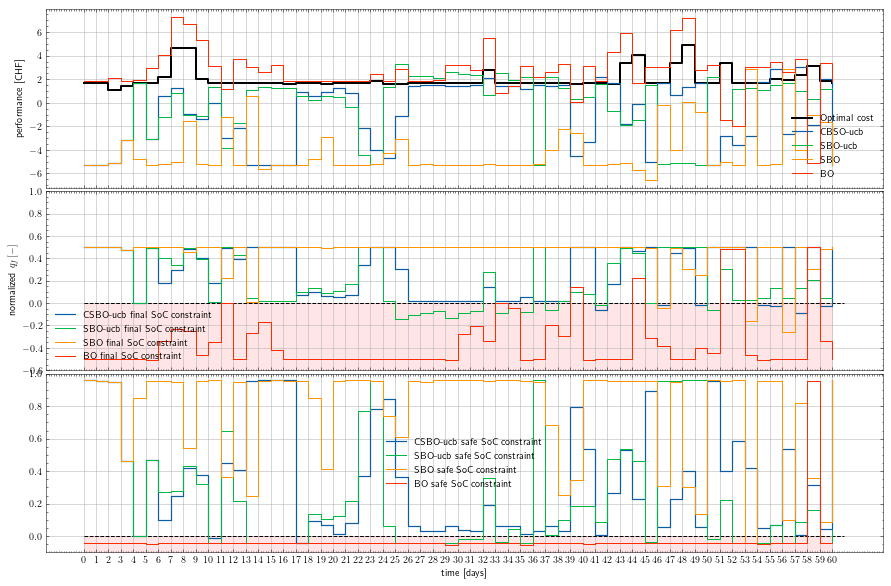

In [37]:
# mpl.rcParams['text.usetex']=True

with plt.style.context('science'):
    err=25e-2
    # plt.step(range(iterations),best_constrained_value(y_meas),where='post',label='SafeOpt')
    fig,ax=plt.subplots(3,sharex=True,figsize=(15,10))
    ax[0].step(range(iterations),-rnd_opt_cst[:iterations],where='post',label='Optimal cost',color='black',linewidth=2)
    ax[0].step(range(iterations),y_post[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
    ax[0].step(range(iterations),y_post_[:,0],where='post',label='SBO-ucb')
    ax[0].step(range(iterations),y_post__[:,0],where='post',label='SBO')
    ax[0].step(range(iterations),y_postva[:,0],where='post',label='BO')
    
#     ax[0].step(range(iterations),y_post[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
#     ax[0].step(range(iterations),y_post_[:,0],where='post',label='SBO-ucb')
#     ax[0].step(range(iterations),y_post__[:,0],where='post',label='SBO')
#     ax[0].step(range(iterations),y_postva[:,0],where='post',label='BO')


    # ax[0].step(range(iterations),y_prior_[:,0],where='post',label='prior SO-ucb')
    # ax[0].step(range(iterations),y_prior_[:,0],where='post',label='prior SO-ucb')
    # ax[0].step(range(iterations),y_prior[:,0],where='post',label='prior CSO-ucb')

    # plt.hlines(opt_cost,0,iterations,'k',linestyles='--')
#     ax[0].fill_between(range(iterations),y1=-rnd_opt_cst[:iterations].flatten(),y2=-(1-err)*rnd_opt_cst[:iterations].flatten(),alpha=0.5,step='post')
    # plt.plot(range(iterations),y_meas[:,0],'--')
    ax[0].set_xticks(np.arange(0,iterations,1))
    ax[0].set_ylabel('performance [CHF]')
    ax[0].legend()

    # plt.step(range(iterations),-y_meas[:,1],where='post',label='SafeOpt')
    ax[1].step(range(iterations),y_post[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
    ax[1].step(range(iterations),y_post_[:,1],where='post',label='SBO-ucb final SoC constraint')
    ax[1].step(range(iterations),y_post__[:,1],where='post',label='SBO final SoC constraint')
    ax[1].step(range(iterations),y_postva[:,1],where='post',label='BO final SoC constraint')
    ax[1].hlines(-S_os_max,0,iterations,'k',linestyles='--')
    ax[1].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)

#     ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
#     ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SBO-ucb final SoC constraint')
#     ax[1].step(range(iterations),y_prior__[:,1],where='post',label='SBO final SoC constraint')
#     ax[1].step(range(iterations),y_priorva[:,1],where='post',label='BO final SoC constraint')
    
    # ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SO prior final SoC constraint')
    # ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSO prior final SoC constraint')
    ax[1].set_ylim([-0.6,1])
    ax[1].set_ylabel(r'normalized $q_f [-]$')
    ax[1].legend()

    ax[2].step(range(iterations),y_post[:,2],where='post',label='CSBO-ucb safe SoC constraint',linewidth=1.2)
    ax[2].step(range(iterations),y_post_[:,2],where='post',label='SBO-ucb safe SoC constraint')
    ax[2].step(range(iterations),y_post__[:,2],where='post',label='SBO safe SoC constraint')
    ax[2].step(range(iterations),y_postva[:,2],where='post',label='BO safe SoC constraint')
    ax[2].hlines(-S_os_max,0,iterations,'k',linestyles='--')
    ax[2].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
    ax[2].set_ylim([-0.1,1])
    ax[2].legend()
    plt.xlabel('time [days]')
#     plt.xlim([0,30])
    plt.subplots_adjust(hspace=0.02)
#     plt.savefig('0.5RBC312_rp_b0_qf_55_beta_2_hp2.png')
plt.show()

In [41]:
save_data(e_ch,'ech_winter',folder='msim_data_312_winter_rp0_qf_55')

sim_data_312_winter_rp0_qf_55/ech_winter_2022_03_08_0707


0

In [38]:
name='mtrn1_b2_'
optype='CSBO'
sim_dir='sim_data_312_winter_rp0_qf_55_qs_32_mtrn/'
save_data(x_post,'x_post_'+name+optype,folder=sim_dir)
save_data(y_post,'y_post_'+name+optype,folder=sim_dir)
save_data(x_prior,'x_prior_'+name+optype,folder=sim_dir)
save_data(y_prior,'y_prior_'+name+optype,folder=sim_dir)
optype='SBO'
save_data(x_post_,'x_post_'+name+optype,folder=sim_dir)
save_data(y_post_,'y_post_'+name+optype,folder=sim_dir)
save_data(x_prior_,'x_prior_'+name+optype,folder=sim_dir)
save_data(y_prior_,'y_prior_'+name+optype,folder=sim_dir)
optype='SBOb'
save_data(x_post__,'x_post_'+name+optype,folder=sim_dir)
save_data(y_post__,'y_post_'+name+optype,folder=sim_dir)
save_data(x_prior__,'x_prior_'+name+optype,folder=sim_dir)
save_data(y_prior__,'y_prior_'+name+optype,folder=sim_dir)
optype='BO'
save_data(x_postva,'x_post_'+name+optype,folder=sim_dir)
save_data(y_postva,'y_post_'+name+optype,folder=sim_dir)
save_data(x_priorva,'x_prior_'+name+optype,folder=sim_dir)
save_data(y_priorva,'y_prior_'+name+optype,folder=sim_dir)

save_data(hp,'hyperpar_'+name,folder=sim_dir)
save_data(opt_ucb.gps,'CSBO_'+name,folder=sim_dir,pick=True,npy=False)

sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_post_mtrn1_b2_CSBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_post_mtrn1_b2_CSBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_prior_mtrn1_b2_CSBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_prior_mtrn1_b2_CSBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_post_mtrn1_b2_SBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_post_mtrn1_b2_SBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_prior_mtrn1_b2_SBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_prior_mtrn1_b2_SBO_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_post_mtrn1_b2_SBOb_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_post_mtrn1_b2_SBOb_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_prior_mtrn1_b2_SBOb_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/y_prior_mtrn1_b2_SBOb_2022_03_20_0049
sim_data_312_winter_rp0_qf_55_qs_32_mtrn/x_post_mtrn1_b2_BO_20

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0

In [41]:
file_paths[0].split('_')

['hyperpar', 'loglike4', 'b1', '', '2022', '03', '08', '0445.npy']

In [42]:
import glob 
paths=glob.glob('sim_data_312_winter_rp0_qf_55/hyperpar_loglike*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[2].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))
    else:
        betas[i]=float(beta) # convert to float and add . to 05

hps=[file_path.split('_')[1] for file_path in file_paths] # get optypes 
# dates=[file_path[-19:-4] for file_path in file_paths] # get betas


get_data('sim_data_312_winter_rp0_qf_55/CSBO_loglike1_b1_BO_2022_03_08_0409',pick=True)

# Batch optimization

### RBF

In [ ]:
3.63**2 * RBF(length_scale=[0.633, 0.871, 0.385]) + WhiteKernel(noise_level=0.0994)

3.68**2 * RBF(length_scale=[0.0871, 0.628, 0.291]) + WhiteKernel(noise_level=0.0808)

0.277**2 * RBF(length_scale=[0.405, 0.267, 0.0938]) + WhiteKernel(noise_level=2.91e-08)
(75000, 3)
(711, 3) (711,)
0.219**2 * RBF(length_scale=[50, 0.245, 0.242]) + WhiteKernel(noise_level=0.000646)

In [7]:
print(get_data('sim_data_312_winter_rp0_qf_55/hyperpar_loglike1_b05__2022_03_08_0421.npy'))
print(get_data('sim_data_312_winter_rp0_qf_55/hyperpar_loglike2_b05__2022_03_07_2357.npy'))
print(get_data('sim_data_312_winter_rp0_qf_55/hyperpar_loglike3_b05__2022_03_08_0343.npy'))
print(get_data('sim_data_312_winter_rp0_qf_55/hyperpar_loglike4_b05__2022_03_08_0442.npy'))

[4.2848999999999995 list([0.292, 0.144]) 0.04000000000000001
 list([0.266, 0.149]) 0.0625 list([0.163, 0.118]) 0.5 0.7 2.13 0.566]
[3.4225000000000003 list([0.355, 0.17]) 0.07896100000000002
 list([0.412, 0.231]) 0.042435999999999995 list([0.181, 0.167]) 0.5 0.3
 0.824 0.67]
[3.4225000000000003 list([0.355, 0.17]) 0.04000000000000001
 list([0.266, 0.149]) 0.0625 list([0.163, 0.118]) 0.5 0.7 2.13 0.566]
[2.25 list([0.32, 0.2]) 0.04000000000000001 list([0.3, 0.1]) 0.0625
 list([0.184, 0.135]) 0.5 0.7 2.13 0.566]


This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.06030151 -0.26633166] [-9.70042449  0.49819024  0.95764872]
current max estiamte ucb=  (array([0.08040201, 0.04522613]), -0.9115908171917813, -0.4995346333075834)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.06030151 -0.03517588] [ 0.10194778 -0.18761543  0.24341447]
current max estiamte ucb=  (array([ 0.06030151, -0.80904523]), -0.959297185875819, -0.5473198234295227)
2
context=  [0.]
opt parameter and cost:  [ 0.04020101 -0.72864322] [-10.34230835   0.49934631   0.95543575]
current max estiamte ucb=  (array([ 0.24120603, -1.        ]), -1.3458356155085083, -0.9356511262141353)
3
context=  [0.]
opt parameter and cost:  [ 0.04020101 -0.95979899] [-10.47884407   0.49950453   0.95950453]
current max estiamte ucb=  (array([ 0.48241206, -0.2160804 ]), -2.

current max estiamte ucb=  (array([ 0.30150754, -0.18592965]), -0.4953707077328189, -0.47551512966721043)
38
context=  [0.00144539]
opt parameter and cost:  [ 0.30150754 -0.18592965] [-0.26461806 -0.00980392  0.2448902 ]
current max estiamte ucb=  (array([ 0.30150754, -0.18592965]), -0.5059241032723646, -0.4866390816552328)
39
context=  [0.]
opt parameter and cost:  [ 0.30150754 -0.18592965] [-0.56315587  0.01929946  0.27399511]
current max estiamte ucb=  (array([ 0.30150754, -0.18592965]), -0.48813529291025615, -0.4691863339255612)
40
context=  [0.]
opt parameter and cost:  [ 0.30150754 -0.18592965] [-0.26461806 -0.00980392  0.2448902 ]
current max estiamte ucb=  (array([ 0.30150754, -0.18592965]), -0.47873537844683933, -0.460197862002228)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.30150754 -0.18592965] [-0.26461806 -0.00980392  0.2448902 ]
current max estiamte ucb=  (array([ 0.20100503, -0.12562814]), -0.5531285607012042, -0.5154411948006685)
42
context=  [0.25377856]
opt

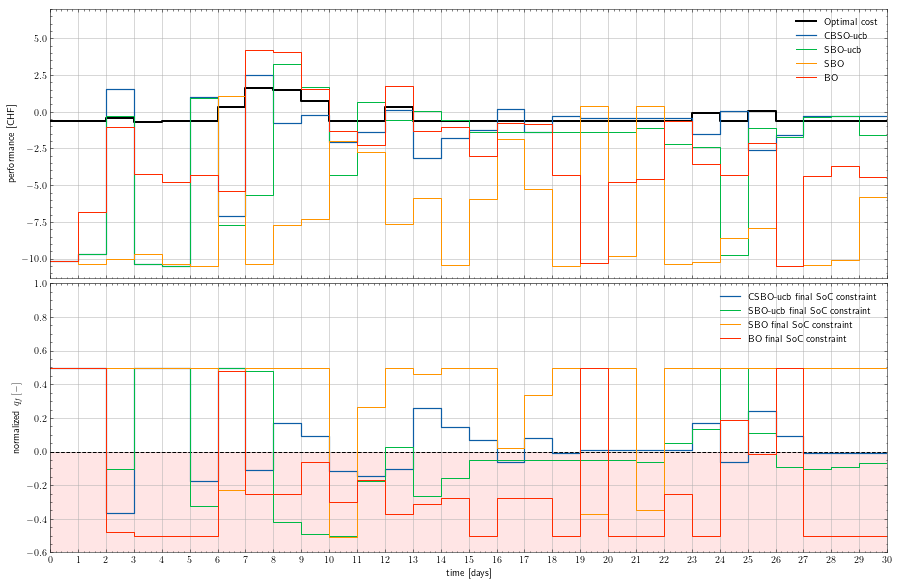

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike1_b0.5_CSBO_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike1_b0.5_CSBO_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike1_b0.5_CSBO_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike1_b0.5_CSBO_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike1_b0.5_SBO_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike1_b0.5_SBO_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike1_b0.5_SBO_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike1_b0.5_SBO_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike1_b0.5_SBOb_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike1_b0.5_SBOb_2022_04_03_1721
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike1_b0.5_SBOb_2022_04_03_1721
sim_data_312_winter_

context=  [0.]
opt parameter and cost:  [ 0.28140704 -0.1758794 ] [-0.43390996  0.00915264  0.27560405]
current max estiamte ucb=  (array([ 0.28140704, -0.1758794 ]), -0.5264809183583777, -0.49869410429884853)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.28140704 -0.1758794 ] [-0.43317248  0.00915264  0.27560405]
current max estiamte ucb=  (array([ 0.38190955, -0.16582915]), 1.2289053673928532, 1.3248839502543603)
32
context=  [0.]
opt parameter and cost:  [ 0.34170854 -0.15577889] [1.12913703 0.08074564 0.37070881]
current max estiamte ucb=  (array([ 0.30150754, -0.18592965]), -0.4911210784259924, -0.45227586501797046)
33
context=  [0.]
opt parameter and cost:  [ 0.28140704 -0.1758794 ] [-0.43317248  0.00915264  0.27560405]
current max estiamte ucb=  (array([ 0.30150754, -0.18592965]), -0.48084785951068987, -0.4433529045197654)
34
context=  [0.]
opt parameter and cost:  [ 0.28140704 -0.1758794 ] [-0.43317248  0.00915264  0.27560405]
current max estiamte ucb=  (array([ 0.3015

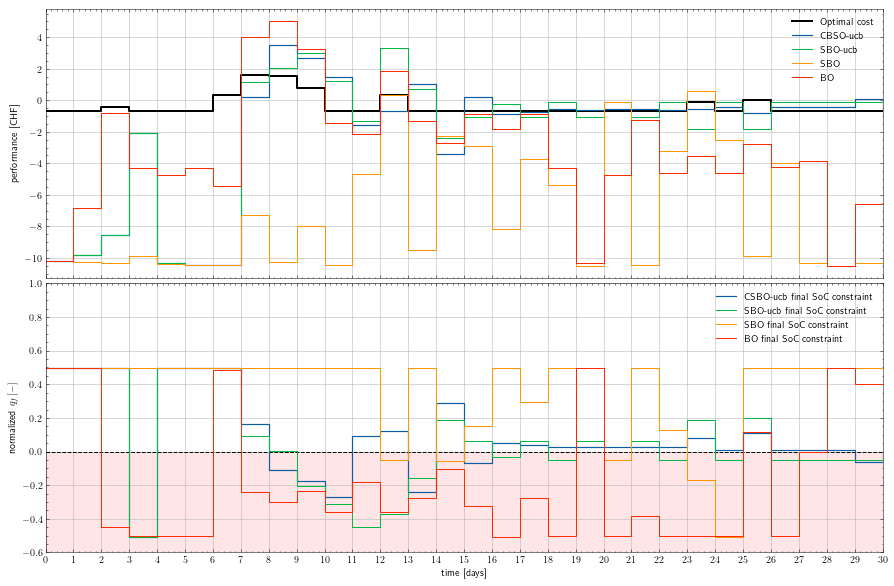

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike1_b1_CSBO_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike1_b1_CSBO_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike1_b1_CSBO_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike1_b1_CSBO_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike1_b1_SBO_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike1_b1_SBO_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike1_b1_SBO_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike1_b1_SBO_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike1_b1_SBOb_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike1_b1_SBOb_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike1_b1_SBOb_2022_04_03_1728
sim_data_312_winter_rp0_gb50_qf_55_qs_32_m

context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 0.        , -0.02512563]), -2.260732783266451, -2.241240946987086)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([0.        , 0.01507538]), -1.6696928236154238, -1.5869383149189162)
32
context=  [0.]
opt parameter and cost:  [0.         0.00502513] [-1.25931288  0.17397221  0.2815383 ]
current max estiamte ucb=  (array([ 0.        , -0.01507538]), -1.6931531754968603, -1.6705786072705315)
33
context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 0.        , -0.01507538]), -1.6926885452698897, -1.6704395480786727)
34
context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 0.        

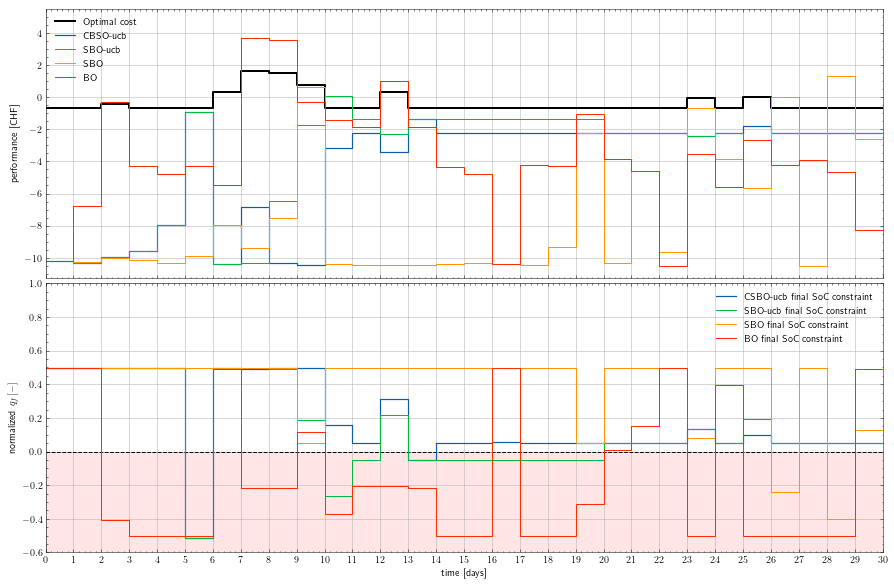

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike1_b2_CSBO_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike1_b2_CSBO_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike1_b2_CSBO_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike1_b2_CSBO_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike1_b2_SBO_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike1_b2_SBO_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike1_b2_SBO_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike1_b2_SBO_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike1_b2_SBOb_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike1_b2_SBOb_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike1_b2_SBOb_2022_04_03_1735
sim_data_312_winter_rp0_gb50_qf_55_qs_32_m

context=  [0.]
opt parameter and cost:  [ 0.64321608 -0.43718593] [-1.15876099  0.04826069 -0.03136159]
current max estiamte ucb=  (array([ 0.64321608, -0.43718593]), -1.704494610382421, -1.6729273986553586)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.62311558 -0.42713568] [-1.03069548  0.04518529 -0.01550683]
current max estiamte ucb=  (array([ 0.60301508, -0.30653266]), 0.8422495960251777, 0.9539842776755154)
32
context=  [0.]
opt parameter and cost:  [ 0.60301508 -0.31658291] [1.44059416 0.02234101 0.11313931]
current max estiamte ucb=  (array([ 0.62311558, -0.42713568]), -1.6402988867432764, -1.6039457926670384)
33
context=  [0.]
opt parameter and cost:  [ 0.62311558 -0.43718593] [-1.31145612  0.08789761  0.026824  ]
current max estiamte ucb=  (array([ 0.62311558, -0.42713568]), -1.594672081933064, -1.5607547303167113)
34
context=  [0.]
opt parameter and cost:  [ 0.62311558 -0.42713568] [-1.03069548  0.04518529 -0.01550683]
current max estiamte ucb=  (array([ 0.62311558,

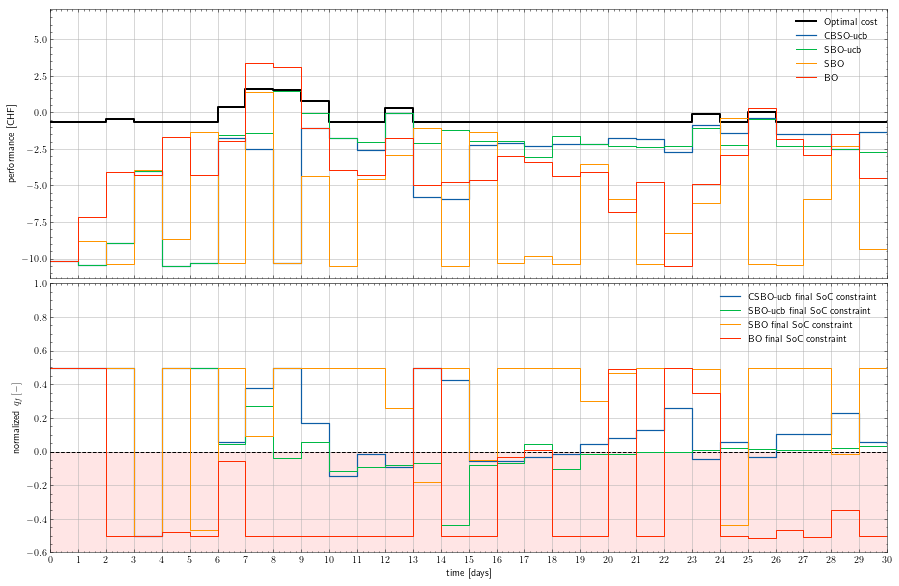

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike2_b0.5_CSBO_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike2_b0.5_CSBO_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike2_b0.5_CSBO_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike2_b0.5_CSBO_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike2_b0.5_SBO_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike2_b0.5_SBO_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike2_b0.5_SBO_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike2_b0.5_SBO_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike2_b0.5_SBOb_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike2_b0.5_SBOb_2022_04_03_1742
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike2_b0.5_SBOb_2022_04_03_1742
sim_data_312_winter_

context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 1.00502513, -1.        ]), -1.9471410093656654, -1.5808299914873678)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([0.        , 0.01507538]), -0.40658600664013383, -0.34535022037295954)
32
context=  [0.]
opt parameter and cost:  [0.         0.01507538] [-0.40239737  0.07571176  0.22865008]
current max estiamte ucb=  (array([ 1.00502513, -1.        ]), -1.9471408445021365, -1.5808298266248217)
33
context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 1.00502513, -1.        ]), -1.9471408292972079, -1.580829811420788)
34
context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 1.00502

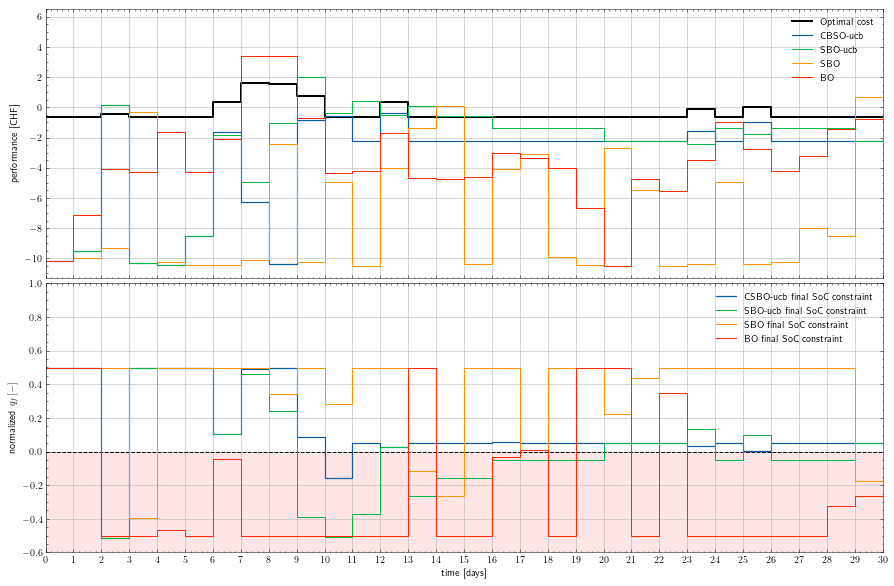

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike2_b1_CSBO_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike2_b1_CSBO_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike2_b1_CSBO_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike2_b1_CSBO_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike2_b1_SBO_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike2_b1_SBO_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike2_b1_SBO_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike2_b1_SBO_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike2_b1_SBOb_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike2_b1_SBOb_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike2_b1_SBOb_2022_04_03_1749
sim_data_312_winter_rp0_gb50_qf_55_qs_32_m

context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.38693467] [-1.02125569  0.05260073  0.05594544]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), -0.7210595539045741, -0.7006179370176691)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.56281407 -0.37688442] [-0.59061317 -0.00428229  0.00124943]
current max estiamte ucb=  (array([ 0.60301508, -0.30653266]), 0.685283227716382, 0.7676660541127099)
32
context=  [0.]
opt parameter and cost:  [ 0.58291457 -0.30653266] [1.2465296  0.04293068 0.14621439]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), -0.7579809526237327, -0.7381484367467159)
33
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [-0.59061317 -0.00428229  0.00124943]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), -0.7503673141221815, -0.7310050700948753)
34
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [-0.59061317 -0.00428229  0.00124943]
current max estiamte ucb=  (array([ 0.56281407

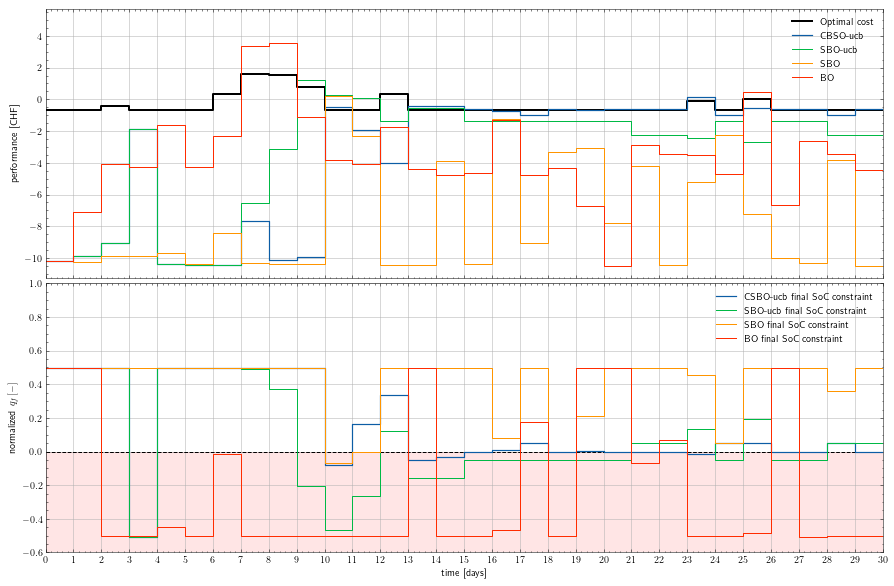

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike2_b2_CSBO_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike2_b2_CSBO_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike2_b2_CSBO_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike2_b2_CSBO_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike2_b2_SBO_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike2_b2_SBO_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike2_b2_SBO_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike2_b2_SBO_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike2_b2_SBOb_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike2_b2_SBOb_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike2_b2_SBOb_2022_04_03_1755
sim_data_312_winter_rp0_gb50_qf_55_qs_32_m

context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 0.50251256, -0.29648241]), -1.8949629236057592, -1.5710449210040205)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([0.        , 0.01507538]), -0.8115001074835799, -0.7680237045926201)
32
context=  [0.]
opt parameter and cost:  [0.         0.01507538] [-0.40239737  0.07571176  0.22865008]
current max estiamte ucb=  (array([ 0.50251256, -0.29648241]), -1.8965928060263286, -1.5726756289373707)
33
context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 0.50251256, -0.29648241]), -1.896478769434384, -1.5725621708449655)
34
context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 0.5025125

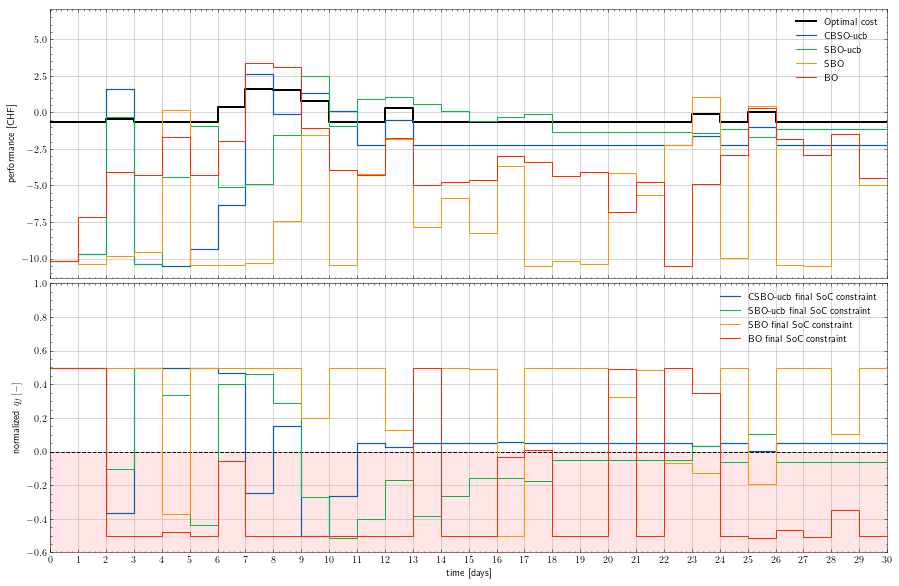

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike3_b0.5_CSBO_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike3_b0.5_CSBO_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike3_b0.5_CSBO_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike3_b0.5_CSBO_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike3_b0.5_SBO_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike3_b0.5_SBO_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike3_b0.5_SBO_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike3_b0.5_SBO_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike3_b0.5_SBOb_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike3_b0.5_SBOb_2022_04_03_1802
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike3_b0.5_SBOb_2022_04_03_1802
sim_data_312_winter_

context=  [0.]
opt parameter and cost:  [ 0.30150754 -0.18592965] [-0.26714769 -0.00980392  0.2448902 ]
current max estiamte ucb=  (array([ 0.7839196 , -0.04522613]), 3.1652408545763215, 3.4519559826354183)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.30150754 -0.18592965] [-0.26461806 -0.00980392  0.2448902 ]
current max estiamte ucb=  (array([ 0.8040201 , -0.03517588]), 2.8754509352201123, 3.1654625041248674)
32
context=  [0.]
opt parameter and cost:  [ 0.34170854 -0.16582915] [0.26305789 0.15148067 0.42968814]
current max estiamte ucb=  (array([ 0.84422111, -0.04522613]), 2.4573763146740633, 2.7606169576509294)
33
context=  [0.]
opt parameter and cost:  [ 0.30150754 -0.18592965] [-0.26461806 -0.00980392  0.2448902 ]
current max estiamte ucb=  (array([ 0.84422111, -0.04522613]), 2.456630433507208, 2.7598708885410903)
34
context=  [0.]
opt parameter and cost:  [ 0.30150754 -0.18592965] [-0.26461806 -0.00980392  0.2448902 ]
current max estiamte ucb=  (array([ 0.84422111, -0.0

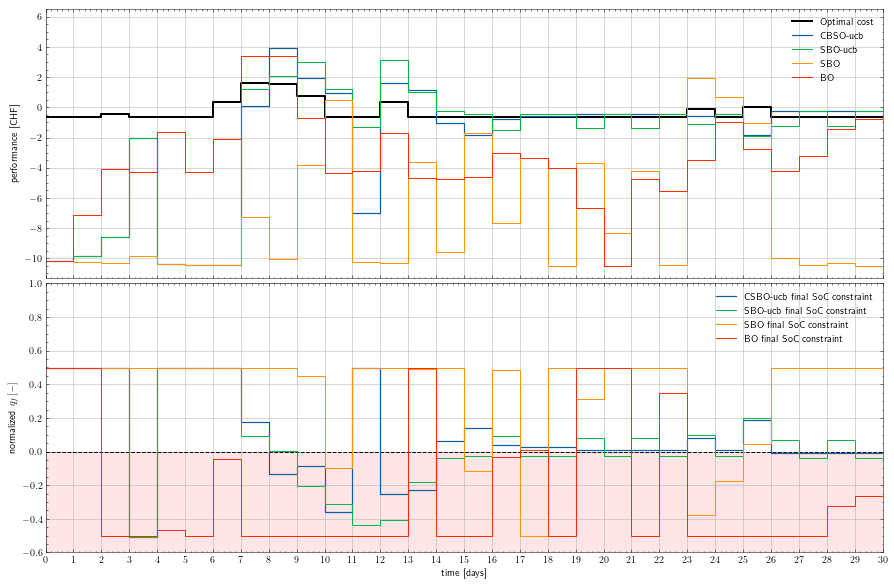

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike3_b1_CSBO_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike3_b1_CSBO_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike3_b1_CSBO_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike3_b1_CSBO_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike3_b1_SBO_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike3_b1_SBO_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike3_b1_SBO_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike3_b1_SBO_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike3_b1_SBOb_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike3_b1_SBOb_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike3_b1_SBOb_2022_04_03_1807
sim_data_312_winter_rp0_gb50_qf_55_qs_32_m

context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 0.14070352, -0.93969849]), -1.8360316168843553, -1.4775736002833115)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([0.        , 0.01507538]), -1.0053909492298394, -0.9679701035279415)
32
context=  [0.]
opt parameter and cost:  [0.         0.01507538] [-0.40239737  0.07571176  0.22865008]
current max estiamte ucb=  (array([ 0.14070352, -0.93969849]), -1.8367186917325435, -1.4782606921978658)
33
context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 0.14070352, -0.93969849]), -1.8367135863479136, -1.4782555905971158)
34
context=  [0.]
opt parameter and cost:  [ 0.         -0.02512563] [-2.23093666  0.05360282  0.51676202]
current max estiamte ucb=  (array([ 0.140703

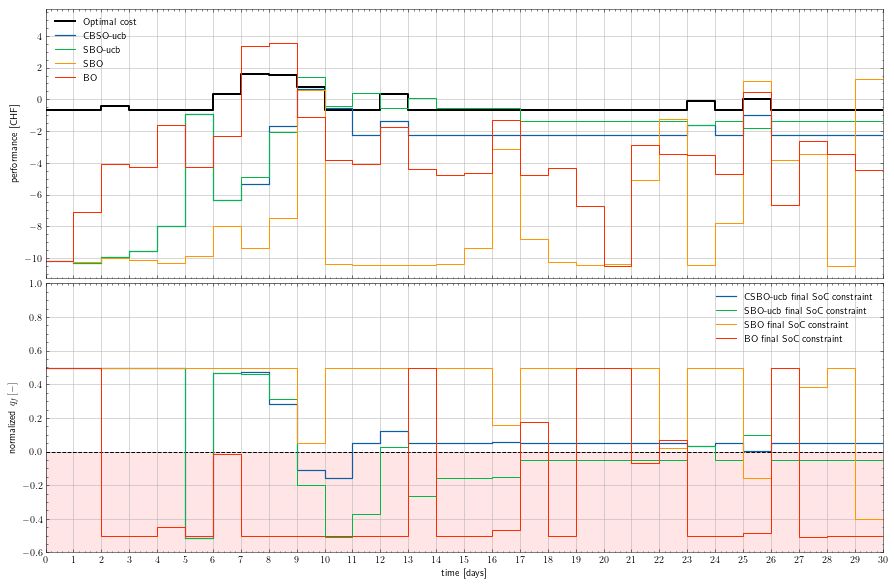

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike3_b2_CSBO_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike3_b2_CSBO_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike3_b2_CSBO_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike3_b2_CSBO_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike3_b2_SBO_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike3_b2_SBO_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike3_b2_SBO_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike3_b2_SBO_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike3_b2_SBOb_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike3_b2_SBOb_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike3_b2_SBOb_2022_04_03_1813
sim_data_312_winter_rp0_gb50_qf_55_qs_32_m

context=  [0.]
opt parameter and cost:  [ 0.36180905 -0.22613065] [-0.31313535 -0.01692604  0.19072005]
current max estiamte ucb=  (array([ 0.36180905, -0.22613065]), -0.5698225144075134, -0.5473182527504744)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.36180905 -0.22613065] [-0.30024938 -0.01746889  0.19017654]
current max estiamte ucb=  (array([ 0.50251256, -0.2160804 ]), 0.38076781238152785, 0.45633721358895324)
32
context=  [0.]
opt parameter and cost:  [ 0.50251256 -0.22613065] [ 2.48356984 -0.08923647  0.11796893]
current max estiamte ucb=  (array([ 0.36180905, -0.22613065]), -0.558298240511733, -0.536497262430604)
33
context=  [0.]
opt parameter and cost:  [ 0.36180905 -0.22613065] [-0.30024938 -0.01746889  0.19017654]
current max estiamte ucb=  (array([ 0.36180905, -0.22613065]), -0.544128435390175, -0.5229475613715995)
34
context=  [0.]
opt parameter and cost:  [ 0.36180905 -0.22613065] [-0.30024938 -0.01746889  0.19017654]
current max estiamte ucb=  (array([ 0.36180

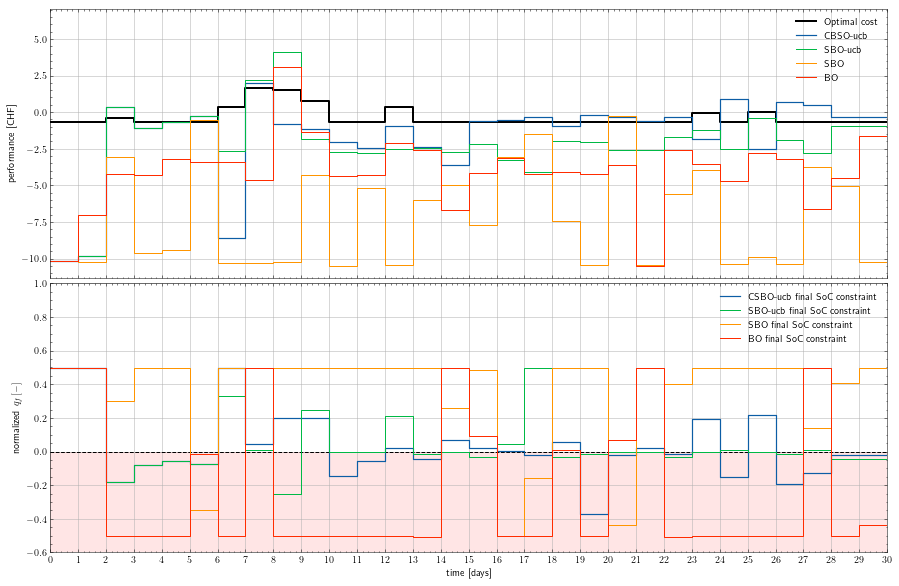

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike4_b0.5_CSBO_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike4_b0.5_CSBO_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike4_b0.5_CSBO_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike4_b0.5_CSBO_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike4_b0.5_SBO_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike4_b0.5_SBO_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike4_b0.5_SBO_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike4_b0.5_SBO_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike4_b0.5_SBOb_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike4_b0.5_SBOb_2022_04_03_1818
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike4_b0.5_SBOb_2022_04_03_1818
sim_data_312_winter_

context=  [0.]
opt parameter and cost:  [ 1.22613065 -1.        ] [-3.87829563  0.49949626  0.0747863 ]
current max estiamte ucb=  (array([ 0.32160804, -1.        ]), -2.6657122613289057, -2.373676215347334)
31
context=  [0.23770875]
opt parameter and cost:  [ 1.22613065 -1.        ] [-3.82286857  0.49949125  0.06752973]
current max estiamte ucb=  (array([ 1.42713568, -1.        ]), -2.4633884797176226, -2.3968112822611345)
32
context=  [0.]
opt parameter and cost:  [ 1.40703518 -1.        ] [-1.72487670e+00  4.99404142e-01  6.83988843e-04]
current max estiamte ucb=  (array([ 0.04020101, -0.91959799]), -2.7300039531571576, -2.438421171396141)
33
context=  [0.]
opt parameter and cost:  [ 1.24623116 -0.88944724] [-5.52384852  0.49482287 -0.04130903]
current max estiamte ucb=  (array([ 0.04020101, -0.91959799]), -2.7481982247115258, -2.45661890538643)
34
context=  [0.]
opt parameter and cost:  [ 1.22613065 -1.        ] [-3.82286857  0.49949125  0.06752973]
current max estiamte ucb=  (arra

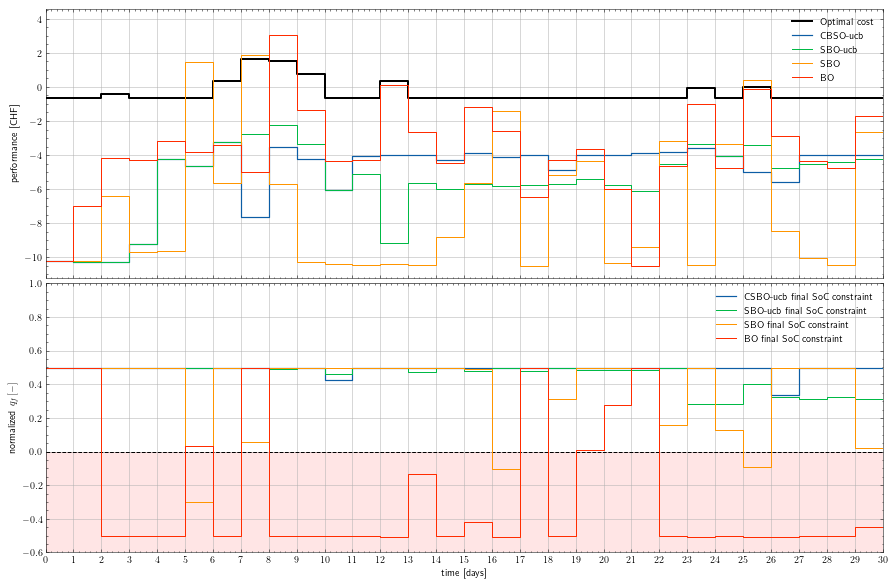

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike4_b1_CSBO_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike4_b1_CSBO_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike4_b1_CSBO_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike4_b1_CSBO_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike4_b1_SBO_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike4_b1_SBO_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike4_b1_SBO_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike4_b1_SBO_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike4_b1_SBOb_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike4_b1_SBOb_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike4_b1_SBOb_2022_04_03_1824
sim_data_312_winter_rp0_gb50_qf_55_qs_32_m

context=  [0.]
opt parameter and cost:  [ 0.8040201  -0.59798995] [-2.77721891  0.26929126  0.01116279]
current max estiamte ucb=  (array([ 0.7638191 , -0.53768844]), -2.92166931095612, -2.894502708811685)
31
context=  [0.23770875]
opt parameter and cost:  [ 0.8040201  -0.59798995] [-2.72898584  0.26634857  0.00718433]
current max estiamte ucb=  (array([ 0.86432161, -0.52763819]), -0.6916403071773218, -0.64033387639441)
32
context=  [0.]
opt parameter and cost:  [ 0.86432161 -0.55778894] [-1.15699463  0.32158865  0.12230101]
current max estiamte ucb=  (array([ 0.7638191 , -0.53768844]), -2.908876278005491, -2.8819613938820448)
33
context=  [0.]
opt parameter and cost:  [ 0.8040201  -0.59798995] [-2.72898584  0.26634857  0.00718433]
current max estiamte ucb=  (array([ 0.7638191 , -0.53768844]), -2.8976704768372885, -2.8709769252981507)
34
context=  [0.]
opt parameter and cost:  [ 0.8040201  -0.59798995] [-2.72898584  0.26634857  0.00718433]
current max estiamte ucb=  (array([ 0.7638191 

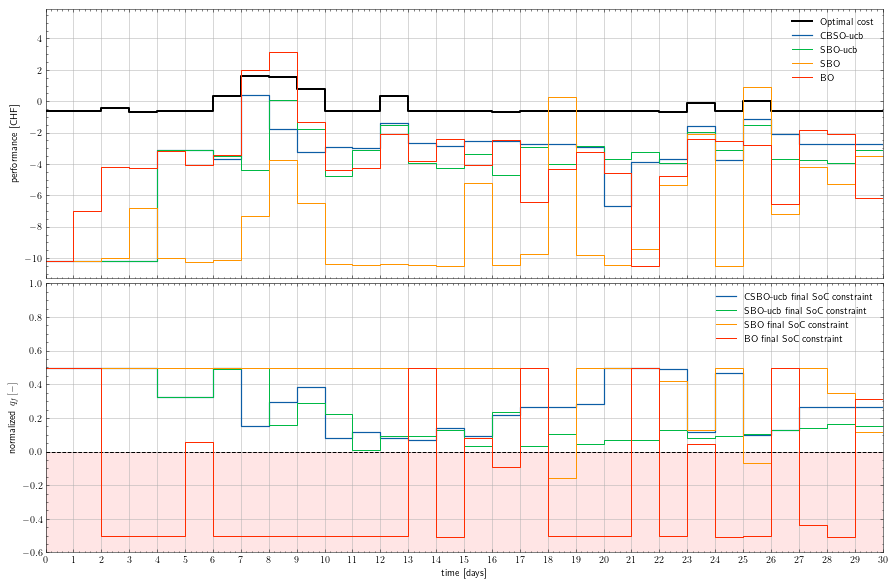

sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike4_b2_CSBO_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike4_b2_CSBO_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike4_b2_CSBO_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike4_b2_CSBO_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike4_b2_SBO_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike4_b2_SBO_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike4_b2_SBO_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_prior_loglike4_b2_SBO_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_post_loglike4_b2_SBOb_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/y_post_loglike4_b2_SBOb_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_model/x_prior_loglike4_b2_SBOb_2022_04_03_1829
sim_data_312_winter_rp0_gb50_qf_55_qs_32_m

In [11]:
# import glob 
# paths=glob.glob('sim_data_312_winter_rp0_qf_55/hyperpar_loglike*')
# file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
# betas=[file_path.split('_')[2].strip('b') for file_path in file_paths] # get betas
# for i, beta in enumerate(betas):
#     if beta.startswith('0'):
#         betas[i]=float(beta.replace('0','.'))
#     else:
#         betas[i]=float(beta) # convert to float and add . to 05

# par_names=[file_path.split('_')[1] for file_path in file_paths] # get optypes 
# # dates=[file_path[-19:-4] for file_path in file_paths] # get betas
# # for idx,path in enumerate(paths):

hp1=get_data('sim_data_312_winter_rp0_qf_55_model/hyperpar_loglike1_b0.5__2022_03_13_0500.npy')
hp2=get_data('sim_data_312_winter_rp0_qf_55_model/hyperpar_loglike2_b0.5__2022_03_13_0445.npy')
hp3=get_data('sim_data_312_winter_rp0_qf_55_model/hyperpar_loglike3_b0.5__2022_03_13_0438.npy')
hp4=get_data('sim_data_312_winter_rp0_qf_55_model/hyperpar_loglike4_b0.5__2022_03_13_0454.npy')

hps=[hp1,hp2,hp3,hp4]
for idx,hp in zip([1,2,3,4],hps):
    for beta in [0.5,1,2]:

    #     print(par_names[idx],betas[idx])
    #     hp=get_data(path)
        e_ch=data.e_char.asfreq('D').shift(-2).dropna()
    #     e_dis=data.e_dis.asfreq('D').shift(-2).dropna() # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
        ctxt=e_ch
#         hp=[3.6**2,[0.6,0.29], #cost
#         0.27**2,[0.267,0.1],# const
#         0.22**2,[0.245, 0.242],#safe 
#         2,#beta
#         0.08,0.4,1] #contexts lenght
        Vz=hp[0]
        Lz=hp[1]
        Vq=hp[2]
        Lq=hp[3]
        Vqs=hp[4]
        Lqs=hp[5]
        beta=beta
        Lctxt_z=hp[7]
        Lctxt_q=hp[8]
        Lctxt_qs=hp[9]

        noise_cst = 2e-1#cst_mmnt_noise.mean()/10
        noise_const =5e-4
        noise_safeconst =5e-4
        S_f_sp=55
        S_os_max=0
        soc_lim=[30,80]
        soc_softc=[32,80]
        # opt_cost=rnd_opt_cst[0]
        def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
            p_load=data[:T*day+N_lim[1]]
            x=x0
            i=0
            while True:
        #         i=0 #always first day
                soc_i=50 #always same soc_i
                res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,plot_cost=False,noise=False)
                c=res[0]
                q=res[1:]  
                x,i=yield c[3]+50*c[2],(q[1]-S_f_sp)/soc_std,(q[2]-soc_softc[0])/soc_std
                p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
        #         print('day: ',i)
        #         plt.plot(p_load[N_lim[1]:])
        #         plt.show()
        bounds = [(0., 4.),(-1,1)]
        parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
        # parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
        # Define Kernel
        # for x_ in np.random.uniform(-0.5,-0.05,10):

        cost_kernel_ = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
        cost_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
        cost_kernel=cost_kernel_*cost_context_kernel

        const_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
        const_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
        const_kernel=const_kernel_*const_context_kernel

        safeconst_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
        safeconst_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
        safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

        context=np.array([[ctxt[0]]])
        x0=np.array([[0.,-0.5]])
        x=np.hstack([x0,context])
        cost=cost_g(x0.flatten())
        y0= np.atleast_2d(cost.send(None))
        cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
        const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
        safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)

        cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
        const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
        safeconst_gp_= GPy.models.GPRegression(x0,y0[:,2,None], safeconst_kernel_, noise_var=noise_safeconst)

        gp=[cost_gp,const_gp,safeconst_gp]
        gp_=[cost_gp_,const_gp_,safeconst_gp_]
        gp__=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
        gpva=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]

        # The optimization routine
        optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf,-np.inf], threshold=np.array([-np.inf,-np.inf,-50]),beta=beta)
        opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
        opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
        opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta,num_contexts=1)
        # opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
        iterations=len(data)*dt//day-2

        y_post=np.empty((iterations,y0.shape[1]))
        x_post=np.empty((iterations,x0.shape[1]))
        x_prior=np.empty((iterations,x0.shape[1]))
        y_prior=[]
        y_prior.append(y0.flatten())

        y_post_=np.empty((iterations,y0.shape[1]))
        x_post_=np.empty((iterations,x0.shape[1]))
        x_prior_=np.empty((iterations,x0.shape[1]))
        y_prior_=[]
        y_prior_.append(y0.flatten())

        y_post__=np.empty((iterations,y0.shape[1]))
        x_post__=np.empty((iterations,x0.shape[1]))
        x_prior__=np.empty((iterations,x0.shape[1]))
        y_prior__=[]
        y_prior__.append(y0.flatten())

        y_postva=np.empty((iterations,y0.shape[1]))
        x_postva=np.empty((iterations,x0.shape[1]))
        x_priorva=np.empty((iterations,x0.shape[1]))
        y_priorva=[]
        y_priorva.append(y0.flatten())

        for i in range(iterations):
            print(i)
            # Get optimizer for same day
            try:
                x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
                x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
                x_post__[i,:] = opt.optimize()
                x_postva[i,:] = optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]
                x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
                x_post__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]
                x_postva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]

            y_post[i,:] = cost.send((x_post[i,:].flatten(),i))
            y_post_[i,:] = cost.send((x_post_[i,:].flatten(),i))
            y_post__[i,:] = cost.send((x_post__[i,:].flatten(),i))
            y_postva[i,:] = cost.send((x_postva[i,:].flatten(),i))    

        #     if y_post[i,1]<-1e-1:
        #         print('Constraint violated',-soc_std*y_post[i,1],y_post[i,1])
        #         break
            # Get context of next day
            context=np.array([ctxt[i+1]])
            print('context= ',context)
            try:
                x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
                x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
                x_prior__[i,:] =  opt.optimize(ucb=False)
                x_priorva[i,:] =  optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
                x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
                x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
                x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]            

            y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))
            y_prior_.append(cost.send((x_prior_[i,:].flatten(),i+1)))
            y_prior__.append(cost.send((x_prior__[i,:].flatten(),i+1)))    
            y_priorva.append(cost.send((x_priorva[i,:].flatten(),i+1)))    


            print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
            opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
            opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
            opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
            optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 

            print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
        y_prior=np.array(y_prior[:-1])
        y_prior_=np.array(y_prior_[:-1])
        y_prior__=np.array(y_prior__[:-1])
        y_priorva=np.array(y_priorva[:-1])

        err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
        print(np.abs(err).sum()/(iterations-10))

        # mpl.rcParams['text.usetex']=True

        with plt.style.context('science'):
            err=25e-2
            # plt.step(range(iterations),best_constrained_value(y_meas),where='post',label='SafeOpt')
            fig,ax=plt.subplots(2,sharex=True,figsize=(15,10))
            ax[0].step(range(iterations),-rnd_opt_cst[:iterations],where='post',label='Optimal cost',color='black',linewidth=2)
    #         ax[0].step(range(iterations),y_post[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
    #         ax[0].step(range(iterations),y_post_[:,0],where='post',label='SBO-ucb')
    #         ax[0].step(range(iterations),y_post__[:,0],where='post',label='SBO')
    #         ax[0].step(range(iterations),y_postva[:,0],where='post',label='BO')

            ax[0].step(range(iterations),y_prior[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
            ax[0].step(range(iterations),y_prior_[:,0],where='post',label='SBO-ucb')
            ax[0].step(range(iterations),y_prior__[:,0],where='post',label='SBO')
            ax[0].step(range(iterations),y_priorva[:,0],where='post',label='BO')

            ax[0].set_xticks(np.arange(0,iterations,1))
            ax[0].set_ylabel('performance [CHF]')
            ax[0].legend()

            # plt.step(range(iterations),-y_meas[:,1],where='post',label='SafeOpt')
    #         ax[1].step(range(iterations),y_post[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
    #         ax[1].step(range(iterations),y_post_[:,1],where='post',label='SBO-ucb final SoC constraint')
    #         ax[1].step(range(iterations),y_post__[:,1],where='post',label='SBO final SoC constraint')
    #         ax[1].step(range(iterations),y_postva[:,1],where='post',label='BO final SoC constraint')
            ax[1].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            ax[1].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)

            ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
            ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SBO-ucb final SoC constraint')
            ax[1].step(range(iterations),y_prior__[:,1],where='post',label='SBO final SoC constraint')
            ax[1].step(range(iterations),y_priorva[:,1],where='post',label='BO final SoC constraint')

            # ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SO prior final SoC constraint')
            # ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSO prior final SoC constraint')
            ax[1].set_ylim([-0.6,1])
            ax[1].set_ylabel(r'normalized $q_f [-]$')
            ax[1].legend()

            # ax[2].step(range(iterations),y_post[:,2],where='post',label='bound SoC constraint')
            # ax[2].step(range(iterations),y_prior[:,2],where='post',label='bound final SoC constraint')
            # ax[2].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            # ax[2].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
            # ax[2].set_ylim([-0.1,1])
            # ax[2].legend()
            plt.xlabel('time [days]')
            plt.xlim([0,30])
            plt.subplots_adjust(hspace=0.02)
    #         plt.savefig(f'RBC312_rp_b0_qf_55_beta_{beta}_{par_names[idx]}_model.png')
        plt.show()
    #     name=f'{par_names[idx]}_b{beta}_'
        name=f'loglike{idx}_b{beta}_'
        optype='CSBO'
        sim_dir='sim_data_312_winter_rp0_gb50_qf_55_qs_32_model'
        save_data(x_post,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBO'
        save_data(x_post_,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post_,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior_,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior_,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBOb'
        save_data(x_post__,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post__,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior__,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior__,'y_prior_'+name+optype,folder=sim_dir)
        optype='BO'
        save_data(x_postva,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_postva,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_priorva,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_priorva,'y_prior_'+name+optype,folder=sim_dir)

        save_data(hp,'hyperpar_'+name,folder=sim_dir)
        save_data(opt_ucb.gps,'CSBO_'+name,folder=sim_dir,pick=True,npy=False)
        save_data(opt_ucb_.gps,'SBO_'+name,folder=sim_dir,pick=True,npy=False)    

### Mattern32

In [79]:
# Winter std
hp1=[5.8**2,[1.9,1.12], #cost
    0.27**2,[0.95,0.478],# const
    0.25**2,[0.59, 0.38],#safe 
    2,#beta
    2.45,1.35,0.841] #contexts lenght
hp2=[4**2,[1.28,0.937], #cost
    0.303**2,[1.62,0.757],# const
    0.309**2,[0.695, 0.697],#safe 
    2,#beta
    1.08,1.49,0.543] #contexts lenght

hp3=[4.9**2,[1.3,0.698], #cost
    0.3**2,[0.682,0.478],# const
    0.263**2,[0.425, 0.472],#safe 
    2,#beta
    1.06,0.3,0.77] #contexts lenght

hps=[hp1,hp2,hp3]
# Winter P1P3




0.5 [33.64, [1.9, 1.12], 0.0729, [0.95, 0.478], 0.0625, [0.59, 0.38], 2, 2.45, 1.35, 0.841]
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [0.72361809 0.12562814] [ 1.50163168 -0.50353743 -0.0435823 ]
current max estiamte ucb=  (array([ 1.34673367, -0.53768844]), -1.4150678477154615, -0.6155621510253986)
1
context=  [0.03046038]
opt parameter and cost:  [ 1.06532663 -0.64824121] [-0.95369497  0.29789905 -0.04296992]
current max estiamte ucb=  (array([ 1.02512563, -0.30653266]), 0.017759174866854605, 0.3452844778997384)
2
context=  [0.]
opt parameter and cost:  [ 0.86432161 -0.33668342] [ 1.54854753 -0.07761851 -0.04088889]
current max estiamte ucb=  (array([ 0.8040201 , -0.38693467]), 0.5709704285826456, 0.6456210329495298)
3
context=  [0.]
opt parameter and cost:  [ 0.7638191  -0.38693467] [ 0.91256466 -0.017

current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.1803261485410315, 1.1860008149645966)
38
context=  [0.00144539]
opt parameter and cost:  [ 0.54271357 -0.36683417] [1.0654643  0.01661796 0.04271364]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.1369726113679868, 1.1423516800378415)
39
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [0.92536494 0.02931949 0.04339939]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.173817682561744, 1.179091355751584)
40
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.182784333274453, 1.187883708034365)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.62311558, -0.36683417]), 1.2461928359362175, 1.25716929184794)
42
context=  [0.25377856]
opt

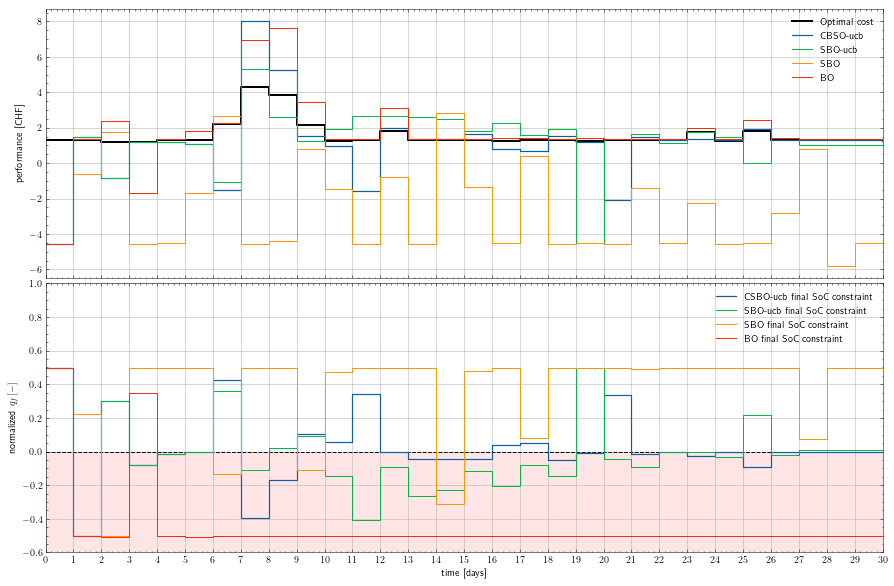

sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike0_b0.5_CSBO_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike0_b0.5_CSBO_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike0_b0.5_CSBO_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike0_b0.5_CSBO_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike0_b0.5_SBO_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike0_b0.5_SBO_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike0_b0.5_SBO_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike0_b0.5_SBO_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike0_b0.5_SBOb_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike0_b0.5_SBOb_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike0_b0.5_SBOb_2022_03_21_0655
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [0.84422111 0.50753769] [ 1.36252883 -0.50092377 -0.04092377]
current max estiamte ucb=  (array([ 1.66834171, -0.27638191]), -0.706479827686715, -0.008694471218959998)
1
context=  [0.03046038]
opt parameter and cost:  [ 1.12562814 -0.27638191] [ 1.88979131 -0.15720652 -0.04082095]
current max estiamte ucb=  (array([ 1.10552764, -0.50753769]), 0.8115291802376428, 1.0836056878634892)
2
context=  [0.]
opt parameter and cost:  [ 0.98492462 -0.50753769] [ 0.19424639  0.12831602 -0.04098151]
current max estiamte ucb=  (array([ 0.92462312, -0.36683417]), 0.20711305531714042, 0.3384049570466722)
3
context=  [0.]
opt parameter and cost:  [ 0.84422111 -0.34673367] [ 1.13438771 -0.06553378 -0.04156178]
current max estiamte ucb=  (array([ 0.74371859, -0.37688442]), 0.78837931

context=  [0.00144539]
opt parameter and cost:  [ 0.58291457 -0.39698492] [1.08889213 0.02559953 0.00907769]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.1832304402613916, 1.188862335867347)
39
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [0.92536494 0.02931949 0.04339939]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.193830586778943, 1.1992456578302901)
40
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.2018820472520326, 1.2071089220212718)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.60301508, -0.38693467]), 1.4008745720199767, 1.410781691098403)
42
context=  [0.25377856]
opt parameter and cost:  [ 0.60301508 -0.38693467] [ 1.44357190e+00 -4.95691823e-04 -1.11139132e-02]
curre

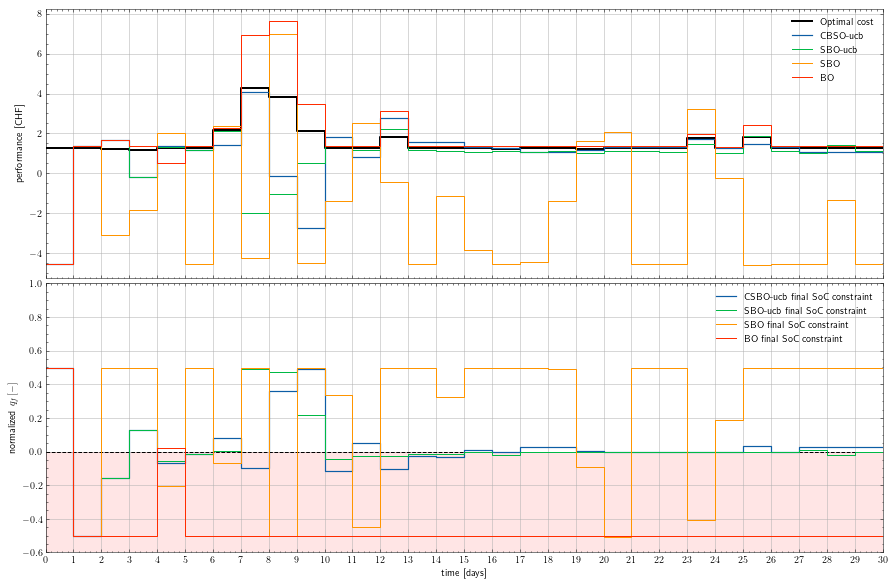

sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike1_b0.5_CSBO_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike1_b0.5_CSBO_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike1_b0.5_CSBO_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike1_b0.5_CSBO_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike1_b0.5_SBO_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike1_b0.5_SBO_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike1_b0.5_SBO_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike1_b0.5_SBO_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike1_b0.5_SBOb_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike1_b0.5_SBOb_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike1_b0.5_SBOb_2022_03_21_0701
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [0.08040201 0.18592965] [ 1.45719201 -0.50247803 -0.04248076]
current max estiamte ucb=  (array([ 0.        , -0.16582915]), -1.9388726666113079, -1.540906323100892)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.72361809 -1.        ] [-4.53703731  0.49952454  0.95825782]
current max estiamte ucb=  (array([ 1.68844221, -0.1959799 ]), -1.458220484791762, -0.5667139571750239)
2
context=  [0.]
opt parameter and cost:  [ 1.18592965 -0.41708543] [ 0.64611016  0.01933393 -0.04088593]
current max estiamte ucb=  (array([ 1.04522613, -0.38693467]), 0.44832730544309557, 0.5430766316327632)
3
context=  [0.]
opt parameter and cost:  [ 1.02512563 -0.42713568] [ 0.43527711  0.03145393 -0.04134779]
current max estiamte ucb=  (array([ 0.86432161, -0.33668342]), 0.521046313

opt parameter and cost:  [ 0.54271357 -0.36683417] [1.0654643  0.01661796 0.04271364]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.0211374446475041, 1.0333497266986207)
39
context=  [0.]
opt parameter and cost:  [ 0.52261307 -0.34673367] [0.86764796 0.0252135  0.0785693 ]
current max estiamte ucb=  (array([ 0.54271357, -0.36683417]), 1.0053622104760105, 1.0101665913708022)
40
context=  [0.]
opt parameter and cost:  [ 0.54271357 -0.36683417] [1.0654643  0.01661796 0.04271364]
current max estiamte ucb=  (array([ 0.54271357, -0.36683417]), 1.0085765861896303, 1.0132480729845414)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.54271357 -0.36683417] [1.0654643  0.01661796 0.04271364]
current max estiamte ucb=  (array([ 0.56281407, -0.35678392]), 1.114981256639928, 1.1292257070491953)
42
context=  [0.25377856]
opt parameter and cost:  [ 0.56281407 -0.35678392] [ 1.54792677 -0.02216147  0.00996223]
current max estiamte ucb=  (array([ 0.66331658, -0.34673367]), 3.054

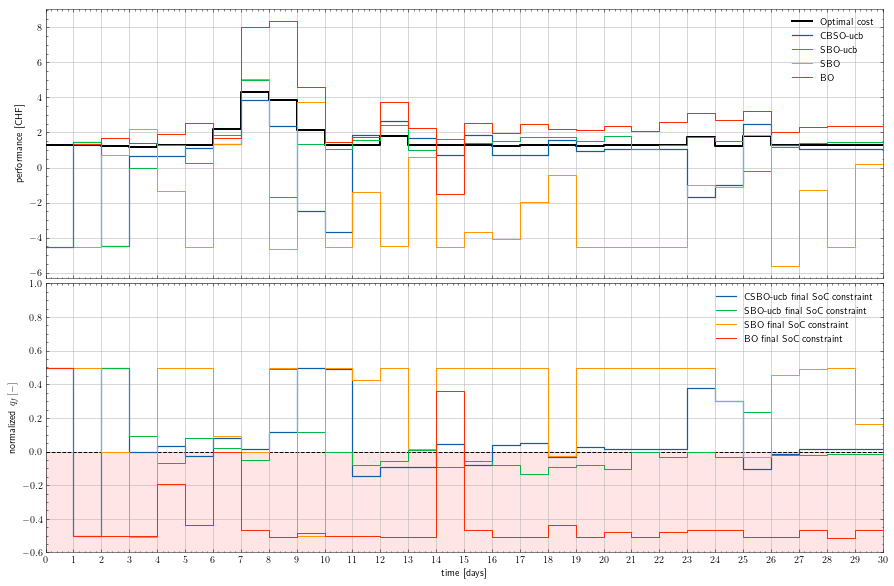

sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike2_b0.5_CSBO_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike2_b0.5_CSBO_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike2_b0.5_CSBO_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike2_b0.5_CSBO_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike2_b0.5_SBO_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike2_b0.5_SBO_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike2_b0.5_SBO_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike2_b0.5_SBO_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike2_b0.5_SBOb_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike2_b0.5_SBOb_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike2_b0.5_SBOb_2022_03_21_0707
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.8241206  -0.74874372] [-3.71200009  0.49936397  0.73119827]
current max estiamte ucb=  (array([ 2.47236181, -1.        ]), -1.9806261234013403, -1.0300693576207345)
1
context=  [0.03046038]
opt parameter and cost:  [ 1.18592965 -0.2361809 ] [ 2.18787387 -0.20522093 -0.04071476]
current max estiamte ucb=  (array([ 1.70854271, -0.55778894]), 0.5092313994763287, 1.042360201958863)
2
context=  [0.]
opt parameter and cost:  [ 1.46733668 -0.70854271] [-1.47336501  0.36980653 -0.04088386]
current max estiamte ucb=  (array([ 1.24623116, -0.40703518]), 0.573145598664182, 0.7445801360429889)
3
context=  [0.]
opt parameter and cost:  [ 1.14572864 -0.46733668] [ 0.08366098  0.07997054 -0.04118076]
current max estiamte ucb=  (array([ 1.02512563, -0.39698492]), 0.4892121518

context=  [0.00144539]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.1891188002971982, 1.1941911881598875)
39
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [0.92536494 0.02931949 0.04339939]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.2006686810160234, 1.2056028450075784)
40
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.2070462124263495, 1.2118367422085603)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.64321608, -0.38693467]), 1.3341547291626144, 1.3446914204517013)
42
context=  [0.25377856]
opt parameter and cost:  [ 0.58291457 -0.37688442] [1.31594379 0.00846475 0.01833656]
cu

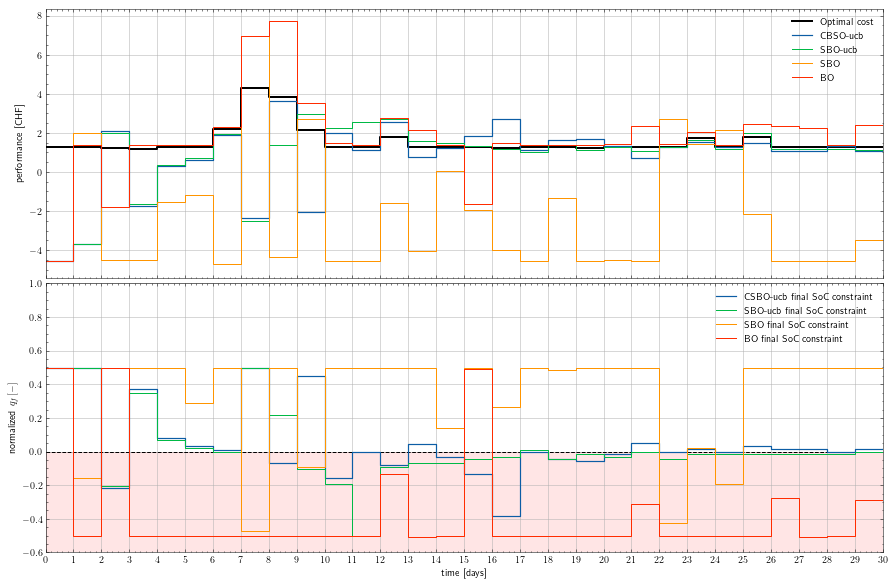

sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike0_b1_CSBO_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike0_b1_CSBO_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike0_b1_CSBO_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike0_b1_CSBO_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike0_b1_SBO_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike0_b1_SBO_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike0_b1_SBO_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike0_b1_SBO_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike0_b1_SBOb_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike0_b1_SBOb_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike0_b1_SBOb_2022_03_21_0714
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike0_b1

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [0.74371859 0.11557789] [ 1.53539378 -0.50379984 -0.0438608 ]
current max estiamte ucb=  (array([ 1.26633166, -0.45728643]), -0.39128008273479886, 0.21171477435207042)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.7638191  -0.44723618] [ 0.68005083  0.05536725 -0.0420209 ]
current max estiamte ucb=  (array([ 0.70351759, -0.36683417]), 0.6454538594444769, 0.7477723591871642)
2
context=  [0.]
opt parameter and cost:  [ 0.54271357 -1.        ] [-4.50845952  0.49952454  0.95524872]
current max estiamte ucb=  (array([ 0.68341709, -0.37688442]), 0.6751645550800784, 0.7787435876811664)
3
context=  [0.]
opt parameter and cost:  [ 0.62311558 -0.38693467] [ 1.31349417 -0.0169563  -0.0406728 ]
current max estiamte ucb=  (array([ 0.58291457, -0.39698492]), 1.142916798

current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.2449439730703422, 1.2489323318555487)
38
context=  [0.00144539]
opt parameter and cost:  [ 0.66331658 -0.41708543] [ 0.97065042  0.0188362  -0.04185454]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.2357799397874978, 1.2397775069837926)
39
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [0.92536494 0.02931949 0.04339939]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.247499840102238, 1.2514103895312712)
40
context=  [0.]
opt parameter and cost:  [ 0.54271357 -0.36683417] [1.0654643  0.01661796 0.04271364]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.2441563944279301, 1.2480143565650814)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.58291457, -0.37688442]), 1.3431343052713087, 1.3520969920207593)
42
context=  [0.25377856]
opt parame

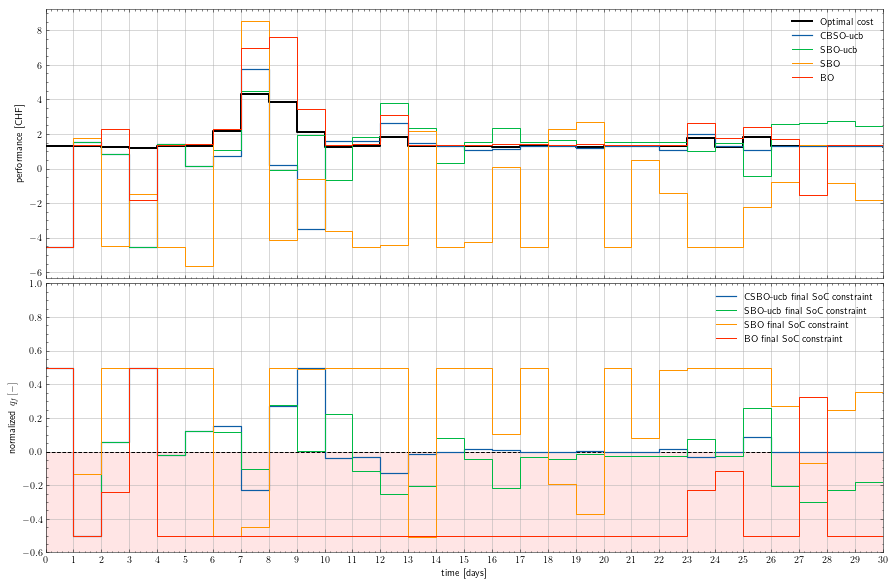

sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike1_b1_CSBO_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike1_b1_CSBO_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike1_b1_CSBO_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike1_b1_CSBO_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike1_b1_SBO_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike1_b1_SBO_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike1_b1_SBO_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike1_b1_SBO_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike1_b1_SBOb_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike1_b1_SBOb_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike1_b1_SBOb_2022_03_21_0720
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike1_b1

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.         -0.94974874] [-4.54220123  0.49949926  0.95949926]
current max estiamte ucb=  (array([0.16080402, 0.67839196]), -1.276648011034572, -0.32152114625709993)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.10050251 -0.09547739] [-2.8631133   0.22119088  0.58169107]
current max estiamte ucb=  (array([0.12060302, 0.77889447]), -1.1163189338503514, -0.2098464799710419)
2
context=  [0.]
opt parameter and cost:  [0.04020101 0.11557789] [ 1.85318588 -0.50389701 -0.04467395]
current max estiamte ucb=  (array([ 0.12060302, -0.03517588]), -1.662536799687567, -1.573284946340996)
3
context=  [0.]
opt parameter and cost:  [ 0.70351759 -0.9798995 ] [-4.53693594  0.49951474  0.95825782]
current max estiamte ucb=  (array([ 1.32663317, -0.00502513]), -1.46247883387

context=  [0.00144539]
opt parameter and cost:  [ 0.62311558 -0.43718593] [0.61679978 0.08789761 0.026824  ]
current max estiamte ucb=  (array([ 0.62311558, -0.42713568]), 0.6934034613231037, 0.7011099747654694)
39
context=  [0.]
opt parameter and cost:  [ 0.62311558 -0.42713568] [0.69343082 0.07096192 0.0208347 ]
current max estiamte ucb=  (array([ 0.62311558, -0.43718593]), 0.5685433996201561, 0.5730595495914179)
40
context=  [0.]
opt parameter and cost:  [ 0.62311558 -0.43718593] [0.61679978 0.08789761 0.026824  ]
current max estiamte ucb=  (array([ 0.62311558, -0.43718593]), 0.5708304747883963, 0.5752357117577966)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.62311558 -0.43718593] [0.61679978 0.08789761 0.026824  ]
current max estiamte ucb=  (array([ 0.72361809, -0.38693467]), 1.1092971963779377, 1.128568129353539)
42
context=  [0.25377856]
opt parameter and cost:  [ 0.70351759 -0.38693467] [ 1.26412319 -0.01733256 -0.0414723 ]
current max estiamte ucb=  (array([ 0.3417085

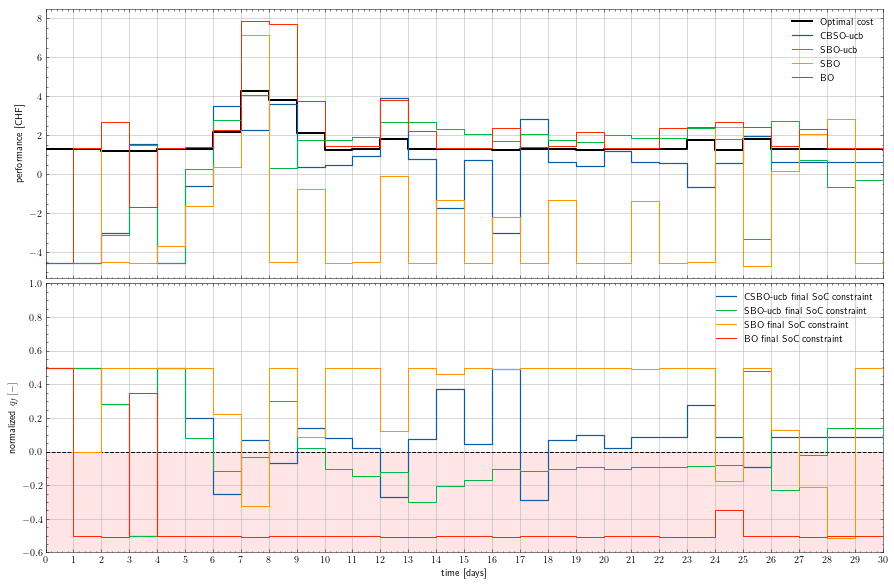

sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike2_b1_CSBO_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike2_b1_CSBO_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike2_b1_CSBO_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike2_b1_CSBO_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike2_b1_SBO_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike2_b1_SBO_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike2_b1_SBO_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike2_b1_SBO_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike2_b1_SBOb_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike2_b1_SBOb_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike2_b1_SBOb_2022_03_21_0726
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike2_b1

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.54271357 -0.45728643] [-3.22548384  0.4982745   0.60374507]
current max estiamte ucb=  (array([ 2.01005025, -0.28643216]), -1.4042562807598291, -0.5282126256135917)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.60301508 -0.18592965] [ 2.63243486 -0.26483552 -0.04173273]
current max estiamte ucb=  (array([ 0.96482412, -0.31658291]), 0.6046007870729787, 0.9021230543544939)
2
context=  [0.]
opt parameter and cost:  [ 0.74371859 -0.35678392] [ 1.53815396 -0.05354669 -0.0412053 ]
current max estiamte ucb=  (array([ 0.72361809, -0.37688442]), 0.4493837714399312, 0.4744314908328939)
3
context=  [0.]
opt parameter and cost:  [ 0.68341709 -0.36683417] [ 1.19767707 -0.04155998 -0.04147249]
current max estiamte ucb=  (array([ 0.86432161, -0.36683417]), 0.88564708

current max estiamte ucb=  (array([ 0.70351759, -0.37688442]), 1.0567463453643287, 1.0717140163362187)
39
context=  [0.]
opt parameter and cost:  [ 0.52261307 -0.34673367] [0.86764796 0.0252135  0.0785693 ]
current max estiamte ucb=  (array([ 0.70351759, -0.37688442]), 1.0656159558299445, 1.0805829196277406)
40
context=  [0.]
opt parameter and cost:  [ 0.50251256 -0.33668342] [0.96960023 0.01604863 0.0816593 ]
current max estiamte ucb=  (array([ 0.70351759, -0.37688442]), 1.0655931727844798, 1.0805600199980692)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.50251256 -0.33668342] [0.96960023 0.01604863 0.0816593 ]
current max estiamte ucb=  (array([ 0.72361809, -0.36683417]), 1.1718039192329723, 1.185190390598321)
42
context=  [0.25377856]
opt parameter and cost:  [ 0.54271357 -0.34673367] [ 1.33326487 -0.00369072  0.04714879]
current max estiamte ucb=  (array([ 0.62311558, -0.30653266]), 2.856760305595617, 2.879718257608783)
43
context=  [0.3739483]
opt parameter and cost:  [ 0

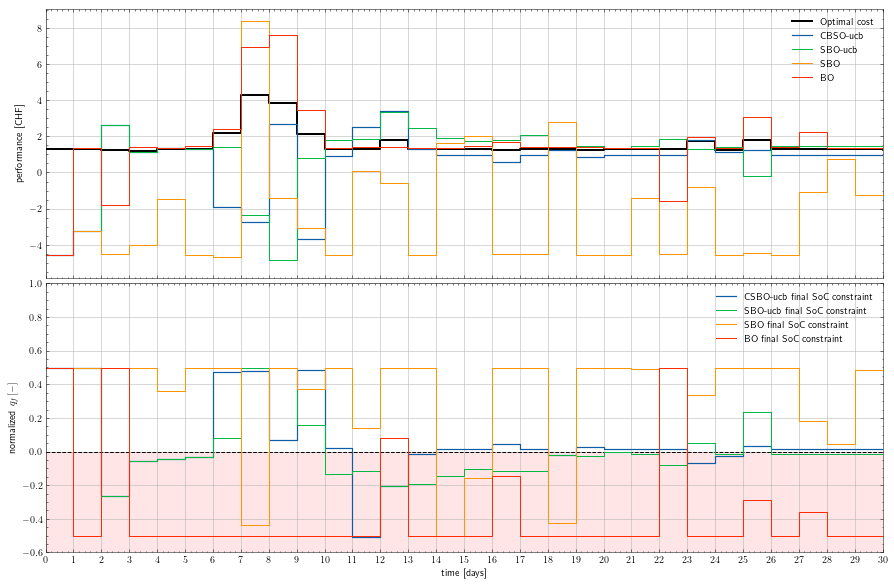

sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike0_b2_CSBO_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike0_b2_CSBO_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike0_b2_CSBO_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike0_b2_CSBO_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike0_b2_SBO_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike0_b2_SBO_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike0_b2_SBO_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike0_b2_SBO_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike0_b2_SBOb_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike0_b2_SBOb_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike0_b2_SBOb_2022_03_21_0731
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike0_b2

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.54271357 -0.79899497] [-4.53721805  0.49940421  0.95811858]
current max estiamte ucb=  (array([1.74874372, 1.        ]), -1.00644194285409, -0.21286058565934202)
1
context=  [0.03046038]
opt parameter and cost:  [ 1.00502513 -0.39698492] [ 1.04041886 -0.00488856 -0.04129669]
current max estiamte ucb=  (array([ 0.94472362, -0.39698492]), 0.7930764471369388, 0.8355994730897874)
2
context=  [0.]
opt parameter and cost:  [ 0.70351759 -0.39698492] [ 1.30175131 -0.00454533 -0.04004827]
current max estiamte ucb=  (array([ 0.64321608, -0.38693467]), 0.7883079988861114, 0.8348307346827609)
3
context=  [0.]
opt parameter and cost:  [ 0.50251256 -0.38693467] [-2.43481422  0.40509844  0.41520939]
current max estiamte ucb=  (array([ 1.10552764, -0.40703518]), 0.68307534571

current max estiamte ucb=  (array([ 0.54271357, -0.35678392]), 1.098972270233523, 1.1077290212341295)
39
context=  [0.]
opt parameter and cost:  [ 0.52261307 -0.34673367] [0.86764796 0.0252135  0.0785693 ]
current max estiamte ucb=  (array([ 0.52261307, -0.34673367]), 1.1001139022839925, 1.1048966978695216)
40
context=  [0.]
opt parameter and cost:  [ 0.50251256 -0.33668342] [0.96960023 0.01604863 0.0816593 ]
current max estiamte ucb=  (array([ 0.52261307, -0.34673367]), 1.1004260361881693, 1.1051910175215467)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.50251256 -0.33668342] [0.96960023 0.01604863 0.0816593 ]
current max estiamte ucb=  (array([ 0.50251256, -0.32663317]), 1.0938423197131766, 1.1070683592866135)
42
context=  [0.25377856]
opt parameter and cost:  [ 0.50251256 -0.32663317] [0.7050884 0.0569184 0.1359212]
current max estiamte ucb=  (array([ 0.60301508, -0.29648241]), 3.213335261362316, 3.232822884374174)
43
context=  [0.3739483]
opt parameter and cost:  [ 0.60301

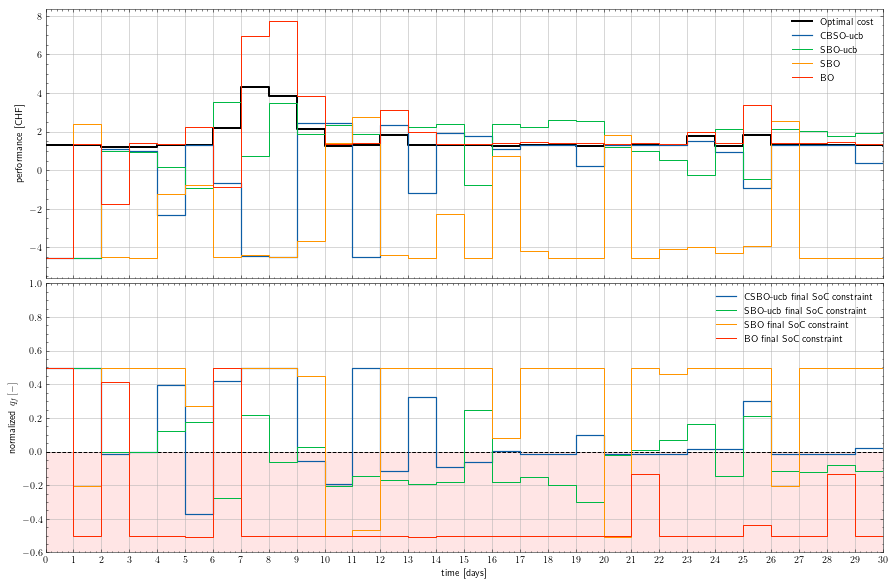

sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike1_b2_CSBO_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike1_b2_CSBO_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike1_b2_CSBO_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike1_b2_CSBO_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike1_b2_SBO_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike1_b2_SBO_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike1_b2_SBO_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike1_b2_SBO_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike1_b2_SBOb_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike1_b2_SBOb_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike1_b2_SBOb_2022_03_21_0737
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike1_b2

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
This is local package in rbc-parameter-tuning
0
context=  [0.]
opt parameter and cost:  [ 0.04020101 -0.74874372] [-4.54235604  0.49936397  0.95936397]
current max estiamte ucb=  (array([0.20100503, 0.67839196]), -1.3013063077388944, -0.34834329885672877)
1
context=  [0.03046038]
opt parameter and cost:  [ 0.04020101 -0.98994975] [-4.54200087  0.49951969  0.95951969]
current max estiamte ucb=  (array([0.12060302, 0.69849246]), -1.3132564879437036, -0.3588932333347262)
2
context=  [0.]
opt parameter and cost:  [ 0.08040201 -0.26633166] [-4.59219188  0.49818993  0.95441377]
current max estiamte ucb=  (array([0.20100503, 0.93969849]), -1.3509837109210172, -0.396996945904106)
3
context=  [0.]
opt parameter and cost:  [ 0.         -0.01507538] [-1.33327237 -0.05130598  0.40969553]
current max estiamte ucb=  (array([0.86432161, 0.08542714]), -1.46076030581

current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.215260319345065, 1.2239569395146768)
38
context=  [0.00144539]
opt parameter and cost:  [ 0.58291457 -0.39698492] [1.08889213 0.02559953 0.00907769]
current max estiamte ucb=  (array([ 1.22613065, -0.64824121]), 2.5813520999428112, 2.970467307211387)
39
context=  [0.]
opt parameter and cost:  [ 0.8241206 -0.6080402] [-0.73148663  0.2837183   0.01425234]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.173256981812038, 1.1812402815026746)
40
context=  [0.]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.56281407, -0.37688442]), 1.1922043167527445, 1.1996187579069246)
41
context=  [0.02557988]
opt parameter and cost:  [ 0.56281407 -0.37688442] [ 1.31304334e+00 -4.28229041e-03  1.24942676e-03]
current max estiamte ucb=  (array([ 0.58291457, -0.37688442]), 1.2749311488737267, 1.2866661695413693)
42
context=  [0.25377856]

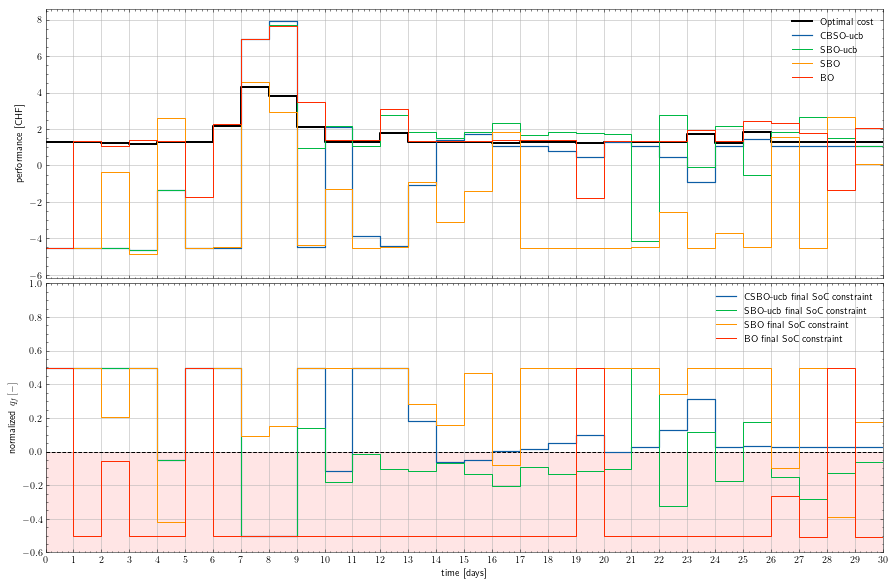

sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike2_b2_CSBO_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike2_b2_CSBO_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike2_b2_CSBO_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike2_b2_CSBO_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike2_b2_SBO_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike2_b2_SBO_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike2_b2_SBO_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike2_b2_SBO_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_post_loglike2_b2_SBOb_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_post_loglike2_b2_SBOb_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/x_prior_loglike2_b2_SBOb_2022_03_21_0743
sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/y_prior_loglike2_b2

 /opt/anaconda3/envs/env1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [80]:

from itertools import product
betas=[0.5,1,2]
for beta in betas:
    for idx,hp in enumerate(hps):
        print(beta,hp)
    #     print(par_names[idx],betas[idx])
    #     hp=get_data(path)
        e_ch=data.e_char.asfreq('D').shift(-2).dropna()
    #     e_dis=data.e_dis.asfreq('D').shift(-2).dropna() # Shift 2 day: 1 to cancel convolution margin and 1 to compensate for N_lim=1day
        ctxt=e_ch

        Vz=hp[0]
        Lz=hp[1]
        Vq=hp[2]
        Lq=hp[3]
        Vqs=hp[4]
        Lqs=hp[5]
        beta=beta
        Lctxt_z=hp[7]
        Lctxt_q=hp[8]
        Lctxt_qs=hp[9]

        noise_cst = 1e-2#cst_mmnt_noise.mean()/10
        noise_const =2e-5
        noise_safeconst =1e-6
        S_f_sp=55
        S_os_max=0
        soc_lim=[30,80]
        soc_softc=[32,80]
        # opt_cost=rnd_opt_cst[0]
        def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
            p_load=data[:T*day+N_lim[1]]
            x=x0
            i=0
            while True:
        #         i=0 #always first day
                soc_i=50 #always same soc_i
                res=plant_cost(x=x,T=T,p_load=p_load.copy(),N_lim=N_lim,soc_lim=soc_lim,soc_softc=soc_softc,soc_i=soc_i,phib=phib,plot=False,plot_cost=False,noise=False)
                c=res[0]
                q=res[1:]  
                x,i=yield c[3],(q[1]-S_f_sp)/soc_std,(q[2]-soc_softc[0])/soc_std
                p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
        #         print('day: ',i)
        #         plt.plot(p_load[N_lim[1]:])
        #         plt.show()
        bounds = [(0., 4.),(-1,1)]
        parameter_set = safeopt.linearly_spaced_combinations(bounds, 200)
        # parameter_set=parameter_set[parameter_set[:,0]>=-parameter_set[:,1]]
        # Define Kernel
        # for x_ in np.random.uniform(-0.5,-0.05,10):
        cost_kernel_ = GPy.kern.Matern32(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
        cost_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
        cost_kernel=cost_kernel_*cost_context_kernel

        const_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
        const_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
        const_kernel=const_kernel_*const_context_kernel

        safeconst_kernel_=GPy.kern.Matern32(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
        safeconst_context_kernel=GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
        safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

        context=np.array([[ctxt[0]]])
        x0=np.array([[0.,-0.5]])
        x=np.hstack([x0,context])
        cost=cost_g(x0.flatten())
        y0= np.atleast_2d(cost.send(None))
        cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
        const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
        safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)

        cost_gp_ = GPy.models.GPRegression(x0,y0[:,0,None], cost_kernel_, noise_var=noise_cst)
        const_gp_= GPy.models.GPRegression(x0,y0[:,1,None], const_kernel_, noise_var=noise_const)
        safeconst_gp_= GPy.models.GPRegression(x0,y0[:,2,None], safeconst_kernel_, noise_var=noise_safeconst)

        gp=[cost_gp,const_gp,safeconst_gp]
        gp_=[cost_gp_,const_gp_,safeconst_gp_]
        gp__=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]
        gpva=[cost_gp_.copy(),const_gp_.copy(),safeconst_gp_.copy()]

        # The optimization routine
        optva = safeopt.SafeOpt(gpva,parameter_set=parameter_set,fmin=[-np.inf,-np.inf,-np.inf], threshold=np.array([-np.inf,-np.inf,-50]),beta=beta)
        opt = safeopt.SafeOpt(gp__,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
        opt_ucb_=safeopt.SafeOpt(gp_,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta)
        opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max,0], threshold=np.array([-np.inf,-50,-50]),beta=beta,num_contexts=1)
        # opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
        iterations=len(data)*dt//day-2

        y_post=np.empty((iterations,y0.shape[1]))
        x_post=np.empty((iterations,x0.shape[1]))
        x_prior=np.empty((iterations,x0.shape[1]))
        y_prior=[]
        y_prior.append(y0.flatten())

        y_post_=np.empty((iterations,y0.shape[1]))
        x_post_=np.empty((iterations,x0.shape[1]))
        x_prior_=np.empty((iterations,x0.shape[1]))
        y_prior_=[]
        y_prior_.append(y0.flatten())

        y_post__=np.empty((iterations,y0.shape[1]))
        x_post__=np.empty((iterations,x0.shape[1]))
        x_prior__=np.empty((iterations,x0.shape[1]))
        y_prior__=[]
        y_prior__.append(y0.flatten())

        y_postva=np.empty((iterations,y0.shape[1]))
        x_postva=np.empty((iterations,x0.shape[1]))
        x_priorva=np.empty((iterations,x0.shape[1]))
        y_priorva=[]
        y_priorva.append(y0.flatten())

        for i in range(iterations):
            print(i)
            # Get optimizer for same day
            try:
                x_post_[i,:] = opt_ucb_.optimize(ucb=True)        
                x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
                x_post__[i,:] = opt.optimize()
                x_postva[i,:] = optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_post_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]
                x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
                x_post__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]
                x_postva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]

            y_post[i,:] = cost.send((x_post[i,:].flatten(),i))
            y_post_[i,:] = cost.send((x_post_[i,:].flatten(),i))
            y_post__[i,:] = cost.send((x_post__[i,:].flatten(),i))
            y_postva[i,:] = cost.send((x_postva[i,:].flatten(),i))    

        #     if y_post[i,1]<-1e-1:
        #         print('Constraint violated',-soc_std*y_post[i,1],y_post[i,1])
        #         break
            # Get context of next day
            context=np.array([ctxt[i+1]])
            print('context= ',context)
            try:
                x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
                x_prior_[i,:] =  opt_ucb_.optimize(ucb=True)
                x_prior__[i,:] =  opt.optimize(ucb=False)
                x_priorva[i,:] =  optva.optimize(ucb=True)

            except EnvironmentError as e:
                print(e)
                x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    
                x_prior_[i,:]=opt_ucb_.get_maximum(beta_estimate=0.0)[0]   
                x_prior__[i,:]=opt.get_maximum(beta_estimate=0.0)[0]    
                x_priorva[i,:]=optva.get_maximum(beta_estimate=0.0)[0]            

            y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))
            y_prior_.append(cost.send((x_prior_[i,:].flatten(),i+1)))
            y_prior__.append(cost.send((x_prior__[i,:].flatten(),i+1)))    
            y_priorva.append(cost.send((x_priorva[i,:].flatten(),i+1)))    


            print('opt parameter and cost: ',x_post[i,:],y_post[i,:])
            opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)
            opt_ucb_.add_new_data_point(x_prior_[i,:], np.atleast_2d(y_prior_[-1])) 
            opt.add_new_data_point(x_prior__[i,:], np.atleast_2d(y_prior__[-1]))   
            optva.add_new_data_point(x_priorva[i,:], np.atleast_2d(y_priorva[-1])) 

            print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
        y_prior=np.array(y_prior[:-1])
        y_prior_=np.array(y_prior_[:-1])
        y_prior__=np.array(y_prior__[:-1])
        y_priorva=np.array(y_priorva[:-1])

        err=-rnd_opt_cst.flatten()[10:iterations]-y_prior[10:,0]
        print(np.abs(err).sum()/(iterations-10))

        # mpl.rcParams['text.usetex']=True

        with plt.style.context('science'):
            err=25e-2
            # plt.step(range(iterations),best_constrained_value(y_meas),where='post',label='SafeOpt')
            fig,ax=plt.subplots(2,sharex=True,figsize=(15,10))
            ax[0].step(range(iterations),-rnd_opt_cst[:iterations],where='post',label='Optimal cost',color='black',linewidth=2)
    #         ax[0].step(range(iterations),y_post[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
    #         ax[0].step(range(iterations),y_post_[:,0],where='post',label='SBO-ucb')
    #         ax[0].step(range(iterations),y_post__[:,0],where='post',label='SBO')
    #         ax[0].step(range(iterations),y_postva[:,0],where='post',label='BO')

            ax[0].step(range(iterations),y_prior[:,0],where='post',label='CBSO-ucb',linewidth=1.2)
            ax[0].step(range(iterations),y_prior_[:,0],where='post',label='SBO-ucb')
            ax[0].step(range(iterations),y_prior__[:,0],where='post',label='SBO')
            ax[0].step(range(iterations),y_priorva[:,0],where='post',label='BO')

            ax[0].set_xticks(np.arange(0,iterations,1))
            ax[0].set_ylabel('performance [CHF]')
            ax[0].legend()

            # plt.step(range(iterations),-y_meas[:,1],where='post',label='SafeOpt')
    #         ax[1].step(range(iterations),y_post[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
    #         ax[1].step(range(iterations),y_post_[:,1],where='post',label='SBO-ucb final SoC constraint')
    #         ax[1].step(range(iterations),y_post__[:,1],where='post',label='SBO final SoC constraint')
    #         ax[1].step(range(iterations),y_postva[:,1],where='post',label='BO final SoC constraint')
            ax[1].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            ax[1].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)

            ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSBO-ucb final SoC constraint',linewidth=1.2)
            ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SBO-ucb final SoC constraint')
            ax[1].step(range(iterations),y_prior__[:,1],where='post',label='SBO final SoC constraint')
            ax[1].step(range(iterations),y_priorva[:,1],where='post',label='BO final SoC constraint')

            # ax[1].step(range(iterations),y_prior_[:,1],where='post',label='SO prior final SoC constraint')
            # ax[1].step(range(iterations),y_prior[:,1],where='post',label='CSO prior final SoC constraint')
            ax[1].set_ylim([-0.6,1])
            ax[1].set_ylabel(r'normalized $q_f [-]$')
            ax[1].legend()

            # ax[2].step(range(iterations),y_post[:,2],where='post',label='bound SoC constraint')
            # ax[2].step(range(iterations),y_prior[:,2],where='post',label='bound final SoC constraint')
            # ax[2].hlines(-S_os_max,0,iterations,'k',linestyles='--')
            # ax[2].fill_between(range(iterations),y1=-S_os_max,y2=-1,color='red',alpha=0.1)
            # ax[2].set_ylim([-0.1,1])
            # ax[2].legend()
            plt.xlabel('time [days]')
            plt.xlim([0,30])
            plt.subplots_adjust(hspace=0.02)
    #         plt.savefig(f'RBC312_rp_b0_qf_55_beta_{beta}_{par_names[idx]}_model.png')
        plt.show()
        name=f'loglike{idx}_b{beta}_'
        optype='CSBO'
        sim_dir='sim_data_312_winter_rp0_qf_55_qs_32_mtrnP1P3/'
        save_data(x_post,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBO'
        save_data(x_post_,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post_,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior_,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior_,'y_prior_'+name+optype,folder=sim_dir)
        optype='SBOb'
        save_data(x_post__,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_post__,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_prior__,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_prior__,'y_prior_'+name+optype,folder=sim_dir)
        optype='BO'
        save_data(x_postva,'x_post_'+name+optype,folder=sim_dir)
        save_data(y_postva,'y_post_'+name+optype,folder=sim_dir)
        save_data(x_priorva,'x_prior_'+name+optype,folder=sim_dir)
        save_data(y_priorva,'y_prior_'+name+optype,folder=sim_dir)

        save_data(hp,'hyperpar_'+name,folder=sim_dir)
        save_data(opt_ucb.gps,'CSBO_'+name,folder=sim_dir,pick=True,npy=False)
        save_data(opt_ucb_.gps,'SBO_'+name,folder=sim_dir,pick=True,npy=False)    

# Evaluation 

In [286]:
file_paths[0][-19:-4]

'2022_03_05_0602'

In [291]:
import glob
paths=glob.glob('sim_data_312_winter_rp_qf/y_post_loglike_b*')
file_paths=[os.path.normpath(path).split(os.sep)[1] for path in paths] #get file names
betas=[file_path.split('_')[3].strip('b') for file_path in file_paths] # get betas
for i, beta in enumerate(betas):
    if beta.startswith('0'):
        betas[i]=float(beta.replace('0','.'))
    else:
        betas[i]=float(beta) # convert to float and add . to 05

optypes=[file_path.split('_')[4] for file_path in file_paths] # get optypes 
dates=[file_path[-19:-4] for file_path in file_paths] # get betas


['2022_03_05_0602',
 '2022_03_05_0602',
 '2022_03_05_0242',
 '2022_03_05_0546',
 '2022_03_05_0602',
 '2022_03_05_0637',
 '2022_03_05_0637',
 '2022_03_05_0546',
 '2022_03_05_0546',
 '2022_03_05_0242',
 '2022_03_05_0637',
 '2022_03_05_0637',
 '2022_03_05_0602',
 '2022_03_05_0546']

In [296]:
ct=10
mae=[]
cnst10=[]
cnst0=[]
for i,path in enumerate(paths):
    cst=get_data(path)[:,0]
    err=-rnd_opt_cst.flatten()[ct:len(cst)]-cst[ct:]
    mae.append(np.abs(err).sum()/(len(cst)-ct))
    cnst=get_data(path)[:,1]
    cnst10.append((cnst<-0.1).astype(int).sum())
    cnst0.append((cnst<-0).astype(int).sum())    
    print(file_paths[i],(cnst<-0).astype(int).sum())

y_post_loglike_b2_SBO_2022_03_05_0602.npy 5
y_post_loglike_b2_BO_2022_03_05_0602.npy 36
y_post_loglike_b2_CSBO_2022_03_05_0242.npy 19
y_post_loglike_b1_CSBO_2022_03_05_0546.npy 5
y_post_loglike_b2_SBOb_2022_03_05_0602.npy 1
y_post_loglike_b05_SBOb_2022_03_05_0637.npy 2
y_post_loglike_b05_BO_2022_03_05_0637.npy 37
y_post_loglike_b1_BO_2022_03_05_0546.npy 36
y_post_loglike_b1_SBO_2022_03_05_0546.npy 6
y_post_loglike_b2_SBO_2022_03_05_0242.npy 5
y_post_loglike_b05_SBO_2022_03_05_0637.npy 13
y_post_loglike_b05_CSBO_2022_03_05_0637.npy 19
y_post_loglike_b2_CSBO_2022_03_05_0602.npy 0
y_post_loglike_b1_SBOb_2022_03_05_0546.npy 1


In [292]:
eval_df=pd.DataFrame({'optype':optypes,'beta':betas,'mae':mae,'cnst0':cnst0,'cnst10':cnst10,'date':dates})
eval_df=eval_df.set_index(['beta','optype']).sort_index()
eval_df


mae  cnst0  cnst10             date
beta optype                                          
0.5  BO      0.986575     37      37  2022_03_05_0637
     CSBO    0.635154     19       2  2022_03_05_0637
     SBO     0.286739     13       0  2022_03_05_0637
     SBOb    2.986477      2       2  2022_03_05_0637
1.0  BO      1.370720     36      34  2022_03_05_0546
     CSBO    1.215400      5       0  2022_03_05_0546
     SBO     0.368464      6       0  2022_03_05_0546
     SBOb    3.231044      1       1  2022_03_05_0546
2.0  BO      1.147769     36      35  2022_03_05_0602
     CSBO    0.931918     19       4  2022_03_05_0242
     CSBO    1.795221      0       0  2022_03_05_0602
     SBO     0.618568      5       1  2022_03_05_0602
     SBO     0.618568      5       1  2022_03_05_0242
     SBOb    4.086556      1       1  2022_03_05_0602

In [ ]:
plt.bar(mae,)

3 3 1


 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


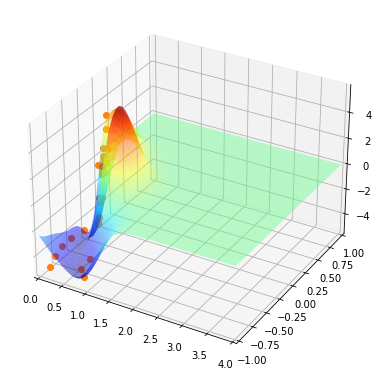

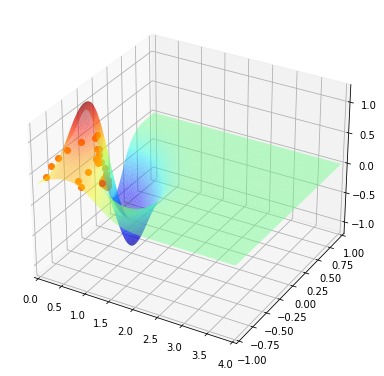

In [140]:
opt_ucb.context=[[0.3]]
opt_ucb.plot(100,plot_3d=True)

3 3 1


 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
 /Users/adrianpaeckelripoll/rbc-parameter-tuning/optimization_sim/../safeopt/utilities.py:269: MatplotlibDeprecationWarning:Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


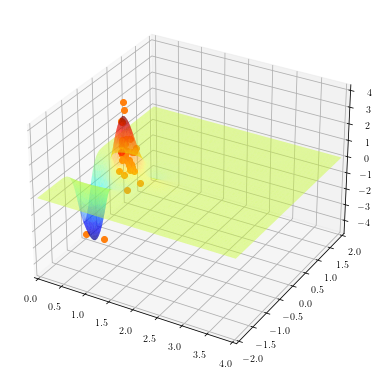

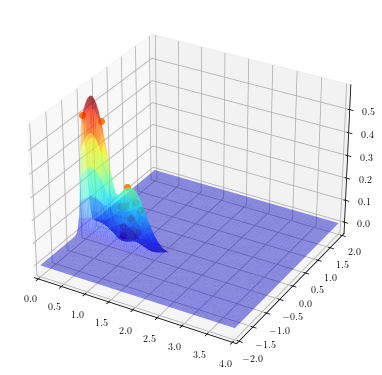

In [66]:
opt_ucb.context=[[0.1]]
opt_ucb.plot(100,plot_3d=True)

In [69]:
def gmax_const(opt,cnt=S_os_max):     
    x,y = opt.data
    max_idx=y[y[:,1]>=-cnt][:,0].argmax()
    return x[y[:,1]>=-cnt][max_idx], y[y[:,1]>=-cnt][:,0].max()
gmax_const(opt_ucb,0)

(array([ 0.83366733, -0.42084168,  0.08682725]), 4.150355788998919)

[2.25, 0.04000000000000001, 2]
This is local package in rbc-parameter-tuning
cost is:  13.977629104570886


13.977629104570886

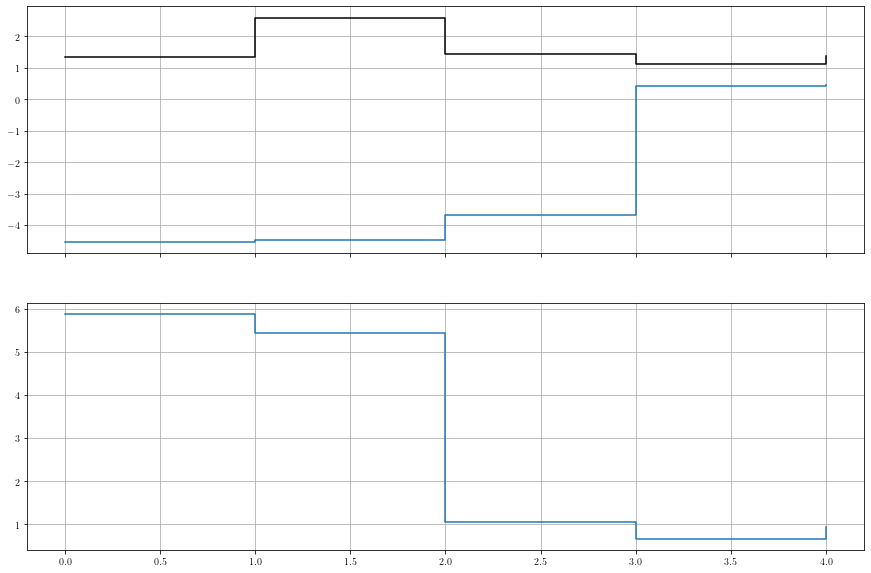

In [121]:
def cost(hp,grad=0):
    ctxt=e_ch
    print(hp)
#     hp=[1.5**2,[0.32,0.2], #cost
#     0.2**2,[0.3,0.1],# const
#     0.25**2,[0.184, 0.135],#safe  not used in this script!!
#     1,#beta
#     0.12,0.48,0.41] #contexts lenght
    Vz=hp[0]
    Lz[0]=0.32
    Lz[1]=0.2
    Vq=hp[1]
    Lq[0]=0.3
    Lq[1]=0.1    
#     Vqs=hp[4]
#     Lqs=hp[5]
    beta=hp[2]
    Lctxt_z=0.12
    Lctxt_q=0.48
#     Lctxt_qs=hp[9]

    noise_cst = 2e-1#cst_mmnt_noise.mean()/10
    noise_const =5e-4
    noise_safeconst =5e-4
    S_f_sp=55
    S_os_max=0
    opt_cost=rnd_opt_cst[0]
    def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
        p_load=data[:T*day+N_lim[1]]
        x=x0
        i=0
        while True:
    #         i=0 #always first day
            soc_i=50 #always same soc_i
            res=plant_cost(x,T,p_load.copy(),N_lim,soc_lim,soc_softc,soc_i,phib,plot=False,plot_cost=False,noise=False)
            c=res[0]
            q=res[1:]  
            x,i=yield c[3],(q[1]-S_f_sp)/soc_std#,(q[2]-35)/abs(soc_softc[1]-soc_softc[0])
            p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
    #         print('day: ',i)
    #         plt.plot(p_load[N_lim[1]:])
    #         plt.show()
    # Bounds on the inputs variable
    bounds = [(0., 1.),(-0.5,0.5)]
    parameter_set = safeopt.linearly_spaced_combinations(bounds, 100)
    # Define Kernel
    # for x_ in np.random.uniform(-0.5,-0.05,10):
    cost_kernel_ = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
    cost_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
    cost_kernel=cost_kernel_*cost_context_kernel

    const_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
    const_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
    const_kernel=const_kernel_*const_context_kernel

    # safeconst_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
    # safeconst_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
    # safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

    context=np.array([[ctxt[0]]])
    x0=np.array([[0.,-0.5]])
    x=np.hstack([x0,context])
    cost=cost_g(x0.flatten())
    y0= np.atleast_2d(cost.send(None))
    cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
    const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
    # safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)
    gp=[cost_gp,const_gp]
    # The optimization routine
    # opt = safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-50]),beta=beta,num_contexts=1)
    opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-50]),beta=beta,num_contexts=1)
    # opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
    iterations=5

    y_post=np.empty((iterations,y0.shape[1]))
    x_post=np.empty((iterations,x0.shape[1]))
    x_prior=np.empty((iterations,x0.shape[1]))
    y_prior=[]
    y_prior.append(y0.flatten())
    for i in range(iterations):
#         print(i)
        # Get optimizer for same day
        try:
            x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
        except EnvironmentError as e:
            print(e,i,50*(iterations-i))
            return 100.*(iterations-i)
            x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
        y_post[i,:] = cost.send((x_post[i,:].flatten(),i))  
        if y_post[i,1]<-5e-2:
            print('Constraint violated',-1e4*y_post[i,1],y_post[i,1])
            return -1e4*y_post[i,1]
        # Get context of next day
        context=np.array([ctxt[i+1]])
#         print('context= ',context)
        try:
            x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
        except EnvironmentError as e:
            print(e)
            x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    

        y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))


#         print('opt parameter and cost: ',x_post[i,:],y_post[i,:])

        opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)

#         print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
    y_prior=np.array(y_prior[:-1])
    fig,ax=plt.subplots(2,sharex=True,figsize=(15,10))
    # ax[0].step(range(iterations),y_post[:,0],where='post',label='post CSO-ucb')
    ax[0].step(range(iterations),-rnd_opt_cst[:iterations],where='post',label='Optimal cost',color='black')
    ax[0].step(range(iterations),y_prior[:,0],where='post',label='prior CSO-ucb')
    ax[1].step(range(iterations),np.abs(-rnd_opt_cst[:iterations].flatten()-y_post[:,0]),where='post',label='MAE')
    cst=np.abs(-rnd_opt_cst[:iterations].flatten()-y_post[:,0]).sum()
#     print(np.abs(rnd_opt_cst[:iterations].flatten()-y_post[:,0]))
#     def hp_const_cost(x):
#         if x <-5e-2:
#             return -500*x
#         else: return 0
#     cst=cst+np.array(list(map(hp_const_cost,y_post[:,1]))).sum()
    print('cost is: ',cst)
    return cst
cost([1.5**2,0.2**2,2])

# Hpyerparameter tuning NL_opt


In [ ]:
import nlopt as nl
def cost(hp,gradient=0):
    print(hp)
    Vz=hp[0]
    Lz[0]=hp[1]
    Lz[1]=hp[2]
    Vq=hp[3]
    Lq[0]=hp[4]
    Lq[1]=hp[5]    
#     Vqs=hp[4]
#     Lqs=hp[5]
    beta=hp[6]
    Lctxt_z=hp[7]
    Lctxt_q=hp[8]
#     Lctxt_qs=hp[9]

    noise_cst = 2e-1#cst_mmnt_noise.mean()/10
    noise_const =5e-3
    noise_safeconst =5e-3
    S_f_sp=55
    S_os_max=0
    opt_cost=rnd_opt_cst[0]
    def cost_g(x0,T=1,data=data.power_load[0*day:].copy().values,N_lim=[15,day],soc_lim=soc_lim,soc_ref=soc_ref,soc_i=50,phib=phib):
        p_load=data[:T*day+N_lim[1]]
        x=x0
        i=0
        while True:
    #         i=0 #always first day
            soc_i=50 #always same soc_i
            res=plant_cost(x,T,p_load.copy(),N_lim,soc_lim,soc_softc,soc_i,phib,plot=False,plot_cost=False,noise=False)
            c=res[0]
            q=res[1:]  
            x,i=yield c[3],(q[1]-S_f_sp)/soc_std#,(q[2]-35)/abs(soc_softc[1]-soc_softc[0])
            p_load=data[i*T*day:(i+1)*T*day+N_lim[1]]
    #         print('day: ',i)
    #         plt.plot(p_load[N_lim[1]:])
    #         plt.show()
    # Bounds on the inputs variable
    bounds = [(0., 1.),(-0.5,0.5)]
    parameter_set = safeopt.linearly_spaced_combinations(bounds, 100)
    # Define Kernel
    # for x_ in np.random.uniform(-0.5,-0.05,10):
    cost_kernel_ = GPy.kern.RBF(input_dim=len(bounds), variance=Vz, lengthscale=[Lz[0],Lz[1]], ARD=True,active_dims=[0,1])
    cost_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_z, ARD=True,active_dims=[2],name='context')
    cost_kernel=cost_kernel_*cost_context_kernel

    const_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vq, lengthscale=[Lq[0],Lq[1]], ARD=True,active_dims=[0,1])
    const_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_q, ARD=True,active_dims=[2],name='context')
    const_kernel=const_kernel_*const_context_kernel

    # safeconst_kernel_=GPy.kern.RBF(input_dim=len(bounds), variance=Vqs, lengthscale=[Lqs[0],Lqs[1]], ARD=True,active_dims=[0,1])
    # safeconst_context_kernel=GPy.kern.RBF(input_dim=1, variance=1, lengthscale=Lctxt_qs, ARD=True,active_dims=[2],name='context')
    # safeconst_kernel=safeconst_kernel_*safeconst_context_kernel

    context=np.array([[0]])
    x0=np.array([[0.,-0.5]])
    x=np.hstack([x0,context])
    cost=cost_g(x0.flatten())
    y0= np.atleast_2d(cost.send(None))
    cost_gp = GPy.models.GPRegression(x,y0[:,0,None], cost_kernel, noise_var=noise_cst)
    const_gp= GPy.models.GPRegression(x,y0[:,1,None], const_kernel, noise_var=noise_const)
    # safeconst_gp= GPy.models.GPRegression(x,y0[:,2,None], safeconst_kernel, noise_var=noise_safeconst)
    gp=[cost_gp,const_gp]
    # The optimization routine
    # opt = safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-50]),beta=beta,num_contexts=1)
    opt_ucb=safeopt.SafeOpt(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-50]),beta=beta,num_contexts=1)
    # opt_ucb=safeopt.SafeOptSwarm(gp,parameter_set=parameter_set,fmin=[-np.inf,-S_os_max], threshold=np.array([-np.inf,-5]))
    iterations=20

    y_post=np.empty((iterations,y0.shape[1]))
    x_post=np.empty((iterations,x0.shape[1]))
    x_prior=np.empty((iterations,x0.shape[1]))
    y_prior=[]
    y_prior.append(y0.flatten())
    for i in range(iterations):
#         print(i)
        # Get optimizer for same day
        try:
            x_post[i,:] = opt_ucb.optimize(context=context,ucb=True)
        except EnvironmentError as e:
            print(e,200.)
            return 200.
            x_post[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]
        y_post[i,:] = cost.send((x_post[i,:].flatten(),i))  
        if y_post[i,1]<-5e-2:
            print('Constraint violated',-500*y_post[i,1],y_post[i,1])
            return -500*y_post[i,1]
        # Get context of next day
        context=np.array([rss_df[i+1]])
#         print('context= ',context)
        try:
            x_prior[i,:] =  opt_ucb.optimize(context=context,ucb=True)
        except EnvironmentError as e:
            print(e)
            x_prior[i,:]=opt_ucb.get_maximum(context=context,beta_estimate=0.0)[0]    

        y_prior.append(cost.send((x_prior[i,:].flatten(),i+1)))


#         print('opt parameter and cost: ',x_post[i,:],y_post[i,:])

        opt_ucb.add_new_data_point(x_prior[i,:], np.atleast_2d(y_prior[-1]),context=context)

#         print('current max estiamte ucb= ',opt_ucb.get_maximum(context=context,beta_estimate=0.1))
    cst=np.abs(rnd_opt_cst[:iterations].flatten()-y_post[:,0]).sum()
#     print(np.abs(rnd_opt_cst[:iterations].flatten()-y_post[:,0]))
#     def hp_const_cost(x):
#         if x <-5e-2:
#             return -500*x
#         else: return 0
#     cst=cst+np.array(list(map(hp_const_cost,y_post[:,1]))).sum()
    print('cost is: ',cst)
    return cst
    
    





max_eval=1000
#     Local optimization
opt = nl.opt(nl.GN_DIRECT, 9)
opt.set_lower_bounds([1e-2,1e-2,1e-2,
                      1e-2,1e-2,1e-2,
                      5e-1,
                     1e-2,1e-2])
opt.set_upper_bounds([10,1,1,
                      10,1,1,
                      4,
                     1,1])

opt.set_min_objective(cost)    
opt.set_xtol_rel(1e-3)
opt.set_maxeval(max_eval)
a = opt.optimize([5,0.32,0.2,0.26,0.26,0.141,2,0.12,0.48])
minf = opt.last_optimum_value()
print("optimum at ", a)
print("minimum value = ", minf)
print("result code = ", opt.last_optimize_result())

[5.005 0.505 0.505 5.005 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[1.675 0.505 0.505 5.005 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[8.335 0.505 0.505 5.005 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[5.005 0.175 0.505 5.005 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[5.005 0.835 0.505 5.005 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[5.005 0.505 0.175 5.005 0.505 0.505 2.25  0.505 0.505]
This is local package in

This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[1.675 0.175 0.505 8.335 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[1.675 0.835 0.505 8.335 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[8.335 0.175 0.505 8.335 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[8.335 0.835 0.505 8.335 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[5.005 0.835 0.175 1.675 0.505 0.175 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
Constraint violated 81.43228322585

There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[5.005 0.505 0.175 8.335 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[5.005 0.505 0.835 8.335 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[5.005 0.175 0.175 8.335 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[5.005 0.175 0.835 8.335 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[5.005 0.835 0.175 8.335 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.

There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[8.335 0.505 0.835 1.675 0.835 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
cost is:  54.923317660848774
[7.225 0.505 0.175 1.675 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
cost is:  25.06747659033013
[9.445 0.505 0.175 1.675 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
Constraint violated 70.5447792709834 -0.1410895585419668
[8.335 0.395 0.175 1.675 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
There are no safe points to evaluate. 200.0
[8.335 0.615 0.175 1.675 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There are no safe points to evaluate.
cost is:  25.01902188415269
[8.335 0.505 0.065 1.675 0.505 0.505 2.25  0.505 0.505]
This is local package in rbc-parameter-tuning
There 